In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from cnn_model import run_hyperparameter_search, evaluate_on_test, TimeSeriesDataset, CNNRegressor, train_model, split_LOPO
from torch.utils.data import DataLoader
import neurokit2 as nk  # pip install neurokit2
import seaborn as sns
from ml_dataloader import process_physiology_data, extract_raw_physio_windows

## Dataloader

In [2]:
# process_physiology_data(
#     data_path="D:/OneDrive/HubRoom/Projects/SD physiology/Data/processed_individual_anonymized",
#     output_path="./ml_processed",
#     window_seconds=20,
#     stride_seconds=2
# )


In [3]:
extract_raw_physio_windows(
    data_path="D:/OneDrive/HubRoom/Projects/SD physiology/Data/processed_individual_anonymized",
    output_path="./ml_processed_raw",
    window_seconds=5,
    stride_seconds=2,
    sampling_rate=30,
    scenes="Hallway",
    enable_feature_expansion=True,
    fe_diff_orders=(1,2),
    fe_ma_seconds=(2,),
    fe_std_seconds=(5,),
    fe_enable_slope=True,
    fe_enable_iqr=True,
    fe_enable_band_energy=False,
    enable_target_smoothing=True,
    target_smoothing_method="ema",
    target_smoothing_steps=15,   # ≈0.5초 @30Hz
    smooth_before_zscore=True
)


Extracting Raw Signals: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]


✅ 저장 완료: ./ml_processed_raw
📊 X shape: (11979, 77, 150) | y shape: (11979,) | #PIDs: 103
🧩 Channels: 77 | (예: ['EDA_Tonic' 'EDA_Tonic_diff1' 'EDA_Tonic_diff2' 'EDA_Tonic_ma60'
 'EDA_Tonic_std150' 'EDA_Tonic_slope' 'EDA_Tonic_iqr' 'EDA_Phasic'
 'EDA_Phasic_diff1' 'EDA_Phasic_diff2'])
📝 saved: scene_array.npy, windex_array.npy, feature_tag_list.npy, meta.json


In [ ]:
# extract_raw_physio_windows(
#     data_path="D:/OneDrive/HubRoom/Projects/SD physiology/Data/processed_individual_anonymized",
#     output_path="./ml_processed_raw",
#     window_seconds=5,
#     stride_seconds=2,
#     sampling_rate=30,
#     scenes="Hallway",
#     enable_feature_expansion=True,
#     fe_diff_orders=(1,2),
#     fe_ma_seconds=(2,),
#     fe_std_seconds=(5,),
#     fe_enable_slope=True,
#     fe_enable_iqr=True,
#     fe_enable_band_energy=True,  # 대역에너지 ON
#     enable_target_smoothing=True,
#     target_smoothing_method="median",
#     target_smoothing_steps=15,   # 홀수 권장
#     smooth_before_zscore=True
# )

# extract_raw_physio_windows(
#     data_path="D:/OneDrive/HubRoom/Projects/SD physiology/Data/processed_individual_anonymized",
#     output_path="./ml_processed_raw",
#     window_seconds=5,
#     stride_seconds=2,
#     sampling_rate=30,
#     scenes="Hallway",
#     enable_feature_expansion=True,
#     fe_diff_orders=(1,2),
#     fe_ma_seconds=(2,5),         # 다중 스케일
#     fe_std_seconds=(5,10),       # 다중 스케일
#     fe_enable_slope=True,
#     fe_enable_iqr=True,
#     fe_enable_band_energy=True,
#     enable_target_smoothing=True,
#     target_smoothing_method="median",
#     target_smoothing_steps=21,   # ≈0.7초 @30Hz
#     smooth_before_zscore=True
# )


In [5]:
X_array = np.load("./ml_processed_raw/X_array.npy")       # shape: [N, C, T]
y_array = np.load("./ml_processed_raw/y_array.npy")       # shape: [N]
pid_array = np.load("./ml_processed_raw/pid_array.npy")   # shape: [N]

In [6]:
X_array.shape

(38905, 11, 300)

In [2]:


# 가정: df_melt에 ['participant_id', 'feature', 'value'] 포함
df_melt = df_feat.melt(id_vars=['participant', 'start_idx'], 
                       value_vars=[col for col in df_feat.columns if col not in ['participant', 'start_idx']],
                       var_name='feature', value_name='value')

unique_features = df_melt['feature'].unique()

for feat in unique_features:
    plt.figure(figsize=(14, 5))
    sns.boxplot(data=df_melt[df_melt['feature'] == feat],
                x='participant', y='value')
    plt.title(f"Participant-wise Distribution of {feat}")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


NameError: name 'df_feat' is not defined

### Multimodal Test

=== Modality coverage ===
 - EDA: 28 channels
 - PPG: 7 channels
 - RSP: 21 channels
 - Pupil: 21 channels
=== Pairwise overlaps (count / Jaccard) ===
 EDA ∩ PPG: 0 / 0.000
 EDA ∩ RSP: 0 / 0.000
 EDA ∩ Pupil: 0 / 0.000
 PPG ∩ RSP: 0 / 0.000
 PPG ∩ Pupil: 0 / 0.000
 RSP ∩ Pupil: 0 / 0.000

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (6751, 150, 28), y_train shape: (6751,)
⏹️ Early stopping at epoch 16 (best @ 11, val=0.905082)
Saved predictions to gru_test_predictions_seed0.npz
📊 Test R²: 0.2375 | RMSE: 1.0042 | MAE: 0.8024  → saved to gru_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (6653, 150, 28), y_train shape: (6653,)
⏹️ Early stopping at epoch 7 (best @ 2, val=0.748328)
Saved predictions to gru_test_predictions_seed1.npz
📊 Test R²: 0.1779 | RMSE: 1.0427 | MAE: 0.8244  → saved to gru_test_predictions_seed1.npz

🟢 SEED 2 시작

🎯 create_dataloaders X_train shape: (6331, 150, 28), y_train shape: (6331,)
⏹️ Early stopping at epoch 9 (best @ 4, val=0.9

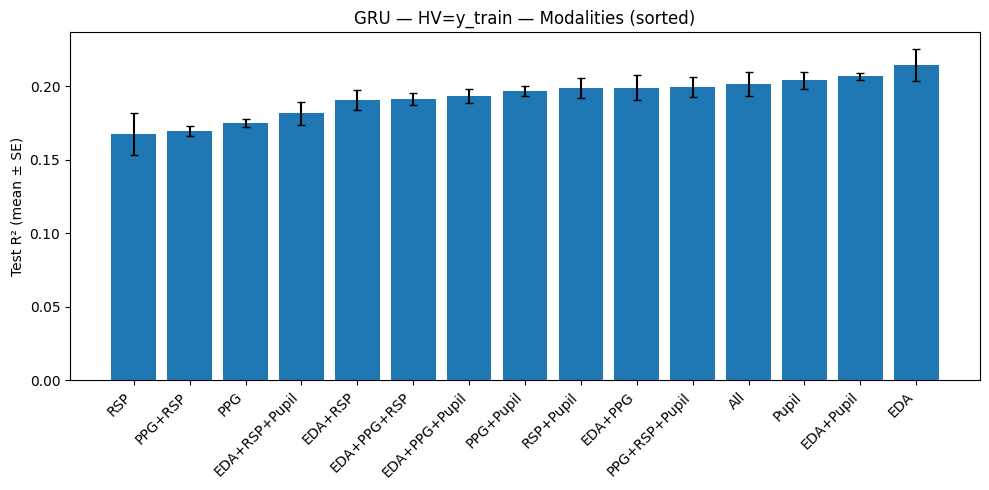

In [7]:
# -*- coding: utf-8 -*-
"""
modal_compare_gru_ytrain_prefix_exclusive.py

빠른 실험 전용 (GRU):
- HV = y_train 고정 (q=0.25 기본)
- best_params는 summary_y_train.json에서 읽되, CNN/LSTM일 경우 GRU 기본값으로 폴백
- 모달리티: 접두어 기반(prefix) + 배타적(exclusive) 매핑으로 겹침 제거
- 유니모달 / 2-way / 3-way / All 조합
- seed/epoch 축소로 빠른 테스트

필요 파일:
  - ml_processed_raw/{X_array.npy, y_array.npy, pid_array.npy, scene_array.npy, windex_array.npy, feature_tag_list.npy}
  - results_planA_fixed_test_GRU/summary_y_train.json  (best_params 참조; 없으면 GRU 기본값)
  - results_planA_fixed_test_GRU/split_fixed_test.json (없으면 자동 생성)

의존:
  - ml_pipeline.py: train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
                 make_participant_disjoint_masks, center_from_train_split
"""

import os, json, itertools
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from ml_pipeline import train_and_evaluate_seeds, summarize_test_results
from ml_utils import (
    set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, center_from_train_split
)

# ----------------------- Config -----------------------
DATA_DIR   = "ml_processed_raw"
OUT_DIR    = "results_planA_fixed_test_GRU"
RESULT_DIR = os.path.join(OUT_DIR, "modal_results_gru_ytrain")
os.makedirs(RESULT_DIR, exist_ok=True)

SEEDS     = 5     # 빠른 테스트용 (필요시 10/20)
EPOCHS    = 30    # 빠른 테스트용 (필요시 50)
PATIENCE  = 5
MIN_DELTA = 1e-3

# GRU 기본 파라미터 (summary_y_train.json이 CNN/LSTM일 수 있으므로 안전 기본값)
GRU_BASE = dict(hidden_size=64, num_layers=1, dropout=0.3, batch_size=32, learning_rate=1e-3)

# ===== 새 규칙: 접두어 기반 + 배타적 매핑 =====
#  - RSA 아님! 데이터는 RSP_* (호흡)
PREFIX_RULES = {
    "EDA":   ("EDA_", "SCR_"),   # SCR_*도 EDA에 포함
    "PPG":   ("PPG_",),
    "RSP":   ("RSP_",),
    "Pupil": ("pupil",),         # pupilL, pupilR, pupil_mean...
}
# 겹칠 경우 우선순위(첫 매칭에만 배정)
PRIORITY = ["PPG", "EDA", "RSP", "Pupil"]
# ------------------------------------------------------


def load_summary_best_params(path_json):
    if not os.path.exists(path_json):
        return dict(GRU_BASE)
    with open(path_json, "r", encoding="utf-8") as f:
        s = json.load(f)
    bp = dict(s.get("best_params", {}))
    # CNN/LSTM 저장본일 수 있음 → GRU에 맞게 보정
    keys_needed = {"hidden_size","num_layers","dropout","batch_size","learning_rate"}
    if not keys_needed.issubset(bp.keys()):
        bp = dict(GRU_BASE)  # fallback
    return bp


def build_modality_index_map_prefix(feature_tags, priority=("PPG","EDA","RSP","Pupil")):
    """
    접두어(prefix) 기반 + 배타적(exclusive) 매핑
    tag가 여러 그룹에 매칭되더라도 'priority' 순서에서 첫 그룹에만 할당
    """
    idx_map = {k: [] for k in PREFIX_RULES.keys()}
    for i, tag in enumerate(feature_tags):
        t = str(tag)
        matched = []
        for modal, prefixes in PREFIX_RULES.items():
            if any(t.startswith(p) for p in prefixes):
                matched.append(modal)
        if not matched:
            continue
        for m in priority:
            if m in matched:
                idx_map[m].append(i)
                break
    return idx_map


def report_overlap(idx_map, expect_counts=None, assert_disjoint=True):
    """
    커버리지와 쌍별 교집합을 리포트.
    기대 개수(expect_counts)가 주어지면 검증.
    assert_disjoint=True이면 쌍별 교집합이 0이 아닐 시 AssertionError.
    """
    names = list(idx_map.keys())
    sets  = {k: set(v) for k, v in idx_map.items()}

    print("=== Modality coverage ===")
    for n in names:
        print(f" - {n}: {len(sets[n])} channels")

    print("=== Pairwise overlaps (count / Jaccard) ===")
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            a, b = sets[names[i]], sets[names[j]]
            inter = len(a & b)
            union = len(a | b) if (a or b) else 1
            jac = inter / union
            print(f" {names[i]} ∩ {names[j]}: {inter} / {jac:.3f}")
            if assert_disjoint:
                assert inter == 0, f"Overlap detected: {names[i]} vs {names[j]} = {inter}"

    if expect_counts:
        for n, exp in expect_counts.items():
            got = len(sets[n])
            assert got == exp, f"{n} count mismatch: got {got}, expect {exp}"


def combos_from_groups(idx_map):
    """
    유니모달 + 모든 2‑way/3‑way + 멀티모달(all)
    (인덱스 집합이 동일하면 중복 제거)
    """
    names = list(idx_map.keys())
    sets  = [set(idx_map[n]) for n in names]
    results = []

    # 유니모달
    for n, s in zip(names, sets):
        if len(s) > 0:
            results.append( (n, sorted(list(s))) )

    # 2-way, 3-way
    for r in [2, 3]:
        for combo in itertools.combinations(range(len(names)), r):
            nm = "+".join([names[i] for i in combo])
            s  = set().union(*[sets[i] for i in combo])
            if len(s) > 0:
                results.append( (nm, sorted(list(s))) )

    # All
    all_set = set().union(*sets)
    if len(all_set) > 0:
        results.append( ("All", sorted(list(all_set))) )

    # 중복 제거 (이름 달라도 인덱스 동일 시 제거)
    seen = set()
    uniq = []
    for nm, idxs in results:
        key = tuple(idxs)
        if key not in seen:
            seen.add(key)
            uniq.append((nm, idxs))
    return uniq


def hv_mask_from_train_y(y_all, pid_all, scene_all, train_mask, q=0.25):
    """
    Train split에서 (pid, scene) 평균 기준 절대편차의 q-분위수를 스레시홀드로 사용
    → 그 이상인 샘플만 keep (고분산 y 기준 마스킹)
    """
    y_all = y_all.astype(np.float32)
    y_tr  = y_all[train_mask]
    p_tr  = pid_all[train_mask]
    s_tr  = scene_all[train_mask]

    # (pid, scene) 평균 및 백업 평균
    ps_mean = {}
    keys = np.stack([p_tr, s_tr], 1)
    for (p, sc) in np.unique(keys, axis=0):
        m = (p_tr==p) & (s_tr==sc)
        ps_mean[(p,sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    pid_mean = {p: float(y_tr[p_tr==p].mean()) for p in np.unique(p_tr)}
    gmean = float(y_tr.mean()) if len(y_tr) else 0.0

    def mu(p, sc):
        v = ps_mean.get((p,sc))
        if v is None or np.isnan(v):
            v = pid_mean.get(p, gmean)
            if v is None or np.isnan(v):
                v = gmean
        return v

    abs_dev_tr  = np.abs(y_tr - np.array([mu(p, s) for p, s in zip(p_tr, s_tr)], np.float32))
    thr = float(np.quantile(abs_dev_tr, q)) if len(abs_dev_tr) else 0.0
    abs_dev_all = np.abs(y_all - np.array([mu(p, s) for p, s in zip(pid_all, scene_all)], np.float32))
    keep_all = abs_dev_all >= thr
    return keep_all


def main():
    set_reproducible()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- Load data -----
    X = np.load(f"{DATA_DIR}/X_array.npy")
    y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
    pid = np.load(f"{DATA_DIR}/pid_array.npy")
    scene = np.load(f"{DATA_DIR}/scene_array.npy")
    widx = np.load(f"{DATA_DIR}/windex_array.npy")
    feature_tags = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

    # 표준화된 형태로 고정 (N,T,C)
    X = to_NTC_strict(X, feature_tags)  # 내부에서 (N,C,T) 감지 시 전치
    N,T,C = X.shape

    # ----- Fixed test cohort (persist / reuse) -----
    split_json = os.path.join(OUT_DIR, "split_fixed_test.json")
    if os.path.exists(split_json):
        with open(split_json, "r", encoding="utf-8") as f:
            meta = json.load(f)
        test_pid_list = meta["test_pids"]
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=meta.get("val_ratio", 0.20), seed=meta.get("seed", 42)
        )
    else:
        test_pid_list = sample_or_load_fixed_test_pids(pid, manual_list=None, k=10, save_path=split_json, seed=42)
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=0.20, seed=42
        )

    TR = np.where(train_m)[0]; VA = np.where(val_m)[0]; TE = np.where(test_m)[0]
    X_tr_raw, y_tr_raw, pid_tr, scene_tr = X[TR], y[TR], pid[TR], scene[TR]
    X_va_raw, y_va_raw, pid_va, scene_va = X[VA], y[VA], pid[VA], scene[VA]
    X_te_raw, y_te_raw, pid_te, scene_te = X[TE], y[TE], pid[TE], scene[TE]

    # ----- HV = y_train -----
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=0.25)
    kTR = keep_all[TR]; kVA = keep_all[VA]; kTE = keep_all[TE]
    Xtr, ytr, pidtr, scenetr = X_tr_raw[kTR], y_tr_raw[kTR], pid_tr[kTR], scene_tr[kTR]
    Xva, yva, pidva, scenva = X_va_raw[kVA], y_va_raw[kVA], pid_va[kVA], scene_va[kVA]
    Xte, yte, pidte, scenete = X_te_raw[kTE], y_te_raw[kTE], pid_te[kTE], scene_te[kTE]

    # ----- Train-only centering -----
    center_fn, _ = center_from_train_split(ytr, pidtr, scenetr)
    ytr_c = center_fn(ytr, pidtr, scenetr)
    yva_c = center_fn(yva, pidva, scenva)
    yte_c = center_fn(yte, pidte, scenete)

    # ----- Modality channel indices (prefix + exclusive) -----
    idx_map = build_modality_index_map_prefix(feature_tags, priority=PRIORITY)

    # 디버그: 커버리지/교집합/기대 개수 검증
    # 기대 개수는 현재 feature_tag_list 기준 (EDA 28, PPG 7, RSP 21, Pupil 21)
    report_overlap(
        idx_map,
        expect_counts={"EDA":28, "PPG":7, "RSP":21, "Pupil":21},
        assert_disjoint=True
    )

    # 조합 생성
    modal_sets = combos_from_groups(idx_map)
    if not modal_sets:
        raise RuntimeError("No modality indices matched. Check PREFIX_RULES against feature_tag_list.")

    # ----- Load best_params (fallback to GRU_BASE if not GRU) -----
    best_json = os.path.join(OUT_DIR, "summary_y_train.json")
    base_params = load_summary_best_params(best_json)  # GRU 키만 보장
    p_template = dict(GRU_BASE)
    p_template.update({k: base_params.get(k, v) for k, v in GRU_BASE.items()})

    # ----- Run per modality subset -----
    rows = []
    for name, idxs in modal_sets:
        if len(idxs) == 0:
            continue

        # slice channels
        Xtr_s = Xtr[:, :, idxs]; Xva_s = Xva[:, :, idxs]; Xte_s = Xte[:, :, idxs]
        inC = Xtr_s.shape[-1]

        # params
        p = dict(p_template)
        p["input_size"] = inC  # ✅ GRU/LSTM 공용: 입력 채널 수 지정

        # train on (train+val)
        X_trv = np.concatenate([Xtr_s, Xva_s], 0)
        y_trv = np.concatenate([ytr_c, yva_c], 0)
        pid_trv = np.concatenate([pidtr, pidva], 0)

        # 학습/평가
        train_losses, val_losses, test_scores = train_and_evaluate_seeds(
            X_trv, y_trv, pid_trv,
            Xte_s, yte_c,
            model_type="GRU",
            best_params=p,
            device=device,
            num_seeds=SEEDS,
            num_epochs=EPOCHS,
            patience=PATIENCE,
            min_delta=MIN_DELTA
        )

        # summarize + 수집
        summarize_test_results(test_scores)
        r2s   = [s[0] for s in test_scores]
        rmses = [s[1] for s in test_scores]
        maes  = [s[2] for s in test_scores]
        rows.append({
            "modality": name,
            "n_channels": inC,
            "seeds": SEEDS,
            "R2_mean": float(np.mean(r2s)),
            "R2_se":   float(np.std(r2s, ddof=1)/np.sqrt(len(r2s))) if len(r2s)>1 else 0.0,
            "RMSE_mean": float(np.mean(rmses)),
            "RMSE_se":   float(np.std(rmses, ddof=1)/np.sqrt(len(rmses))) if len(rmses)>1 else 0.0,
            "MAE_mean": float(np.mean(maes)),
            "MAE_se":   float(np.std(maes, ddof=1)/np.sqrt(len(maes))) if len(maes)>1 else 0.0,
            # 디버깅 편의를 위한 해시(동일 조합 검증)
            "chan_hash": hash(tuple(idxs)),
        })

    # ----- Save CSV -----
    df = pd.DataFrame(rows)
    # (참고) 기존 코드가 오름차순 정렬을 사용했음 → 유지
    df = df.sort_values(by="R2_mean", ascending=True)
    csv_path = os.path.join(RESULT_DIR, "modal_results_gru_ytrain.csv")
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[SAVE] {csv_path}")

    # ----- Plot (sorted) -----
    plt.figure(figsize=(10,5))
    x = np.arange(len(df))
    plt.bar(x, df["R2_mean"], yerr=df["R2_se"], capsize=3)
    plt.xticks(x, df["modality"], rotation=45, ha="right")
    plt.ylabel("Test R² (mean ± SE)")
    plt.title("GRU — HV=y_train — Modalities (sorted)")
    plt.tight_layout()
    fig_path = os.path.join(RESULT_DIR, "modal_results_gru_ytrain_sorted.png")
    plt.savefig(fig_path, dpi=200)
    print(f"[SAVE] {fig_path}")

    return df   # main()에서 df 반환


if __name__ == "__main__":
    result_df = main()


=== Modality coverage ===
 - EDA: 28 channels
 - PPG: 7 channels
 - RSP: 21 channels
 - Pupil: 21 channels
=== Pairwise overlaps (count / Jaccard) ===
 EDA ∩ PPG: 0 / 0.000
 EDA ∩ RSP: 0 / 0.000
 EDA ∩ Pupil: 0 / 0.000
 PPG ∩ RSP: 0 / 0.000
 PPG ∩ Pupil: 0 / 0.000
 RSP ∩ Pupil: 0 / 0.000

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (6751, 150, 28), y_train shape: (6751,)
⏹️ Early stopping at epoch 9 (best @ 4, val=0.925350)
Saved predictions to gru_attn_test_predictions_seed0.npz
📊 Test R²: 0.2151 | RMSE: 1.0189 | MAE: 0.8008  → saved to gru_attn_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (6653, 150, 28), y_train shape: (6653,)
⏹️ Early stopping at epoch 8 (best @ 3, val=0.756665)
Saved predictions to gru_attn_test_predictions_seed1.npz
📊 Test R²: 0.1873 | RMSE: 1.0367 | MAE: 0.8319  → saved to gru_attn_test_predictions_seed1.npz

🟢 SEED 2 시작

🎯 create_dataloaders X_train shape: (6331, 150, 28), y_train shape: (6331,)
⏹️ Early stopping at epoch 17

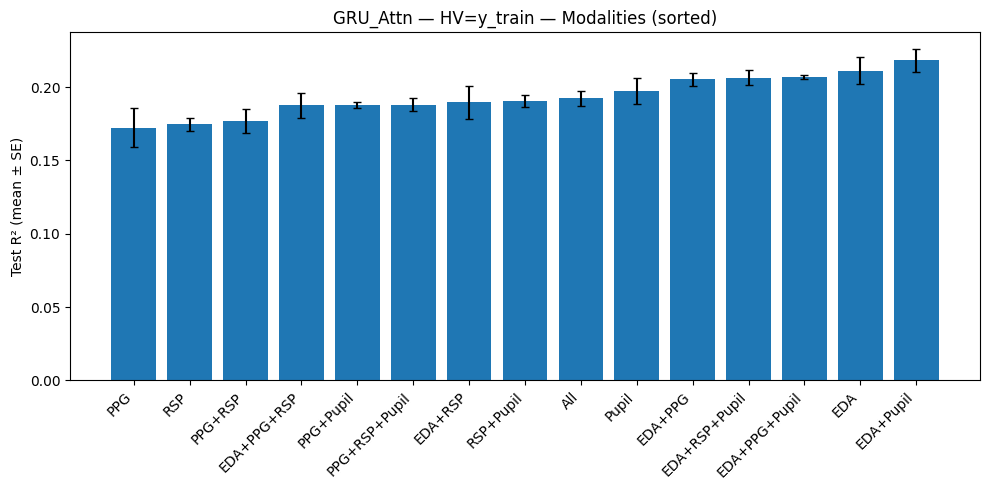

In [8]:
# -*- coding: utf-8 -*-
"""
modal_compare_gruattn_ytrain_prefix_exclusive.py

빠른 실험 전용 (GRU + Attention):
- HV = y_train 고정 (q=0.25 기본)
- best_params는 summary_y_train.json에서 읽되, CNN/LSTM/GRU일 경우 GRU_Attn 기본값으로 폴백
- 모달리티: 접두어 기반(prefix) + 배타적(exclusive) 매핑으로 겹침 제거
- 유니모달 / 2-way / 3-way / All 조합
- seed/epoch 축소로 빠른 테스트

필요 파일:
  - ml_processed_raw/{X_array.npy, y_array.npy, pid_array.npy, scene_array.npy, windex_array.npy, feature_tag_list.npy}
  - results_planA_fixed_test_GRUAttn/summary_y_train.json  (best_params 참조; 없으면 기본값)
  - results_planA_fixed_test_GRUAttn/split_fixed_test.json (없으면 자동 생성)

의존:
  - ml_pipeline.py: train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
                 make_participant_disjoint_masks, center_from_train_split
"""

import os, json, itertools
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from ml_pipeline import train_and_evaluate_seeds, summarize_test_results
from ml_utils import (
    set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, center_from_train_split
)

# ----------------------- Config -----------------------
DATA_DIR   = "ml_processed_raw"
OUT_DIR    = "results_planA_fixed_test_GRUAttn"
RESULT_DIR = os.path.join(OUT_DIR, "modal_results_gruattn_ytrain")
os.makedirs(RESULT_DIR, exist_ok=True)

SEEDS     = 5     # 빠른 테스트용 (필요시 10/20)
EPOCHS    = 30    # 빠른 테스트용 (필요시 50)
PATIENCE  = 5
MIN_DELTA = 1e-3

# GRU_Attn 기본 파라미터 (summary_y_train.json이 다른 모델일 수 있으므로 안전 기본값)
# 주의: ml_pipeline이 GRU_Attn에 추가 파라미터(예: attn_dim 등)를 지원한다면
# summary_y_train.json에 해당 키가 있을 때만 전달되도록 유지하는 것을 권장.
GRUATTN_BASE = dict(hidden_size=64, num_layers=1, dropout=0.3, batch_size=32, learning_rate=1e-3)

# ===== 접두어 기반 + 배타적 매핑 =====
#  - RSA 아님! 데이터는 RSP_* (호흡)
PREFIX_RULES = {
    "EDA":   ("EDA_", "SCR_"),   # SCR_*도 EDA에 포함
    "PPG":   ("PPG_",),
    "RSP":   ("RSP_",),
    "Pupil": ("pupil",),         # pupilL, pupilR, pupil_mean...
}
# 겹칠 경우 우선순위(첫 매칭에만 배정)
PRIORITY = ["PPG", "EDA", "RSP", "Pupil"]
# ------------------------------------------------------


def load_summary_best_params(path_json):
    """
    summary_y_train.json에서 best_params를 읽고,
    GRU_Attn에 필요한 최소 키가 없으면 GRUATTN_BASE로 폴백.
    (추가적인 Attention 관련 키가 있으면 자동으로 포함됨)
    """
    if not os.path.exists(path_json):
        return dict(GRUATTN_BASE)
    with open(path_json, "r", encoding="utf-8") as f:
        s = json.load(f)
    bp = dict(s.get("best_params", {}))
    keys_needed = {"hidden_size","num_layers","dropout","batch_size","learning_rate"}
    if not keys_needed.issubset(bp.keys()):
        bp = dict(GRUATTN_BASE)
    return bp


def build_modality_index_map_prefix(feature_tags, priority=("PPG","EDA","RSP","Pupil")):
    """
    접두어(prefix) 기반 + 배타적(exclusive) 매핑
    tag가 여러 그룹에 매칭되더라도 'priority' 순서에서 첫 그룹에만 할당
    """
    idx_map = {k: [] for k in PREFIX_RULES.keys()}
    for i, tag in enumerate(feature_tags):
        t = str(tag)
        matched = []
        for modal, prefixes in PREFIX_RULES.items():
            if any(t.startswith(p) for p in prefixes):
                matched.append(modal)
        if not matched:
            continue
        for m in priority:
            if m in matched:
                idx_map[m].append(i)
                break
    return idx_map


def report_overlap(idx_map, expect_counts=None, assert_disjoint=True):
    """
    커버리지와 쌍별 교집합을 리포트.
    기대 개수(expect_counts)가 주어지면 검증.
    assert_disjoint=True이면 쌍별 교집합이 0이 아닐 시 AssertionError.
    """
    names = list(idx_map.keys())
    sets  = {k: set(v) for k, v in idx_map.items()}

    print("=== Modality coverage ===")
    for n in names:
        print(f" - {n}: {len(sets[n])} channels")

    print("=== Pairwise overlaps (count / Jaccard) ===")
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            a, b = sets[names[i]], sets[names[j]]
            inter = len(a & b)
            union = len(a | b) if (a or b) else 1
            jac = inter / union
            print(f" {names[i]} ∩ {names[j]}: {inter} / {jac:.3f}")
            if assert_disjoint:
                assert inter == 0, f"Overlap detected: {names[i]} vs {names[j]} = {inter}"

    if expect_counts:
        for n, exp in expect_counts.items():
            got = len(sets[n])
            assert got == exp, f"{n} count mismatch: got {got}, expect {exp}"


def combos_from_groups(idx_map):
    """
    유니모달 + 모든 2‑way/3‑way + 멀티모달(all)
    (인덱스 집합이 동일하면 중복 제거)
    """
    names = list(idx_map.keys())
    sets  = [set(idx_map[n]) for n in names]
    results = []

    # 유니모달
    for n, s in zip(names, sets):
        if len(s) > 0:
            results.append( (n, sorted(list(s))) )

    # 2-way, 3-way
    for r in [2, 3]:
        for combo in itertools.combinations(range(len(names)), r):
            nm = "+".join([names[i] for i in combo])
            s  = set().union(*[sets[i] for i in combo])
            if len(s) > 0:
                results.append( (nm, sorted(list(s))) )

    # All
    all_set = set().union(*sets)
    if len(all_set) > 0:
        results.append( ("All", sorted(list(all_set))) )

    # 중복 제거 (이름 달라도 인덱스 동일 시 제거)
    seen = set()
    uniq = []
    for nm, idxs in results:
        key = tuple(idxs)
        if key not in seen:
            seen.add(key)
            uniq.append((nm, idxs))
    return uniq


def hv_mask_from_train_y(y_all, pid_all, scene_all, train_mask, q=0.25):
    """
    Train split에서 (pid, scene) 평균 기준 절대편차의 q-분위수를 스레시홀드로 사용
    → 그 이상인 샘플만 keep (고분산 y 기준 마스킹)
    """
    y_all = y_all.astype(np.float32)
    y_tr  = y_all[train_mask]
    p_tr  = pid_all[train_mask]
    s_tr  = scene_all[train_mask]

    # (pid, scene) 평균 및 백업 평균
    ps_mean = {}
    keys = np.stack([p_tr, s_tr], 1)
    for (p, sc) in np.unique(keys, axis=0):
        m = (p_tr==p) & (s_tr==sc)
        ps_mean[(p,sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    pid_mean = {p: float(y_tr[p_tr==p].mean()) for p in np.unique(p_tr)}
    gmean = float(y_tr.mean()) if len(y_tr) else 0.0

    def mu(p, sc):
        v = ps_mean.get((p,sc))
        if v is None or np.isnan(v):
            v = pid_mean.get(p, gmean)
            if v is None or np.isnan(v):
                v = gmean
        return v

    abs_dev_tr  = np.abs(y_tr - np.array([mu(p, s) for p, s in zip(p_tr, s_tr)], np.float32))
    thr = float(np.quantile(abs_dev_tr, q)) if len(abs_dev_tr) else 0.0
    abs_dev_all = np.abs(y_all - np.array([mu(p, s) for p, s in zip(pid_all, scene_all)], np.float32))
    keep_all = abs_dev_all >= thr
    return keep_all


def main():
    set_reproducible()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- Load data -----
    X = np.load(f"{DATA_DIR}/X_array.npy")
    y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
    pid = np.load(f"{DATA_DIR}/pid_array.npy")
    scene = np.load(f"{DATA_DIR}/scene_array.npy")
    widx = np.load(f"{DATA_DIR}/windex_array.npy")
    feature_tags = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

    # 표준화된 형태로 고정 (N,T,C)
    X = to_NTC_strict(X, feature_tags)  # 내부에서 (N,C,T) 감지 시 전치
    N,T,C = X.shape

    # ----- Fixed test cohort (persist / reuse) -----
    split_json = os.path.join(OUT_DIR, "split_fixed_test.json")
    if os.path.exists(split_json):
        with open(split_json, "r", encoding="utf-8") as f:
            meta = json.load(f)
        test_pid_list = meta["test_pids"]
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=meta.get("val_ratio", 0.20), seed=meta.get("seed", 42)
        )
    else:
        test_pid_list = sample_or_load_fixed_test_pids(pid, manual_list=None, k=10, save_path=split_json, seed=42)
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=0.20, seed=42
        )

    TR = np.where(train_m)[0]; VA = np.where(val_m)[0]; TE = np.where(test_m)[0]
    X_tr_raw, y_tr_raw, pid_tr, scene_tr = X[TR], y[TR], pid[TR], scene[TR]
    X_va_raw, y_va_raw, pid_va, scene_va = X[VA], y[VA], pid[VA], scene[VA]
    X_te_raw, y_te_raw, pid_te, scene_te = X[TE], y[TE], pid[TE], scene[TE]

    # ----- HV = y_train -----
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=0.25)
    kTR = keep_all[TR]; kVA = keep_all[VA]; kTE = keep_all[TE]
    Xtr, ytr, pidtr, scenetr = X_tr_raw[kTR], y_tr_raw[kTR], pid_tr[kTR], scene_tr[kTR]
    Xva, yva, pidva, scenva = X_va_raw[kVA], y_va_raw[kVA], pid_va[kVA], scene_va[kVA]
    Xte, yte, pidte, scenete = X_te_raw[kTE], y_te_raw[kTE], pid_te[kTE], scene_te[kTE]

    # ----- Train-only centering -----
    center_fn, _ = center_from_train_split(ytr, pidtr, scenetr)
    ytr_c = center_fn(ytr, pidtr, scenetr)
    yva_c = center_fn(yva, pidva, scenva)
    yte_c = center_fn(yte, pidte, scenete)

    # ----- Modality channel indices (prefix + exclusive) -----
    idx_map = build_modality_index_map_prefix(feature_tags, priority=PRIORITY)

    # 디버그: 커버리지/교집합/기대 개수 검증
    # 기대 개수는 현재 feature_tag_list 기준 (EDA 28, PPG 7, RSP 21, Pupil 21)
    report_overlap(
        idx_map,
        expect_counts={"EDA":28, "PPG":7, "RSP":21, "Pupil":21},
        assert_disjoint=True
    )

    # 조합 생성
    modal_sets = combos_from_groups(idx_map)
    if not modal_sets:
        raise RuntimeError("No modality indices matched. Check PREFIX_RULES against feature_tag_list.")

    # ----- Load best_params (fallback to GRUATTN_BASE if not GRU_Attn) -----
    best_json = os.path.join(OUT_DIR, "summary_y_train.json")
    base_params = load_summary_best_params(best_json)  # 최소 GRU 키 보장
    p_template = dict(GRUATTN_BASE)
    # best_params에 추가 키(예: attn 관련)가 있으면 그대로 보존됨
    for k, v in base_params.items():
        p_template[k] = v

    # ----- Run per modality subset -----
    rows = []
    for name, idxs in modal_sets:
        if len(idxs) == 0:
            continue

        # slice channels
        Xtr_s = Xtr[:, :, idxs]; Xva_s = Xva[:, :, idxs]; Xte_s = Xte[:, :, idxs]
        inC = Xtr_s.shape[-1]

        # params
        p = dict(p_template)
        p["input_size"] = inC  # ✅ GRU/GRU_Attn/LSTM 공용: 입력 채널 수 지정

        # train on (train+val)
        X_trv = np.concatenate([Xtr_s, Xva_s], 0)
        y_trv = np.concatenate([ytr_c, yva_c], 0)
        pid_trv = np.concatenate([pidtr, pidva], 0)

        # 학습/평가
        train_losses, val_losses, test_scores = train_and_evaluate_seeds(
            X_trv, y_trv, pid_trv,
            Xte_s, yte_c,
            model_type="GRU_Attn",   # ✅ 주의: ml_pipeline이 이 문자열로 분기해야 함
            best_params=p,
            device=device,
            num_seeds=SEEDS,
            num_epochs=EPOCHS,
            patience=PATIENCE,
            min_delta=MIN_DELTA
        )

        # summarize + 수집
        summarize_test_results(test_scores)
        r2s   = [s[0] for s in test_scores]
        rmses = [s[1] for s in test_scores]
        maes  = [s[2] for s in test_scores]
        rows.append({
            "modality": name,
            "n_channels": inC,
            "seeds": SEEDS,
            "R2_mean": float(np.mean(r2s)),
            "R2_se":   float(np.std(r2s, ddof=1)/np.sqrt(len(r2s))) if len(r2s)>1 else 0.0,
            "RMSE_mean": float(np.mean(rmses)),
            "RMSE_se":   float(np.std(rmses, ddof=1)/np.sqrt(len(rmses))) if len(rmses)>1 else 0.0,
            "MAE_mean": float(np.mean(maes)),
            "MAE_se":   float(np.std(maes, ddof=1)/np.sqrt(len(maes))) if len(maes)>1 else 0.0,
            # 디버깅 편의를 위한 해시(동일 조합 검증)
            "chan_hash": hash(tuple(idxs)),
        })

    # ----- Save CSV -----
    df = pd.DataFrame(rows)
    df = df.sort_values(by="R2_mean", ascending=True)  # 필요시 False로 변경
    csv_path = os.path.join(RESULT_DIR, "modal_results_gruattn_ytrain.csv")
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[SAVE] {csv_path}")

    # ----- Plot (sorted) -----
    plt.figure(figsize=(10,5))
    x = np.arange(len(df))
    plt.bar(x, df["R2_mean"], yerr=df["R2_se"], capsize=3)
    plt.xticks(x, df["modality"], rotation=45, ha="right")
    plt.ylabel("Test R² (mean ± SE)")
    plt.title("GRU_Attn — HV=y_train — Modalities (sorted)")
    plt.tight_layout()
    fig_path = os.path.join(RESULT_DIR, "modal_results_gruattn_ytrain_sorted.png")
    plt.savefig(fig_path, dpi=200)
    print(f"[SAVE] {fig_path}")

    return df   # main()에서 df 반환


if __name__ == "__main__":
    result_df = main()


=== Modality coverage ===
 - EDA: 28 channels
 - PPG: 7 channels
 - RSP: 21 channels
 - Pupil: 21 channels
=== Pairwise overlaps (count / Jaccard) ===
 EDA ∩ PPG: 0 / 0.000
 EDA ∩ RSP: 0 / 0.000
 EDA ∩ Pupil: 0 / 0.000
 PPG ∩ RSP: 0 / 0.000
 PPG ∩ Pupil: 0 / 0.000
 RSP ∩ Pupil: 0 / 0.000

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (6751, 150, 28), y_train shape: (6751,)
[LOADER-CNN] batch shape=(32, 28, 150)  (expect: (B,28,T≥7))
[LOADER-CNN] batch shape=(32, 28, 150)  (expect: (B,28,T≥7))
[LOADER-CNN] batch shape=(32, 28, 150)  (expect: (B,28,T≥7))
⏹️ Early stopping at epoch 18 (best @ 13, val=0.919840)
Saved predictions to cnn_test_predictions_seed0.npz
📊 Test R²: 0.2251 | RMSE: 1.0124 | MAE: 0.7886  → saved to cnn_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (6653, 150, 28), y_train shape: (6653,)
[LOADER-CNN] batch shape=(32, 28, 150)  (expect: (B,28,T≥7))
[LOADER-CNN] batch shape=(32, 28, 150)  (expect: (B,28,T≥7))
[LOADER-CNN] batch shape=(32

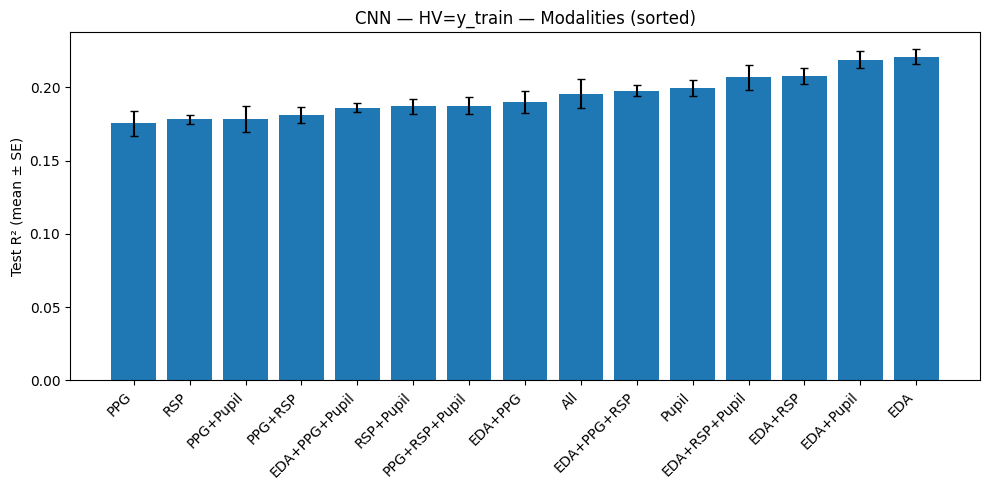

In [5]:
# -*- coding: utf-8 -*-
"""
modal_compare_cnn_ytrain_prefix_exclusive.py

빠른 실험 전용 (CNN):
- HV = y_train 고정 (q=0.25 기본)
- best_params는 summary_y_train.json에서 읽되, GRU일 경우 CNN 기본값으로 폴백
- 모달리티: 접두어 기반(prefix) + 배타적(exclusive) 매핑으로 겹침 제거
- 유니모달 / 2-way / 3-way / All 조합
- seed/epoch 축소로 빠른 테스트

필요 파일:
  - ml_processed_raw/{X_array.npy, y_array.npy, pid_array.npy, scene_array.npy, windex_array.npy, feature_tag_list.npy}
  - results_planA_fixed_test/summary_y_train.json  (best_params 참조; 없으면 CNN 기본값)
  - results_planA_fixed_test/split_fixed_test.json (없으면 자동 생성)

의존:
  - ml_pipeline.py: train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
                 make_participant_disjoint_masks, center_from_train_split
"""

import os, json, itertools, datetime, re
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from ml_pipeline import train_and_evaluate_seeds, summarize_test_results
from ml_utils import (
    set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, center_from_train_split
)

# ----------------------- Config -----------------------
DATA_DIR   = "ml_processed_raw"
OUT_DIR    = "results_planA_fixed_test"        # summary_y_train.json 위치
RESULT_DIR = os.path.join(OUT_DIR, "modal_results_cnn_ytrain")
os.makedirs(RESULT_DIR, exist_ok=True)

SEEDS     = 5    # 빠른 테스트용 (필요시 10/20)
EPOCHS    = 30   # 빠른 테스트용 (필요시 50)
PATIENCE  = 5
MIN_DELTA = 1e-3

# CNN 기본 파라미터 (summary_y_train.json이 GRU일 수 있으므로 안전 기본값)
CNN_BASE = dict(num_filters=32, kernel_size=5, dropout=0.3, batch_size=32, learning_rate=1e-3)

# ===== 새 규칙: 접두어 기반 + 배타적 매핑 =====
#  - RSA 아님! 데이터는 RSP_* (호흡)
PREFIX_RULES = {
    "EDA":   ("EDA_", "SCR_"),   # SCR_*도 EDA에 포함
    "PPG":   ("PPG_",),
    "RSP":   ("RSP_",),
    "Pupil": ("pupil",),         # pupilL, pupilR, pupil_mean...
}
# 겹칠 경우 우선순위(첫 매칭에만 배정)
PRIORITY = ["PPG", "EDA", "RSP", "Pupil"]
# ------------------------------------------------------


def load_summary_best_params(path_json):
    if not os.path.exists(path_json):
        return dict(CNN_BASE)
    with open(path_json, "r", encoding="utf-8") as f:
        s = json.load(f)
    bp = dict(s.get("best_params", {}))
    # GRU 저장본일 수 있음 → CNN에 맞게 보정
    keys_needed_cnn = {"num_filters","kernel_size","dropout","batch_size","learning_rate"}
    if not keys_needed_cnn.issubset(bp.keys()):
        bp = dict(CNN_BASE)  # fallback
    return bp


def build_modality_index_map_prefix(feature_tags, priority=("PPG","EDA","RSP","Pupil")):
    """
    접두어(prefix) 기반 + 배타적(exclusive) 매핑
    tag가 여러 그룹에 매칭되더라도 'priority' 순서에서 첫 그룹에만 할당
    """
    idx_map = {k: [] for k in PREFIX_RULES.keys()}
    for i, tag in enumerate(feature_tags):
        t = str(tag)
        matched = []
        for modal, prefixes in PREFIX_RULES.items():
            if any(t.startswith(p) for p in prefixes):
                matched.append(modal)
        if not matched:
            continue
        for m in priority:
            if m in matched:
                idx_map[m].append(i)
                break
    return idx_map


def report_overlap(idx_map, expect_counts=None, assert_disjoint=True):
    """
    커버리지와 쌍별 교집합을 리포트.
    기대 개수(expect_counts)가 주어지면 검증.
    assert_disjoint=True이면 쌍별 교집합이 0이 아닐 시 AssertionError.
    """
    names = list(idx_map.keys())
    sets  = {k: set(v) for k, v in idx_map.items()}

    print("=== Modality coverage ===")
    for n in names:
        print(f" - {n}: {len(sets[n])} channels")

    print("=== Pairwise overlaps (count / Jaccard) ===")
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            a, b = sets[names[i]], sets[names[j]]
            inter = len(a & b)
            union = len(a | b) if (a or b) else 1
            jac = inter / union
            print(f" {names[i]} ∩ {names[j]}: {inter} / {jac:.3f}")
            if assert_disjoint:
                assert inter == 0, f"Overlap detected: {names[i]} vs {names[j]} = {inter}"

    if expect_counts:
        for n, exp in expect_counts.items():
            got = len(sets[n])
            assert got == exp, f"{n} count mismatch: got {got}, expect {exp}"


def combos_from_groups(idx_map):
    """
    유니모달 + 모든 2‑way/3‑way + 멀티모달(all)
    (인덱스 집합이 동일하면 중복 제거)
    """
    names = list(idx_map.keys())
    sets  = [set(idx_map[n]) for n in names]
    results = []

    # 유니모달
    for n, s in zip(names, sets):
        if len(s) > 0:
            results.append( (n, sorted(list(s))) )

    # 2-way, 3-way
    for r in [2, 3]:
        for combo in itertools.combinations(range(len(names)), r):
            nm = "+".join([names[i] for i in combo])
            s  = set().union(*[sets[i] for i in combo])
            if len(s) > 0:
                results.append( (nm, sorted(list(s))) )

    # All
    all_set = set().union(*sets)
    if len(all_set) > 0:
        results.append( ("All", sorted(list(all_set))) )

    # 중복 제거 (이름 달라도 인덱스 동일 시 제거)
    seen = set()
    uniq = []
    for nm, idxs in results:
        key = tuple(idxs)
        if key not in seen:
            seen.add(key)
            uniq.append((nm, idxs))
    return uniq


def hv_mask_from_train_y(y_all, pid_all, scene_all, train_mask, q=0.25):
    """
    Train split에서 (pid, scene) 평균 기준 절대편차의 q-분위수를 스레시홀드로 사용
    → 그 이상인 샘플만 keep (고분산 y 기준 마스킹)
    """
    y_all = y_all.astype(np.float32)
    y_tr  = y_all[train_mask]
    p_tr  = pid_all[train_mask]
    s_tr  = scene_all[train_mask]

    # (pid, scene) 평균 및 백업 평균
    ps_mean = {}
    keys = np.stack([p_tr, s_tr], 1)
    for (p, sc) in np.unique(keys, axis=0):
        m = (p_tr==p) & (s_tr==sc)
        ps_mean[(p,sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    pid_mean = {p: float(y_tr[p_tr==p].mean()) for p in np.unique(p_tr)}
    gmean = float(y_tr.mean()) if len(y_tr) else 0.0

    def mu(p, sc):
        v = ps_mean.get((p,sc))
        if v is None or np.isnan(v):
            v = pid_mean.get(p, gmean)
            if v is None or np.isnan(v):
                v = gmean
        return v

    abs_dev_tr  = np.abs(y_tr - np.array([mu(p, s) for p, s in zip(p_tr, s_tr)], np.float32))
    thr = float(np.quantile(abs_dev_tr, q)) if len(abs_dev_tr) else 0.0
    abs_dev_all = np.abs(y_all - np.array([mu(p, s) for p, s in zip(pid_all, scene_all)], np.float32))
    keep_all = abs_dev_all >= thr
    return keep_all


def main():
    set_reproducible()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- Load data -----
    X = np.load(f"{DATA_DIR}/X_array.npy")
    y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
    pid = np.load(f"{DATA_DIR}/pid_array.npy")
    scene = np.load(f"{DATA_DIR}/scene_array.npy")
    widx = np.load(f"{DATA_DIR}/windex_array.npy")
    feature_tags = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

    # 표준화된 형태로 고정 (N,T,C)
    X = to_NTC_strict(X, feature_tags)  # 내부에서 (N,C,T) 감지 시 전치
    N,T,C = X.shape

    # ----- Fixed test cohort (persist / reuse) -----
    split_json = os.path.join(OUT_DIR, "split_fixed_test.json")
    if os.path.exists(split_json):
        with open(split_json, "r", encoding="utf-8") as f:
            meta = json.load(f)
        test_pid_list = meta["test_pids"]
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=meta.get("val_ratio", 0.20), seed=meta.get("seed", 42)
        )
    else:
        test_pid_list = sample_or_load_fixed_test_pids(pid, manual_list=None, k=10, save_path=split_json, seed=42)
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=0.20, seed=42
        )

    TR = np.where(train_m)[0]; VA = np.where(val_m)[0]; TE = np.where(test_m)[0]
    X_tr_raw, y_tr_raw, pid_tr, scene_tr = X[TR], y[TR], pid[TR], scene[TR]
    X_va_raw, y_va_raw, pid_va, scene_va = X[VA], y[VA], pid[VA], scene[VA]
    X_te_raw, y_te_raw, pid_te, scene_te = X[TE], y[TE], pid[TE], scene[TE]

    # ----- HV = y_train -----
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=0.25)
    kTR = keep_all[TR]; kVA = keep_all[VA]; kTE = keep_all[TE]
    Xtr, ytr, pidtr, scenetr = X_tr_raw[kTR], y_tr_raw[kTR], pid_tr[kTR], scene_tr[kTR]
    Xva, yva, pidva, scenva = X_va_raw[kVA], y_va_raw[kVA], pid_va[kVA], scene_va[kVA]
    Xte, yte, pidte, scenete = X_te_raw[kTE], y_te_raw[kTE], pid_te[kTE], scene_te[kTE]

    # ----- Train-only centering -----
    center_fn, _ = center_from_train_split(ytr, pidtr, scenetr)
    ytr_c = center_fn(ytr, pidtr, scenetr)
    yva_c = center_fn(yva, pidva, scenva)
    yte_c = center_fn(yte, pidte, scenete)

    # ----- Modality channel indices (prefix + exclusive) -----
    idx_map = build_modality_index_map_prefix(feature_tags, priority=PRIORITY)

    # 디버그: 커버리지/교집합/기대 개수 검증
    # 기대 개수는 현재 feature_tag_list 기준 (EDA 28, PPG 7, RSP 21, Pupil 21)
    report_overlap(
        idx_map,
        expect_counts={"EDA":28, "PPG":7, "RSP":21, "Pupil":21},
        assert_disjoint=True
    )

    # 조합 생성
    modal_sets = combos_from_groups(idx_map)
    if not modal_sets:
        raise RuntimeError("No modality indices matched. Check PREFIX_RULES against feature_tag_list.")

    # ----- Load best_params (fallback to CNN_BASE if GRU) -----
    best_json = os.path.join(OUT_DIR, "summary_y_train.json")
    base_params = load_summary_best_params(best_json)  # CNN 키만 보장
    p_template = dict(CNN_BASE)
    p_template.update({k: base_params.get(k, v) for k, v in CNN_BASE.items()})

    # ----- Run per modality subset -----
    rows = []
    for name, idxs in modal_sets:
        if len(idxs) == 0:
            continue

        # slice channels
        Xtr_s = Xtr[:, :, idxs]; Xva_s = Xva[:, :, idxs]; Xte_s = Xte[:, :, idxs]
        inC = Xtr_s.shape[-1]

        # params
        p = dict(p_template)
        p["input_channels"] = inC  # ✅ CNN 전용 채널 수 지정

        # train on (train+val)
        X_trv = np.concatenate([Xtr_s, Xva_s], 0)
        y_trv = np.concatenate([ytr_c, yva_c], 0)
        pid_trv = np.concatenate([pidtr, pidva], 0)

        # 학습/평가
        train_losses, val_losses, test_scores = train_and_evaluate_seeds(
            X_trv, y_trv, pid_trv,
            Xte_s, yte_c,
            model_type="CNN",
            best_params=p,
            device=device,
            num_seeds=SEEDS,
            num_epochs=EPOCHS,
            patience=PATIENCE,
            min_delta=MIN_DELTA
        )

        # summarize + 수집
        summarize_test_results(test_scores)
        r2s   = [s[0] for s in test_scores]
        rmses = [s[1] for s in test_scores]
        maes  = [s[2] for s in test_scores]
        rows.append({
            "modality": name,
            "n_channels": inC,
            "seeds": SEEDS,
            "R2_mean": float(np.mean(r2s)),
            "R2_se":   float(np.std(r2s, ddof=1)/np.sqrt(len(r2s))) if len(r2s)>1 else 0.0,
            "RMSE_mean": float(np.mean(rmses)),
            "RMSE_se":   float(np.std(rmses, ddof=1)/np.sqrt(len(rmses))) if len(rmses)>1 else 0.0,
            "MAE_mean": float(np.mean(maes)),
            "MAE_se":   float(np.std(maes, ddof=1)/np.sqrt(len(maes))) if len(maes)>1 else 0.0,
            # 디버깅 편의를 위한 해시(동일 조합 검증)
            "chan_hash": hash(tuple(idxs)),
        })

    # ----- Save CSV -----
    df = pd.DataFrame(rows)
    # (참고) 기존 코드가 오름차순 정렬을 사용했음 → 유지
    df = df.sort_values(by="R2_mean", ascending=True)
    csv_path = os.path.join(RESULT_DIR, "modal_results_cnn_ytrain.csv")
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[SAVE] {csv_path}")

    # ----- Plot (sorted) -----
    plt.figure(figsize=(10,5))
    x = np.arange(len(df))
    plt.bar(x, df["R2_mean"], yerr=df["R2_se"], capsize=3)
    plt.xticks(x, df["modality"], rotation=45, ha="right")
    plt.ylabel("Test R² (mean ± SE)")
    plt.title("CNN — HV=y_train — Modalities (sorted)")
    plt.tight_layout()
    fig_path = os.path.join(RESULT_DIR, "modal_results_cnn_ytrain_sorted.png")
    plt.savefig(fig_path, dpi=200)
    print(f"[SAVE] {fig_path}")

    return df   # main()에서 df 반환


if __name__ == "__main__":
    result_df = main()


NameError: name 'feature_tag_list' is not defined

=== Modality coverage ===
 - EDA: 28 channels
 - PPG: 7 channels
 - RSP: 21 channels
 - Pupil: 21 channels
=== Pairwise overlaps (count / Jaccard) ===
 EDA ∩ PPG: 0 / 0.000
 EDA ∩ RSP: 0 / 0.000
 EDA ∩ Pupil: 0 / 0.000
 PPG ∩ RSP: 0 / 0.000
 PPG ∩ Pupil: 0 / 0.000
 RSP ∩ Pupil: 0 / 0.000

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (6751, 150, 28), y_train shape: (6751,)
⏹️ Early stopping at epoch 10 (best @ 5, val=0.905403)
Saved predictions to lstm_test_predictions_seed0.npz
📊 Test R²: 0.2252 | RMSE: 1.0123 | MAE: 0.7919  → saved to lstm_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (6653, 150, 28), y_train shape: (6653,)
⏹️ Early stopping at epoch 13 (best @ 8, val=0.742669)
Saved predictions to lstm_test_predictions_seed1.npz
📊 Test R²: 0.2211 | RMSE: 1.0150 | MAE: 0.7831  → saved to lstm_test_predictions_seed1.npz

🟢 SEED 2 시작

🎯 create_dataloaders X_train shape: (6331, 150, 28), y_train shape: (6331,)
⏹️ Early stopping at epoch 13 (best @ 8, va

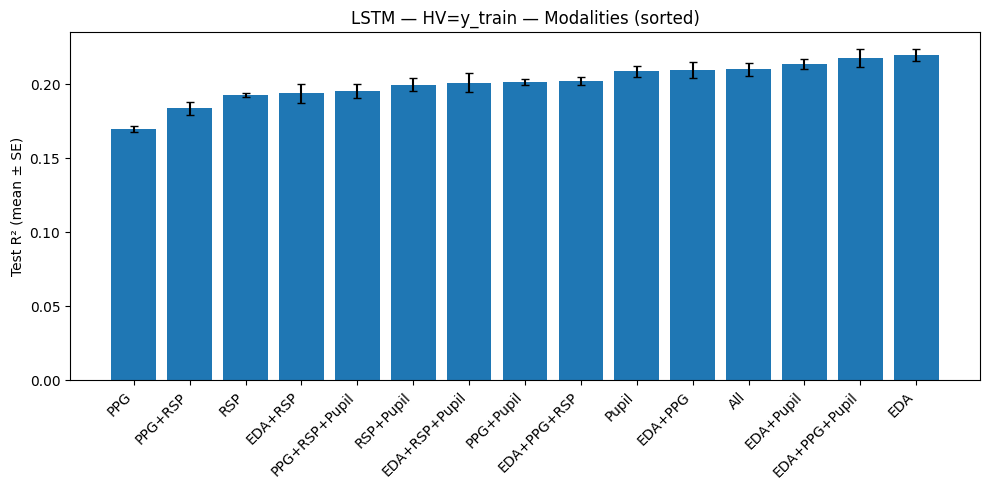

In [6]:
# -*- coding: utf-8 -*-
"""
modal_compare_lstm_ytrain_prefix_exclusive.py

빠른 실험 전용 (LSTM):
- HV = y_train 고정 (q=0.25 기본)
- best_params는 summary_y_train.json에서 읽되, CNN/GRU일 경우 LSTM 기본값으로 폴백
- 모달리티: 접두어 기반(prefix) + 배타적(exclusive) 매핑으로 겹침 제거
- 유니모달 / 2-way / 3-way / All 조합
- seed/epoch 축소로 빠른 테스트

필요 파일:
  - ml_processed_raw/{X_array.npy, y_array.npy, pid_array.npy, scene_array.npy, windex_array.npy, feature_tag_list.npy}
  - results_planA_fixed_test_LSTM/summary_y_train.json  (best_params 참조; 없으면 LSTM 기본값)
  - results_planA_fixed_test_LSTM/split_fixed_test.json (없으면 자동 생성)

의존:
  - ml_pipeline.py: train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
                 make_participant_disjoint_masks, center_from_train_split
"""

import os, json, itertools
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from ml_pipeline import train_and_evaluate_seeds, summarize_test_results
from ml_utils import (
    set_reproducible, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, center_from_train_split
)

# ----------------------- Config -----------------------
DATA_DIR   = "ml_processed_raw"
OUT_DIR    = "results_planA_fixed_test_LSTM"
RESULT_DIR = os.path.join(OUT_DIR, "modal_results_lstm_ytrain")
os.makedirs(RESULT_DIR, exist_ok=True)

SEEDS     = 5     # 빠른 테스트용 (필요시 10/20)
EPOCHS    = 30    # 빠른 테스트용 (필요시 50)
PATIENCE  = 5
MIN_DELTA = 1e-3

# LSTM 기본 파라미터 (summary_y_train.json이 CNN/GRU일 수 있으므로 안전 기본값)
LSTM_BASE = dict(hidden_size=64, num_layers=1, dropout=0.3, batch_size=32, learning_rate=1e-3)

# ===== 새 규칙: 접두어 기반 + 배타적 매핑 =====
#  - RSA 아님! 데이터는 RSP_* (호흡)
PREFIX_RULES = {
    "EDA":   ("EDA_", "SCR_"),   # SCR_*도 EDA에 포함
    "PPG":   ("PPG_",),
    "RSP":   ("RSP_",),
    "Pupil": ("pupil",),         # pupilL, pupilR, pupil_mean...
}
# 겹칠 경우 우선순위(첫 매칭에만 배정)
PRIORITY = ["PPG", "EDA", "RSP", "Pupil"]
# ------------------------------------------------------


def load_summary_best_params(path_json):
    if not os.path.exists(path_json):
        return dict(LSTM_BASE)
    with open(path_json, "r", encoding="utf-8") as f:
        s = json.load(f)
    bp = dict(s.get("best_params", {}))
    # CNN/GRU 저장본일 수 있음 → LSTM에 맞게 보정
    keys_needed_lstm = {"hidden_size","num_layers","dropout","batch_size","learning_rate"}
    if not keys_needed_lstm.issubset(bp.keys()):
        bp = dict(LSTM_BASE)  # fallback
    return bp


def build_modality_index_map_prefix(feature_tags, priority=("PPG","EDA","RSP","Pupil")):
    """
    접두어(prefix) 기반 + 배타적(exclusive) 매핑
    tag가 여러 그룹에 매칭되더라도 'priority' 순서에서 첫 그룹에만 할당
    """
    idx_map = {k: [] for k in PREFIX_RULES.keys()}
    for i, tag in enumerate(feature_tags):
        t = str(tag)
        matched = []
        for modal, prefixes in PREFIX_RULES.items():
            if any(t.startswith(p) for p in prefixes):
                matched.append(modal)
        if not matched:
            continue
        for m in priority:
            if m in matched:
                idx_map[m].append(i)
                break
    return idx_map


def report_overlap(idx_map, expect_counts=None, assert_disjoint=True):
    """
    커버리지와 쌍별 교집합을 리포트.
    기대 개수(expect_counts)가 주어지면 검증.
    assert_disjoint=True이면 쌍별 교집합이 0이 아닐 시 AssertionError.
    """
    names = list(idx_map.keys())
    sets  = {k: set(v) for k, v in idx_map.items()}

    print("=== Modality coverage ===")
    for n in names:
        print(f" - {n}: {len(sets[n])} channels")

    print("=== Pairwise overlaps (count / Jaccard) ===")
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            a, b = sets[names[i]], sets[names[j]]
            inter = len(a & b)
            union = len(a | b) if (a or b) else 1
            jac = inter / union
            print(f" {names[i]} ∩ {names[j]}: {inter} / {jac:.3f}")
            if assert_disjoint:
                assert inter == 0, f"Overlap detected: {names[i]} vs {names[j]} = {inter}"

    if expect_counts:
        for n, exp in expect_counts.items():
            got = len(sets[n])
            assert got == exp, f"{n} count mismatch: got {got}, expect {exp}"


def combos_from_groups(idx_map):
    """
    유니모달 + 모든 2‑way/3‑way + 멀티모달(all)
    (인덱스 집합이 동일하면 중복 제거)
    """
    names = list(idx_map.keys())
    sets  = [set(idx_map[n]) for n in names]
    results = []

    # 유니모달
    for n, s in zip(names, sets):
        if len(s) > 0:
            results.append( (n, sorted(list(s))) )

    # 2-way, 3-way
    for r in [2, 3]:
        for combo in itertools.combinations(range(len(names)), r):
            nm = "+".join([names[i] for i in combo])
            s  = set().union(*[sets[i] for i in combo])
            if len(s) > 0:
                results.append( (nm, sorted(list(s))) )

    # All
    all_set = set().union(*sets)
    if len(all_set) > 0:
        results.append( ("All", sorted(list(all_set))) )

    # 중복 제거 (이름 달라도 인덱스 동일 시 제거)
    seen = set()
    uniq = []
    for nm, idxs in results:
        key = tuple(idxs)
        if key not in seen:
            seen.add(key)
            uniq.append((nm, idxs))
    return uniq


def hv_mask_from_train_y(y_all, pid_all, scene_all, train_mask, q=0.25):
    """
    Train split에서 (pid, scene) 평균 기준 절대편차의 q-분위수를 스레시홀드로 사용
    → 그 이상인 샘플만 keep (고분산 y 기준 마스킹)
    """
    y_all = y_all.astype(np.float32)
    y_tr  = y_all[train_mask]
    p_tr  = pid_all[train_mask]
    s_tr  = scene_all[train_mask]

    # (pid, scene) 평균 및 백업 평균
    ps_mean = {}
    keys = np.stack([p_tr, s_tr], 1)
    for (p, sc) in np.unique(keys, axis=0):
        m = (p_tr==p) & (s_tr==sc)
        ps_mean[(p,sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    pid_mean = {p: float(y_tr[p_tr==p].mean()) for p in np.unique(p_tr)}
    gmean = float(y_tr.mean()) if len(y_tr) else 0.0

    def mu(p, sc):
        v = ps_mean.get((p,sc))
        if v is None or np.isnan(v):
            v = pid_mean.get(p, gmean)
            if v is None or np.isnan(v):
                v = gmean
        return v

    abs_dev_tr  = np.abs(y_tr - np.array([mu(p, s) for p, s in zip(p_tr, s_tr)], np.float32))
    thr = float(np.quantile(abs_dev_tr, q)) if len(abs_dev_tr) else 0.0
    abs_dev_all = np.abs(y_all - np.array([mu(p, s) for p, s in zip(pid_all, scene_all)], np.float32))
    keep_all = abs_dev_all >= thr
    return keep_all


def main():
    set_reproducible()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- Load data -----
    X = np.load(f"{DATA_DIR}/X_array.npy")
    y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
    pid = np.load(f"{DATA_DIR}/pid_array.npy")
    scene = np.load(f"{DATA_DIR}/scene_array.npy")
    widx = np.load(f"{DATA_DIR}/windex_array.npy")
    feature_tags = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

    # 표준화된 형태로 고정 (N,T,C)
    X = to_NTC_strict(X, feature_tags)  # 내부에서 (N,C,T) 감지 시 전치
    N,T,C = X.shape

    # ----- Fixed test cohort (persist / reuse) -----
    split_json = os.path.join(OUT_DIR, "split_fixed_test.json")
    if os.path.exists(split_json):
        with open(split_json, "r", encoding="utf-8") as f:
            meta = json.load(f)
        test_pid_list = meta["test_pids"]
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=meta.get("val_ratio", 0.20), seed=meta.get("seed", 42)
        )
    else:
        test_pid_list = sample_or_load_fixed_test_pids(pid, manual_list=None, k=10, save_path=split_json, seed=42)
        train_m, val_m, test_m, train_pids, val_pids = make_participant_disjoint_masks(
            pid, test_pid_list, val_ratio=0.20, seed=42
        )

    TR = np.where(train_m)[0]; VA = np.where(val_m)[0]; TE = np.where(test_m)[0]
    X_tr_raw, y_tr_raw, pid_tr, scene_tr = X[TR], y[TR], pid[TR], scene[TR]
    X_va_raw, y_va_raw, pid_va, scene_va = X[VA], y[VA], pid[VA], scene[VA]
    X_te_raw, y_te_raw, pid_te, scene_te = X[TE], y[TE], pid[TE], scene[TE]

    # ----- HV = y_train -----
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=0.25)
    kTR = keep_all[TR]; kVA = keep_all[VA]; kTE = keep_all[TE]
    Xtr, ytr, pidtr, scenetr = X_tr_raw[kTR], y_tr_raw[kTR], pid_tr[kTR], scene_tr[kTR]
    Xva, yva, pidva, scenva = X_va_raw[kVA], y_va_raw[kVA], pid_va[kVA], scene_va[kVA]
    Xte, yte, pidte, scenete = X_te_raw[kTE], y_te_raw[kTE], pid_te[kTE], scene_te[kTE]

    # ----- Train-only centering -----
    center_fn, _ = center_from_train_split(ytr, pidtr, scenetr)
    ytr_c = center_fn(ytr, pidtr, scenetr)
    yva_c = center_fn(yva, pidva, scenva)
    yte_c = center_fn(yte, pidte, scenete)

    # ----- Modality channel indices (prefix + exclusive) -----
    idx_map = build_modality_index_map_prefix(feature_tags, priority=PRIORITY)

    # 디버그: 커버리지/교집합/기대 개수 검증
    # 기대 개수는 현재 feature_tag_list 기준 (EDA 28, PPG 7, RSP 21, Pupil 21)
    report_overlap(
        idx_map,
        expect_counts={"EDA":28, "PPG":7, "RSP":21, "Pupil":21},
        assert_disjoint=True
    )

    # 조합 생성
    modal_sets = combos_from_groups(idx_map)
    if not modal_sets:
        raise RuntimeError("No modality indices matched. Check PREFIX_RULES against feature_tag_list.")

    # ----- Load best_params (fallback to LSTM_BASE if not LSTM) -----
    best_json = os.path.join(OUT_DIR, "summary_y_train.json")
    base_params = load_summary_best_params(best_json)  # LSTM 키만 보장
    p_template = dict(LSTM_BASE)
    p_template.update({k: base_params.get(k, v) for k, v in LSTM_BASE.items()})

    # ----- Run per modality subset -----
    rows = []
    for name, idxs in modal_sets:
        if len(idxs) == 0:
            continue

        # slice channels
        Xtr_s = Xtr[:, :, idxs]; Xva_s = Xva[:, :, idxs]; Xte_s = Xte[:, :, idxs]
        inC = Xtr_s.shape[-1]

        # params
        p = dict(p_template)
        p["input_size"] = inC  # ✅ LSTM/GRU 공용: 입력 채널 수 지정

        # train on (train+val)
        X_trv = np.concatenate([Xtr_s, Xva_s], 0)
        y_trv = np.concatenate([ytr_c, yva_c], 0)
        pid_trv = np.concatenate([pidtr, pidva], 0)

        # 학습/평가
        train_losses, val_losses, test_scores = train_and_evaluate_seeds(
            X_trv, y_trv, pid_trv,
            Xte_s, yte_c,
            model_type="LSTM",
            best_params=p,
            device=device,
            num_seeds=SEEDS,
            num_epochs=EPOCHS,
            patience=PATIENCE,
            min_delta=MIN_DELTA
        )

        # summarize + 수집
        summarize_test_results(test_scores)
        r2s   = [s[0] for s in test_scores]
        rmses = [s[1] for s in test_scores]
        maes  = [s[2] for s in test_scores]
        rows.append({
            "modality": name,
            "n_channels": inC,
            "seeds": SEEDS,
            "R2_mean": float(np.mean(r2s)),
            "R2_se":   float(np.std(r2s, ddof=1)/np.sqrt(len(r2s))) if len(r2s)>1 else 0.0,
            "RMSE_mean": float(np.mean(rmses)),
            "RMSE_se":   float(np.std(rmses, ddof=1)/np.sqrt(len(rmses))) if len(rmses)>1 else 0.0,
            "MAE_mean": float(np.mean(maes)),
            "MAE_se":   float(np.std(maes, ddof=1)/np.sqrt(len(maes))) if len(maes)>1 else 0.0,
            # 디버깅 편의를 위한 해시(동일 조합 검증)
            "chan_hash": hash(tuple(idxs)),
        })

    # ----- Save CSV -----
    df = pd.DataFrame(rows)
    df = df.sort_values(by="R2_mean", ascending=True)  # 필요시 False로 변경
    csv_path = os.path.join(RESULT_DIR, "modal_results_lstm_ytrain.csv")
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[SAVE] {csv_path}")

    # ----- Plot (sorted) -----
    plt.figure(figsize=(10,5))
    x = np.arange(len(df))
    plt.bar(x, df["R2_mean"], yerr=df["R2_se"], capsize=3)
    plt.xticks(x, df["modality"], rotation=45, ha="right")
    plt.ylabel("Test R² (mean ± SE)")
    plt.title("LSTM — HV=y_train — Modalities (sorted)")
    plt.tight_layout()
    fig_path = os.path.join(RESULT_DIR, "modal_results_lstm_ytrain_sorted.png")
    plt.savefig(fig_path, dpi=200)
    print(f"[SAVE] {fig_path}")

    return df   # main()에서 df 반환


if __name__ == "__main__":
    result_df = main()


## Window 5 stride 2 30hz_Hallway

In [1]:
# -*- coding: utf-8 -*-
# planA_main_gru.py
import os, json
import numpy as np
import torch
from ml_utils import (
    set_reproducible, dbg, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, assert_no_pid_overlap, run_planA_one_mode,
    negative_controls_once
)

seed_master = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "ml_processed_raw"
OUT_DIR  = "results_planA_fixed_test_GRU"
os.makedirs(OUT_DIR, exist_ok=True)

TEST_K = 10
VAL_RATIO = 0.20
RUN_HV_SENSITIVITY = True
HV_MODES = ["none", "x_variance", "y_train"] if RUN_HV_SENSITIVITY else ["none"]
HV_QUANTILE = 0.25

NUM_SEEDS_FINAL = 20
EPOCHS_FINAL = 50

patience_ablation = 10; min_delta_ablation = 1e-6
patience_grid     = 7 ; min_delta_grid     = 1e-5
patience_train    = 7 ; min_delta_train    = 1e-3

model_type = "GRU"
fixed_params_base = {
    "hidden_size": 64, "num_layers": 1, "dropout": 0.3,
    "batch_size": 32, "learning_rate": 1e-3
}
search_space = {
    "hidden_size": [32, 64, 128],
    "num_layers": [1, 2],
    "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [1e-3, 3e-4, 1e-4],
}

set_reproducible()
np.random.seed(seed_master); torch.manual_seed(seed_master)

X = np.load(f"{DATA_DIR}/X_array.npy")
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()
X = to_NTC_strict(X, feature_tag_list)
dbg(f"Normalized to (N,T,C)={X.shape} | C={X.shape[-1]}")

SPLIT_JSON = os.path.join(OUT_DIR, "split_fixed_test.json")
test_pid_list = sample_or_load_fixed_test_pids(pid, manual_list=None, k=TEST_K, save_path=SPLIT_JSON, seed=42)
train_mask, val_mask, test_mask, train_pids, val_pids = make_participant_disjoint_masks(
    pid, test_pid_list, val_ratio=VAL_RATIO, seed=seed_master
)
with open(SPLIT_JSON, "w", encoding="utf-8") as f:
    json.dump({"train_pids": train_pids, "val_pids": val_pids, "test_pids": sorted(test_pid_list),
               "val_ratio": VAL_RATIO, "seed": seed_master}, f, ensure_ascii=False, indent=2)

TR_idx = np.where(train_mask)[0]; VA_idx = np.where(val_mask)[0]; TE_idx = np.where(test_mask)[0]
X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]
assert_no_pid_overlap(pid_train, pid_test); assert_no_pid_overlap(pid_val, pid_test)

last_result = None
for hv in HV_MODES:
    print(f"\n========== HV MODE: {hv} ==========")
    last_result = run_planA_one_mode(
        hv,
        X_train_raw, y_train_raw, pid_train, scene_train,
        X_val_raw,   y_val_raw,   pid_val,   scene_val,
        X_test_raw,  y_test_raw,  pid_test,  scene_test,
        feature_tag_list, OUT_DIR, seed_master, device, model_type,
        RUN_ABLATION=True, ABLATION_EPOCHS=10, RUN_GRID=True, GRID_EPOCHS=20,
        NUM_SEEDS_FINAL=NUM_SEEDS_FINAL, EPOCHS_FINAL=EPOCHS_FINAL,
        patience_ablation=patience_ablation, min_delta_ablation=min_delta_ablation,
        patience_grid=patience_grid,         min_delta_grid=min_delta_grid,
        patience_train=patience_train,       min_delta_train=min_delta_train,
        HV_QUANTILE=HV_QUANTILE, selection_threshold=0.0005,
        fixed_params_base=fixed_params_base, search_space=search_space
    )

if last_result is not None:
    print("\n========== NEGATIVE CONTROLS ==========")
    negative_controls_once(
        last_result["X_trv"], last_result["y_trv"], last_result["pid_trv"],
        last_result["X_te"],  last_result["y_te_c"],
        last_result["best_params"], model_type, device
    )

print("\nDone. See:", OUT_DIR)


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77

========== HV MODE: none ==========
[DBG] [none] kept → train:9188 | val:1840 | test:951
🔍 Masking EDA_Tonic (1/77)
🔍 Masking EDA_Tonic_diff1 (2/77)
🔍 Masking EDA_Tonic_diff2 (3/77)
🔍 Masking EDA_Tonic_ma60 (4/77)
🔍 Masking EDA_Tonic_std150 (5/77)
🔍 Masking EDA_Tonic_slope (6/77)
🔍 Masking EDA_Tonic_iqr (7/77)
🔍 Masking EDA_Phasic (8/77)
🔍 Masking EDA_Phasic_diff1 (9/77)
🔍 Masking EDA_Phasic_diff2 (10/77)
🔍 Masking EDA_Phasic_ma60 (11/77)
🔍 Masking EDA_Phasic_std150 (12/77)
🔍 Masking EDA_Phasic_slope (13/77)
🔍 Masking EDA_Phasic_iqr (14/77)
🔍 Masking SCR_Amplitude (15/77)
🔍 Masking SCR_Amplitude_diff1 (16/77)
🔍 Masking SCR_Amplitude_diff2 (17/77)
🔍 Masking SCR_Amplitude_ma60 (18/77)
🔍 Masking SCR_Amplitude_std150 (19/77)
🔍 Masking SCR_Amplitude_slope (20/77)
🔍 Masking SCR_Amplitude_iqr (21/77)
🔍 Masking SCR_RiseTime (22/77)
🔍 Masking SCR_RiseTime_diff1 (23/77)
🔍 Masking SCR_RiseTime_diff2 (24/77)
🔍 Masking SCR_RiseTime_ma60 (25/77)
🔍

In [4]:
from ml_utils import (
    set_reproducible, dbg, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, assert_no_pid_overlap, run_planA_one_mode,
    negative_controls_once
)

[DBG] Normalized to (N,T,C)=(11979, 150, 77), |features|=77
[DBG] SPLIT ready (GAP=10).
[DBG] HV_MODE=none, keep_ratio=1.000
[DBG] Post-centering: train=(9626, 150, 77), val=(2196, 150, 77), test=(157, 150, 77)
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
🔍 Masking EDA_Tonic (1/77)
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 

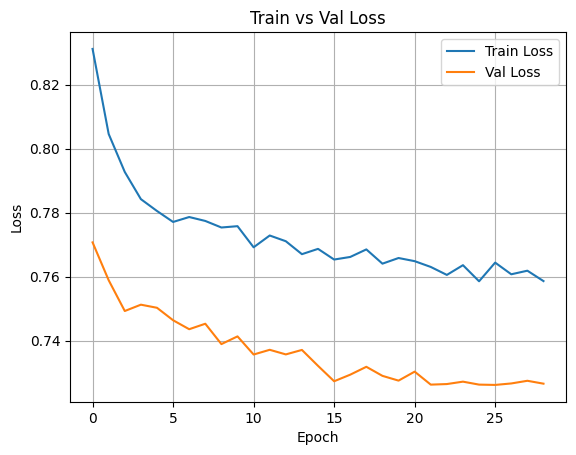


📊 평균 Test R²: 0.3584 ± 0.0131
[META] split_info={'test_pid': '108', 'val_pids': ['103', '034', '085', '045', '036', '073', '006', '033', '082', '012', '020', '001', '043', '048', '014', '096', '050', '029', '091', '068'], 'gap_steps': 10} | lag=DISABLED | format=(N,T,C) | channels=17 | GAP=10 | HV_MODE=none | seed=42


In [ ]:
# -*- coding: utf-8 -*-
# Leakage-safe CNN main (lag OFF / (N,T,C) / publication-ready)
# - Split FIRST (GAP=10), then derive ALL thresholds/statistics from TRAIN ONLY
# - Train-derived HV mask (default: X-variance), Train-only target centering
# - External-val grid (no internal split), seed ensemble (10) for final report
# - Deterministic settings for reproducibility
#
# Requirements:
#   - ml_pipeline.py: run_ablation, select_features_by_ablation, run_grid_search,
#                     train_and_evaluate_seeds, summarize_test_results
#   - ml_utils.py: split_across_with_gap, apply_mask_arrays, plot_train_val_loss,
#                  set_seed, to_loader

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"

import numpy as np
import torch

# Reproducibility / determinism
torch.set_float32_matmul_precision("high")  # set "highest" to disable TF32 if needed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

from ml_pipeline import (
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)

from ml_utils import (
    split_across_with_gap, apply_mask_arrays,
    plot_train_val_loss, set_seed, to_loader
)

# ------------------------------
# utils
# ------------------------------
def dbg(msg): print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    """Ensure X is (N,T,C) by aligning C with len(feature_tags)."""
    assert isinstance(X, np.ndarray) and X.ndim == 3, \
        f"X must be 3D np.ndarray, got {type(X)}, ndim={getattr(X,'ndim',None)}"
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T)
        return np.transpose(X, (0, 2, 1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous: both middle and last dims equal |features|={L}. Check how X was saved.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}. Verify axes and feature_tag_list.")

def hv_mask_from_train_x(X_all, train_mask, q=0.30):
    """
    Train-derived HV mask (input-based, safer):
    - Per-sample std over all time*channels
    - Threshold: train q-quantile; apply unchanged to all splits
    """
    X_all = np.asarray(X_all, dtype=np.float32)
    X_flat = X_all.reshape(X_all.shape[0], -1)
    std_all = X_flat.std(axis=1)
    thr = float(np.quantile(std_all[train_mask], q)) if np.any(train_mask) else 0.0
    keep_all = std_all >= thr
    return keep_all

def hv_mask_from_train_y(y_all, pid_all, scene_all, train_mask, q=0.30):
    """
    Train-derived HV mask (target-based; leakage-safe since computed on TRAIN ONLY):
    - abs deviation from (pid,scene) means on TRAIN; train q-quantile → threshold
    - apply unchanged to all splits
    """
    y_all = y_all.astype(np.float32); p_all = pid_all; s_all = scene_all
    y_tr = y_all[train_mask]; p_tr = p_all[train_mask]; s_tr = s_all[train_mask]
    # (pid,scene) means from TRAIN
    ps_mean = {}
    ps_keys = np.stack([p_tr, s_tr], axis=1)
    uniq_ps = np.unique(ps_keys, axis=0)
    for k_pid, k_sc in uniq_ps:
        m = (p_tr == k_pid) & (s_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    # pid means & global
    pid_mean = {}
    for k_pid in np.unique(p_tr):
        m = (p_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    abs_dev_tr = np.abs(y_tr - np.array([_mu(p, s) for p, s in zip(p_tr, s_tr)], dtype=np.float32))
    thr = float(np.quantile(abs_dev_tr, q)) if len(abs_dev_tr) else 0.0

    abs_dev_all = np.abs(y_all - np.array([_mu(p, s) for p, s in zip(p_all, s_all)], dtype=np.float32))
    keep_all = abs_dev_all >= thr
    return keep_all

def center_from_train_split(y_tr, pid_tr, scene_tr):
    """
    Build centerer using TRAIN ONLY with hierarchical fallback:
    (pid,scene) -> pid -> global
    Returns a function: center(y, pid, scene) -> y_centered
    """
    y_tr = y_tr.astype(np.float32)
    # (pid,scene) mean
    ps_mean = {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    # pid mean
    pid_mean = {}
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        y = y.astype(np.float32)
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y - mu

    return center_fn, {"global_mean": global_mean}

def apply_per_split_mask(X, y, pid, scene, widx, train_m, val_m, test_m, keep_all):
    """Intersect split masks with keep_all and return split tuples."""
    tr_idx = np.where(train_m & keep_all)[0]
    va_idx = np.where(val_m & keep_all)[0]
    te_idx = np.where(test_m & keep_all)[0]
    return (X[tr_idx], y[tr_idx], pid[tr_idx], scene[tr_idx], widx[tr_idx]), \
           (X[va_idx], y[va_idx], pid[va_idx], scene[va_idx], widx[va_idx]), \
           (X[te_idx], y[te_idx], pid[te_idx], scene[te_idx], widx[te_idx])

def assert_no_pid_overlap(pid_train, pid_test):
    dup = set(pid_train.tolist()).intersection(set(pid_test.tolist()))
    assert len(dup) == 0, f"PID overlap detected between train and test: {sorted(list(dup))[:10]}"

# ------------------------------
# 1) Config
# ------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"

set_seed(seed)

# Split / masking policy
VAL_RATIO   = 0.2
GAP_STEPS   = 10          # publication-ready
HV_MODE     = "none"  # {"x_variance","y_train","none"}
HV_QUANTILE = 0.25
SEED_MASTER = 42               # (기존 값 유지 가능)
SEED_SET = [SEED_MASTER + i for i in range(NUM_SEEDS_FINAL)]  # across/within 공통 seed

# Ablation / Grid toggles
RUN_ABLATION     = True
ABLATION_EPOCHS  = 10
RUN_GRID         = True
GRID_EPOCHS      = 20

# Final train
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL     = 50
patience_ablation = 10
min_delta_ablation = 1e-6
patience_grid = 7
min_delta_grid = 1e-5
patience_train = 7
min_delta_train = 1e-3
USE_ACROSS_FINAL_CKPTS = True

# Option B(엄밀): finetune 앞 50% 내부에서 다시 train/val 분할 → 얼리스탑은 내부 val만 사용
FINETUNE_VAL_FRACTION = 0.20   # 앞 50% 중 20%를 내부 val
FINETUNE_EPOCHS = 8
FINETUNE_PATIENCE = 3

HEAD_NAMES_PER_MODEL = {
    "CNN":      ["head", "fc", "out", "regressor"],
    "GRU":      ["head", "fc", "out", "regressor"],
    "GRU_Attn": ["head", "fc", "out", "regressor", "proj"],
    "LSTM":     ["head", "fc", "out", "regressor"],
}
# ------------------------------
# 2) Load + (N,T,C) normalize
# ------------------------------
path = "ml_processed_raw"
X = np.load(f"{path}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{path}/y_array.npy").astype(np.float32)
pid = np.load(f"{path}/pid_array.npy")
scene = np.load(f"{path}/scene_array.npy")
widx = np.load(f"{path}/windex_array.npy")
feature_tag_list = np.load(f"{path}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}, |features|={len(feature_tag_list)}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"

# ------------------------------
# 3) Split FIRST (GAP=10), then derive HV from TRAIN ONLY
# ------------------------------
train_m, val_m, test_m, split_info = split_across_with_gap(
    pid, scene, widx, val_ratio=VAL_RATIO, gap_steps=GAP_STEPS, seed=seed
)
dbg(f"SPLIT ready (GAP={GAP_STEPS}).")

if HV_MODE == "none":
    keep_all = np.ones_like(y, dtype=bool)
elif HV_MODE == "x_variance":
    keep_all = hv_mask_from_train_x(X, train_m, q=HV_QUANTILE)
else:  # "y_train"
    keep_all = hv_mask_from_train_y(y, pid, scene, train_m, q=HV_QUANTILE)
dbg(f"HV_MODE={HV_MODE}, keep_ratio={keep_all.mean():.3f}")

# Apply split ∩ HV mask
(TR, VA, TE) = apply_per_split_mask(X, y, pid, scene, widx, train_m, val_m, test_m, keep_all)
X_train_raw, y_train_raw, pid_train, scene_train, _ = TR
X_val_raw,   y_val_raw,   pid_val,   scene_val,   _ = VA
X_test_raw,  y_test_raw,  pid_test,  scene_test,  _ = TE

# Safety: participant disjointness
assert_no_pid_overlap(pid_train, pid_test)

# ------------------------------
# 4) Train-only target centering (after HV)
# ------------------------------
center_fn, _stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_train = center_fn(y_train_raw, pid_train, scene_train)
y_val   = center_fn(y_val_raw,   pid_val,   scene_val)
y_test  = center_fn(y_test_raw,  pid_test,  scene_test)

X_train, X_val, X_test = X_train_raw, X_val_raw, X_test_raw
dbg(f"Post-centering: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

# ------------------------------
# 5) Ablation (mask-based; leakage-safe)
# ------------------------------
fixed_params = {
    "num_filters": 64,
    "kernel_size": 5,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "input_channels": X_train.shape[-1],  # CNN 필수
}

if RUN_ABLATION:
    df_ablation = run_ablation(
        X_train, y_train, pid_train,
        X_val,   y_val,   pid_val,
        feature_tag_list,
        model_type=model_type,
        fixed_params=fixed_params,
        seed=seed,
        num_epochs=ABLATION_EPOCHS,
        save_path="ablation_result_cnn.csv",
        patience=patience_ablation,
        min_delta=min_delta_ablation
    )
    keep_features, keep_indices = select_features_by_ablation(
        df_ablation, feature_tag_list, threshold=0.0005
    )
    assert len(keep_indices) > 0, "No features selected by ablation."
else:
    keep_indices = np.arange(X_train.shape[-1]).tolist()
    keep_features = feature_tag_list

# Slice selected channels
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()

new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, new_C={new_C}")
assert len(feature_tag_list) == new_C

# ------------------------------
# 6) Grid Search (external val) or fixed defaults
# ------------------------------
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [1e-3, 3e-4, 1e-4],
}
grid_space = {k: list(v) for k, v in search_space.items()}

# Precheck with a real loader to confirm (N,C,T) layout inside CNN
tmp_loader = to_loader(X_train, y_train, "CNN", batch_size=1, shuffle=False, input_channels=new_C)
xb, _ = next(iter(tmp_loader))
print(f"[GRID-PRECHECK] first batch shape = {tuple(xb.shape)}")  # expect (1, new_C, T)
L_eff = xb.shape[-1]
grid_space["kernel_size"] = [k for k in grid_space["kernel_size"] if k <= L_eff]

dbg(f"[GRID] channels={new_C}, allowed kernel_size={grid_space['kernel_size']}")

if RUN_GRID:
    best_params, _ = run_grid_search(
        X_train, y_train, pid_train,
        model_type=model_type,
        search_space=grid_space,
        seed=seed,
        num_epochs=GRID_EPOCHS,
        patience=patience_grid,
        min_delta=min_delta_grid,
        use_internal_split=False,
        external_val_data=(X_val, y_val)
    )
    best_params = dict(best_params)
else:
    best_params = {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
    }

# Inject CNN-required param
best_params["input_channels"] = new_C
dbg(f"[GRID] best_params={best_params}")

# ------------------------------
# 7) Train on train+val → Test (10 seeds)
# ------------------------------
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

# Safety
assert X_trainval.shape[-1] == X_test.shape[-1] == best_params["input_channels"], \
    f"C mismatch: trainval C={X_trainval.shape[-1]}, test C={X_test.shape[-1]}, param={best_params['input_channels']}"
assert_no_pid_overlap(pid_trainval, pid_test)

train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=NUM_SEEDS_FINAL,
    num_epochs=EPOCHS_FINAL,
    patience=patience_train,
    min_delta=min_delta_train
)

# ------------------------------
# 8) Summaries
# ------------------------------
if len(train_losses) and len(val_losses):
    try:
        plot_train_val_loss(train_losses[0], val_losses[0])
    except Exception as e:
        dbg(f"plot_train_val_loss error: {e}")

summarize_test_results(test_scores)
print(f"[META] split_info={split_info} | lag=DISABLED | format=(N,T,C) | channels={new_C} | GAP={GAP_STEPS} | HV_MODE={HV_MODE} | seed={seed}")

# =====================================================
# (Optional) QUICK CONTROLS — DO NOT USE FOR REPORTING
# =====================================================
RUN_QC_CONTROLS = False
if RUN_QC_CONTROLS:
    def destroy_time_order(X, rng=None):
        rng = np.random.default_rng(2025) if rng is None else rng
        Nn, Tt, Cc = X.shape
        X_out = np.empty_like(X)
        for i in range(Nn):
            perm = rng.permutation(Tt)
            X_out[i] = X[i, perm, :]
        return X_out

    def shift_labels_per_pid(y_, pid_, k=5):
        y_out = y_.copy()
        for p in np.unique(pid_):
            idx = np.where(pid_ == p)[0]
            if len(idx) > 0:
                y_out[idx] = np.roll(y_[idx], k % len(idx))
        return y_out

    # Label shift (structured negative)
    y_trv = y_trainval.copy()
    pid_trv = pid_trainval.copy()
    y_trv_shift = shift_labels_per_pid(y_trv, pid_trv, k=max(1, X_trainval.shape[1]//4))
    print("\n[QC] Label-shift negative control...")
    _, _, scores_neg = train_and_evaluate_seeds(
        X_trainval, y_trv_shift, pid_trainval,
        X_test, y_test,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_neg = float(np.mean([s[0] for s in scores_neg]))
    print(f"[QC] Label-shift R² ≈ {r2_neg:.4f} (≈0 근처가 정상)")

    # Time-order destroyed
    X_trv_perm = destroy_time_order(X_trainval)
    X_te_perm  = destroy_time_order(X_test)
    print("[QC] Time-order destroyed control...")
    _, _, scores_perm = train_and_evaluate_seeds(
        X_trv_perm, y_trainval, pid_trainval,
        X_te_perm,  y_test,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_perm = float(np.mean([s[0] for s in scores_perm]))
    print(f"[QC] Time-order destroyed R² ≈ {r2_perm:.4f} (낮아야 정상)")


In [14]:
# -*- coding: utf-8 -*-
"""
Group-within runner (10-PID pseudo-within 80/10/10)
READ-ONLY: split/ablation/summary/ckpt는 각 모델 OUT_DIR에서 읽음
SAVE: 모든 출력은 group_within_runs/<ts>/<MODEL>/<HV_MODE>/ 아래로

핵심:
- Test PIDs를 10명씩 그룹핑 → 각 PID 시간정렬 후 80/10/10(+gap, tail-crop)으로 분할
- 그룹 train(80%)로 미세조정(ES=val R², 저분산시 MAE 폴백, warm-up)
- PID별 val로 게이팅: 정상분산은 ΔR², 저분산은 ΔMAE 기준 (절대개선 조건)
- (옵션) 개인 affine 보정 y≈a·p+b: 각 PID의 train(80%)로 a,b 산출 → val/test에도 적용
- 작은 데이터: 동적 배치
- 헤드 + 마지막 블록 일부 언프리즈
- AdamW(wd=1e-4) + grad clip(1.0)
- 최상단 RUN_DIR에 overall_summary CSV/JSON 생성
"""

import os, re, glob, json, csv, datetime
from copy import deepcopy
import numpy as np
import pandas as pd
import torch

# ==== Reproducibility / TF32 off ====
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"
torch.set_float32_matmul_precision("highest")
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

# ====== USER CONFIG =========================================================
DATA_DIR = "ml_processed_raw"

# READ-ONLY model dirs
MODEL_RUNS = [
    ("CNN",      "results_planA_fixed_test"),
    ("GRU",      "results_planA_fixed_test_GRU"),
    ("GRU_Attn", "results_planA_fixed_test_GRUAttn"),
    ("LSTM",     "results_planA_fixed_test_LSTM"),
]

# ✅ SAVE root (새 폴더)
GROUP_WITHIN_RESULTS_ROOT = "group_within_runs"

HV_MODES = ["none", "x_variance", "y_train"]
SELECTION_THRESHOLD = 5e-4

# Split & HV
VAL_RATIO = 0.20
SEED_MASTER = 42
HV_QUANTILE = 0.25

# Seeds
NUM_SEEDS_FINAL = 20
SEED_SET = [SEED_MASTER + i for i in range(NUM_SEEDS_FINAL)]

# ==== Group pseudo-within 설정 ====
GROUP_ENABLE: bool = True
GROUP_SIZE: int = 10
GROUP_TR_FRAC: float = 0.80
GROUP_VA_FRAC: float = 0.10
GROUP_GAP_STEPS: int = 3  # val→test 사이 gap

# Within-finetune 공통
FINETUNE_SCOPE: str = "head"  # "head" | "full"
FINETUNE_EPOCHS: int = 24
FINETUNE_PATIENCE: int = 6
FINETUNE_LR: float = 3e-4
SAVE_CHECKPOINTS: bool = True
USE_ACROSS_FINAL_CKPTS: bool = True

# ====== ES & Optimizer knobs ===============================================
MIN_EPOCHS_BEFORE_ES: int = 4
R2_MIN_DELTA: float = 1e-4
LOW_VAR_THR: float = 1e-3       # 저분산 폴백 임계
MAE_MIN_DELTA: float = 1e-4

WD_DEFAULT: float = 1e-4
GRAD_CLIP_NORM: float = 1.0
BIAS_WARMUP_EPOCHS: int = 3

# Gating
GATING_EPS_R2: float = 0.002           # normal-var 기준
GATING_EPS_MAE: float = 1e-4           # low-var 기준(절대 MAE 개선)

# ✅ Test tail crop (끝부분 분포 드리프트 완화)
TE_TAIL_CROP_STEPS: int = 0
TE_TAIL_CROP_SEC: int = 0              # 둘 다>0이면 STEPS 우선
STRIDE_SEC: int = 2

# 개인 affine 보정 on/off
AFFINE_CORRECTION: bool = True
# ===========================================================================

from ml_pipeline import select_features_by_ablation
from ml_utils import set_seed, to_loader, get_model, evaluate

set_seed(SEED_MASTER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dbg(msg: str): print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3
    L = len(feature_tags); N, A, B = X.shape
    if B == L and A != L: return X            # (N,T,C)
    if A == L and B != L: return np.transpose(X, (0, 2, 1))  # (N,C,T)->(N,T,C)
    if A == L and B == L: raise ValueError(f"Ambiguous: X.shape={X.shape}, |features|={L}")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}")

def center_from_train_split(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid); pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0
    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m): m = global_mean
        return m
    def center_fn(y, pid, scene):
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y.astype(np.float32) - mu
    return center_fn, {"global_mean": global_mean}

def hv_mask_from_train_x(X_all, train_mask, q=0.30):
    X_all = np.asarray(X_all, dtype=np.float32)
    X_flat = X_all.reshape(X_all.shape[0], -1)
    std_all = X_flat.std(axis=1)
    thr = float(np.quantile(std_all[train_mask], q)) if np.any(train_mask) else 0.0
    return std_all >= thr

def load_split(OUT_DIR):
    with open(os.path.join(OUT_DIR, "split_fixed_test.json"), "r", encoding="utf-8") as f:
        return json.load(f)

def make_participant_disjoint_masks(pid, test_pid_list, val_ratio=0.20, seed=42):
    all_pids = np.unique(pid).tolist(); test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])
    pid = np.asarray(pid)
    return np.isin(pid, list(train_pids)), np.isin(pid, list(val_pids)), np.isin(pid, list(test_set))

def _seed_worker(seed: int):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

def _set_requires_grad_head_only(model, model_type: str):
    import torch.nn as nn
    names = {
        "CNN": ["head","fc","out","regressor"],
        "GRU": ["head","fc","out","regressor"],
        "GRU_Attn": ["head","fc","out","regressor","proj"],
        "LSTM": ["head","fc","out","regressor"],
    }.get(model_type, ["head","fc","out","regressor"])
    for p in model.parameters(): p.requires_grad = False
    hit = 0
    for name in names:
        if hasattr(model, name):
            for p in getattr(model, name).parameters(): p.requires_grad = True
            hit += 1
    if hit == 0:
        for p in list(model.parameters())[-2:]: p.requires_grad = True
    # last conv for CNN
    last_conv = None
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.Conv2d)): last_conv = m
    if model_type.upper().startswith("CNN") and last_conv is not None:
        for p in last_conv.parameters(): p.requires_grad = True
    # last RNN layer
    max_l = -1
    for name, _ in model.named_parameters():
        m = re.search(r"_l(\d+)", name)
        if m: max_l = max(max_l, int(m.group(1)))
    if max_l >= 0:
        for name, p in model.named_parameters():
            if f"_l{max_l}" in name: p.requires_grad = True

def _save_checkpoint(path, model, meta=None):
    if not SAVE_CHECKPOINTS: return
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({"state_dict": model.state_dict(), "meta": meta or {}}, path)

def _load_checkpoint(path, model, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["state_dict"])
    return ckpt.get("meta", {})

def _make_model(model_type, params, C_eff, device):
    params = dict(params)
    inC = params.get("input_channels", C_eff)
    params["input_channels"] = C_eff
    try:
        return get_model(model_type, C_eff, params).to(device)
    except TypeError:
        return get_model(model_type, params).to(device)

def _collect_val_targets_var(loader, device):
    ys = []
    with torch.no_grad():
        for _, yb in loader: ys.append(yb.view(-1).to(device))
    if not ys: return 0.0
    y = torch.cat(ys).float()
    return float(torch.var(y).item())

def _bias_warmup(model, loader_tr, device, lr, weight_decay=WD_DEFAULT, grad_clip=GRAD_CLIP_NORM, epochs=BIAS_WARMUP_EPOCHS):
    import torch
    from torch import nn
    from torch.optim import AdamW
    from torch.nn.utils import clip_grad_norm_
    criterion = nn.MSELoss(reduction="mean")
    bias_params = [p for n, p in model.named_parameters() if p.requires_grad and ("bias" in n.lower())]
    if not bias_params: return model
    opt = AdamW(bias_params, lr=lr, weight_decay=weight_decay)
    model.train()
    for _ in range(max(1, epochs)):
        for Xb, yb in loader_tr:
            Xb = Xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True).view(-1)
            opt.zero_grad(set_to_none=True)
            pb = model(Xb)
            if pb.dim()==2 and pb.size(-1)==1: pb = pb.squeeze(-1)
            loss = torch.nn.functional.mse_loss(pb.view(-1), yb, reduction="mean")
            loss.backward()
            if grad_clip and grad_clip>0: clip_grad_norm_(bias_params, grad_clip)
            opt.step()
    return model

def _train_model_compat(model, loader_tr, loader_val, device,
                        epochs, patience, model_type,
                        lr=None, weight_decay=WD_DEFAULT, grad_clip=GRAD_CLIP_NORM):
    import numpy as np
    import torch
    from torch import nn
    from torch.optim import AdamW
    from torch.nn.utils import clip_grad_norm_
    from ml_utils import compute_metrics

    LR = float(lr) if lr is not None else 1e-3
    WD = float(weight_decay) if weight_decay is not None else 0.0
    CLIP = float(grad_clip) if grad_clip is not None else 0.0

    model = model.to(device)
    criterion = nn.MSELoss(reduction="mean")
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    # ES metric selection
    es_use_mae = False
    if loader_val is not None:
        val_var = _collect_val_targets_var(loader_val, device)
        es_use_mae = (val_var < LOW_VAR_THR)
        print(f"[ES] {'Low' if es_use_mae else 'Normal'} var on val (var={val_var:.3e}) → ES by {'MAE' if es_use_mae else 'R2'}")

    best_state = None
    best_score = +1e9 if es_use_mae else -1e9
    wait = 0

    def _eval_loader(m, loader):
        m.eval()
        ys, ps, total_loss, total_n = [], [], 0.0, 0
        with torch.no_grad():
            for Xb, yb in loader:
                Xb = Xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True).view(-1)
                pb = m(Xb)
                if pb.dim()==2 and pb.size(-1)==1: pb = pb.squeeze(-1)
                loss = criterion(pb.view(-1), yb)
                bs = yb.size(0); total_loss += loss.item()*bs; total_n += bs
                ys.append(yb.detach().cpu()); ps.append(pb.detach().cpu())
        avg_loss = total_loss / max(1,total_n)
        if not ys: return float("nan"), float("nan"), float("nan"), avg_loss
        y_true = torch.cat(ys).numpy(); y_pred = torch.cat(ps).numpy()
        r2, rmse, mae = compute_metrics(y_true, y_pred)
        return float(r2), float(rmse), float(mae), float(avg_loss)

    for ep in range(1, epochs+1):
        model.train()
        for Xb, yb in loader_tr:
            Xb = Xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True).view(-1)
            optimizer.zero_grad(set_to_none=True)
            pb = model(Xb)
            if pb.dim()==2 and pb.size(-1)==1: pb = pb.squeeze(-1)
            loss = criterion(pb.view(-1), yb)
            loss.backward()
            if CLIP > 0: clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()

        if loader_val is not None:
            val_r2, _, val_mae, _ = _eval_loader(model, loader_val)
            if ep < MIN_EPOCHS_BEFORE_ES:
                cur = -val_mae if es_use_mae else val_r2
                if (not np.isfinite(best_score)) or (cur > best_score):
                    best_score = cur
                    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0; continue

            improved = ((best_score < -val_mae - MAE_MIN_DELTA) if es_use_mae
                        else (val_r2 > best_score + R2_MIN_DELTA))
            if improved:
                best_score = -val_mae if es_use_mae else val_r2
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"⏹️ Early stopping at epoch {ep} (best {'MAE' if es_use_mae else 'R2'}={(-best_score if es_use_mae else best_score):.6f})")
                    break

    if loader_val is not None and best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model

def _evaluate_compat(model, loader, device, model_type):
    try: return evaluate(model, loader, device, model_type=model_type)
    except TypeError: return evaluate(model, loader, device, model_type)

def _collect_pretrained_ckpts(out_dir: str, model_type: str, hv: str, seeds):
    pats = [
        os.path.join(out_dir, f"{model_type}_ckpt_across_final_seed*_{hv}*.pt"),
        os.path.join(out_dir, f"{model_type}_ckpt_across_light_seed*_{hv}*.pt"),
    ]
    found = []
    for pat in pats: found.extend(glob.glob(pat))
    seed_to_path = {}
    for p in found:
        m = re.search(r"seed(\d+)", os.path.basename(p))
        if m: seed_to_path[int(m.group(1))] = p
    paths = [seed_to_path.get(s, None) for s in seeds]
    if all(p is None for p in paths):
        print(f"[GROUP-WITHIN][{model_type}][{hv}] No across checkpoints found → cold-start.")
    else:
        print(f"[GROUP-WITHIN][{model_type}][{hv}] Using {sum(p is not None for p in paths)}/{len(seeds)} across ckpts.")
    return paths

# ---------- helpers: affine fit & eval ----------
def _collect_preds(model, loader):
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).view(-1)
            pb = model(Xb)
            if pb.dim()==2 and pb.size(-1)==1: pb = pb.squeeze(-1)
            ys.append(yb.detach().cpu().numpy())
            ps.append(pb.view(-1).detach().cpu().numpy())
    if not ys: return np.array([],dtype=float), np.array([],dtype=float)
    return np.concatenate(ys), np.concatenate(ps)

def _fit_affine(y_true_tr, p_tr):
    if len(p_tr)==0: return 1.0, 0.0
    var_p = float(np.var(p_tr))
    if var_p < 1e-8:
        a = 0.0; b = float(np.mean(y_true_tr))
    else:
        cov = float(np.cov(p_tr, y_true_tr, ddof=0)[0,1])
        a = cov / var_p
        b = float(np.mean(y_true_tr) - a*np.mean(p_tr))
    return float(a), float(b)

def _eval_metrics(y_true, p, a=None, b=None):
    if a is not None and b is not None:
        p = a*p + b
    from ml_utils import compute_metrics
    r2, rmse, mae = compute_metrics(y_true, p)
    return float(r2), float(rmse), float(mae)

# ============== Load arrays =================
X = np.load(f"{DATA_DIR}/X_array.npy")
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()
X = to_NTC_strict(X, feature_tag_list); dbg(f"(N,T,C)={X.shape}")

# Run dir
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(GROUP_WITHIN_RESULTS_ROOT, ts); os.makedirs(RUN_DIR, exist_ok=True)
print(f"[RUN] Save all under: {RUN_DIR}")

overall_rows = []
overall_json = {"run_dir": RUN_DIR, "timestamp": ts, "entries": [], "config":{
    "GROUP_SIZE": GROUP_SIZE, "GROUP_TR_FRAC": GROUP_TR_FRAC, "GROUP_VA_FRAC": GROUP_VA_FRAC,
    "GROUP_GAP_STEPS": GROUP_GAP_STEPS, "AFFINE_CORRECTION": AFFINE_CORRECTION,
    "NUM_SEEDS_FINAL": NUM_SEEDS_FINAL, "FINETUNE_SCOPE": FINETUNE_SCOPE,
    "FINETUNE_EPOCHS": FINETUNE_EPOCHS, "FINETUNE_PATIENCE": FINETUNE_PATIENCE,
    "ES_warmup": MIN_EPOCHS_BEFORE_ES, "R2_MIN_DELTA": R2_MIN_DELTA,
    "LOW_VAR_THR": LOW_VAR_THR, "GATING_EPS_R2": GATING_EPS_R2,
    "GATING_EPS_MAE": GATING_EPS_MAE, "WD": WD_DEFAULT,
    "GRAD_CLIP": GRAD_CLIP_NORM, "BIAS_WARMUP_EPOCHS": BIAS_WARMUP_EPOCHS,
    "TE_TAIL_CROP_STEPS": TE_TAIL_CROP_STEPS, "TE_TAIL_CROP_SEC": TE_TAIL_CROP_SEC, "STRIDE_SEC": STRIDE_SEC
}}

for MODEL_TYPE, OUT_DIR in MODEL_RUNS:
    print(f"\n==================== MODEL: {MODEL_TYPE} → READ from {OUT_DIR} ====================")
    os.makedirs(OUT_DIR, exist_ok=True)
    split_meta = load_split(OUT_DIR); test_pid_list = split_meta["test_pids"]
    train_mask, val_mask, test_mask = make_participant_disjoint_masks(pid, test_pid_list, val_ratio=VAL_RATIO, seed=SEED_MASTER)

    TR_idx = np.where(train_mask)[0]; VA_idx = np.where(val_mask)[0]; TE_idx = np.where(test_mask)[0]
    X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
    X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
    X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]
    dbg(f"[{MODEL_TYPE}] split train:{len(y_train_raw)} val:{len(y_val_raw)} test:{len(y_test_raw)}")

    for HV_MODE in HV_MODES:
        print(f"\n---------- HV MODE: {HV_MODE} ----------")
        # HV masks
        if HV_MODE == "none":
            keep_train = np.ones(len(y_train_raw), bool); keep_val = np.ones(len(y_val_raw), bool); keep_test = np.ones(len(y_test_raw), bool)
        elif HV_MODE == "x_variance":
            keep_all = hv_mask_from_train_x(
                np.concatenate([X_train_raw, X_val_raw, X_test_raw], axis=0),
                np.concatenate([np.ones(len(y_train_raw), bool), np.zeros(len(y_val_raw)+len(y_test_raw), bool)], axis=0),
                q=HV_QUANTILE
            )
            keep_train = keep_all[:len(y_train_raw)]
            keep_val   = keep_all[len(y_train_raw):len(y_train_raw)+len(y_val_raw)]
            keep_test  = keep_all[len(y_train_raw)+len(y_val_raw):]
        elif HV_MODE == "y_train":
            center_tmp, _ = center_from_train_split(y_train_raw, pid_train, scene_train)
            y_dev_tr = np.abs(center_tmp(y_train_raw, pid_train, scene_train))
            thr = float(np.quantile(y_dev_tr, HV_QUANTILE)) if len(y_dev_tr) else 0.0
            keep_train = (y_dev_tr >= thr)
            keep_val   = (np.abs(center_tmp(y_val_raw, pid_val, scene_val))   >= thr)
            keep_test  = (np.abs(center_tmp(y_test_raw, pid_test, scene_test)) >= thr)
        else: raise ValueError("Unknown HV_MODE")

        # apply HV masks
        X_tr, y_tr, pid_tr, scene_tr = X_train_raw[keep_train], y_train_raw[keep_train], pid_train[keep_train], scene_train[keep_train]
        X_va, y_va, pid_va, scene_va = X_val_raw[keep_val],     y_val_raw[keep_val],     pid_val[keep_val],     scene_val[keep_val]
        X_te, y_te, pid_te, scene_te = X_test_raw[keep_test],   y_test_raw[keep_test],   pid_test[keep_test],   scene_test[keep_test]

        # feature selection
        ablation_csv = os.path.join(OUT_DIR, f"ablation_{HV_MODE}.csv")
        if os.path.isfile(ablation_csv):
            df_ablation = pd.read_csv(ablation_csv)
            _, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list, threshold=SELECTION_THRESHOLD)
        else:
            keep_indices = np.arange(X_tr.shape[-1]).tolist()
        X_tr = X_tr[:, :, keep_indices]; X_va = X_va[:, :, keep_indices]; X_te = X_te[:, :, keep_indices]
        C_eff = int(X_tr.shape[-1]); T_len = int(X_tr.shape[1])

        # params (DEFAULTS + cached)
        summary_json_cached = os.path.join(OUT_DIR, f"summary_{HV_MODE}.json")
        best_params = {}
        if os.path.isfile(summary_json_cached):
            with open(summary_json_cached, "r", encoding="utf-8") as f:
                best_params = dict(json.load(f).get("best_params", {}))
        if MODEL_TYPE == "CNN":
            defaults = {"num_filters": 64, "kernel_size": 5, "dropout": 0.3, "batch_size": 32, "learning_rate": 1e-3}
            k = int(defaults["kernel_size"])
            if k > T_len:
                dbg(f"[WARN][{MODEL_TYPE}][{HV_MODE}] kernel_size {k} > T {T_len} → clamp")
                defaults["kernel_size"] = T_len
        else:
            defaults = {"hidden_size": 128, "num_layers": 1, "dropout": 0.3, "batch_size": 32, "learning_rate": 1e-3}
        for k, v in defaults.items(): best_params.setdefault(k, v)
        best_params["input_channels"] = C_eff

        # SAVE DIR
        SAVE_DIR = os.path.join(RUN_DIR, MODEL_TYPE, HV_MODE); os.makedirs(SAVE_DIR, exist_ok=True)
        print(f"[GROUP-WITHIN] {MODEL_TYPE}/{HV_MODE} → save to {SAVE_DIR}")

        # ckpts
        pre_ckpts = _collect_pretrained_ckpts(OUT_DIR, MODEL_TYPE, HV_MODE, SEED_SET) if USE_ACROSS_FINAL_CKPTS else [None]*len(SEED_SET)

        # outputs
        pid_csv_path = os.path.join(SAVE_DIR, f"{MODEL_TYPE}_pid_metrics_within_GROUP_{HV_MODE}_{ts}.csv")
        with open(pid_csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["pid","seed","n_tr","n_va","n_gap","n_te","R2","RMSE","MAE","gated","used_affine","a","b"])

        # test arrays & order key
        test_pid_arr, test_scene_arr = pid_te, scene_te
        test_widx_arr = widx[TE_idx][keep_test] if widx is not None else np.arange(len(test_pid_arr))
        unique_test_pids = np.unique(test_pid_arr)
        print(f"[GROUP-WITHIN][{MODEL_TYPE}][{HV_MODE}] #test PIDs = {len(unique_test_pids)}")

        # build groups of PIDs
        pid_groups = [unique_test_pids[i:i+GROUP_SIZE] for i in range(0, len(unique_test_pids), GROUP_SIZE)]

        # tail-crop steps calc
        tail_steps = TE_TAIL_CROP_STEPS
        if tail_steps <= 0 and TE_TAIL_CROP_SEC > 0 and STRIDE_SEC > 0:
            tail_steps = int(round(TE_TAIL_CROP_SEC / STRIDE_SEC))

        total_rows = 0
        gating_baseline = 0
        gating_finetune = 0
        pids_included = set()

        for g_idx, group_pids in enumerate(pid_groups, 1):
            print(f"\n[GROUP {g_idx}/{len(pid_groups)}] size={len(group_pids)}")

            # ---------- per-PID split & centering ----------
            per_pid = {}
            for pid_i in group_pids:
                mloc = (test_pid_arr == pid_i)
                if not np.any(mloc): continue
                order = np.argsort(test_widx_arr[mloc])
                X_pid, y_pid = X_te[mloc][order], y_te[mloc][order]
                pid_pid, scene_pid = test_pid_arr[mloc][order], test_scene_arr[mloc][order]
                n = len(y_pid)
                if n < 10:  # 너무 짧으면 skip
                    print(f"  [PID={pid_i}] too few windows n={n} → skip in group")
                    continue
                n_tr  = int(np.floor(GROUP_TR_FRAC * n))
                n_va  = int(np.floor(GROUP_VA_FRAC * n))
                n_va  = max(1, n_va)
                n_tr  = max(1, n_tr)
                tr_idx = np.arange(0, n_tr, dtype=int)
                va_idx = np.arange(n_tr, min(n, n_tr + n_va), dtype=int)
                te_start = min(n, n_tr + n_va + GROUP_GAP_STEPS)
                te_idx = np.arange(te_start, n, dtype=int)
                if tail_steps > 0 and len(te_idx) > tail_steps:
                    te_idx = te_idx[:-tail_steps]
                if len(tr_idx)<4 or len(va_idx)<2 or len(te_idx)<2:
                    print(f"  [PID={pid_i}] insufficient split (tr/va/te={len(tr_idx)}/{len(va_idx)}/{len(te_idx)}) → skip")
                    continue

                center_fn,_ = center_from_train_split(y_pid[tr_idx], pid_pid[tr_idx], scene_pid[tr_idx])
                y_tr_c  = center_fn(y_pid[tr_idx], pid_pid[tr_idx], scene_pid[tr_idx])
                y_va_c  = center_fn(y_pid[va_idx], pid_pid[va_idx], scene_pid[va_idx])
                y_te_c  = center_fn(y_pid[te_idx], pid_pid[te_idx], scene_pid[te_idx])

                per_pid[int(pid_i)] = {
                    "X_tr": X_pid[tr_idx], "y_tr": y_tr_c,
                    "X_va": X_pid[va_idx], "y_va": y_va_c,
                    "X_te": X_pid[te_idx], "y_te": y_te_c
                }

            if not per_pid:
                print("  [GROUP] no valid PIDs → skip group")
                continue

            # concat group TR/VA for model ES
            Xg_tr = np.concatenate([v["X_tr"] for v in per_pid.values()], axis=0)
            yg_tr = np.concatenate([v["y_tr"] for v in per_pid.values()], axis=0)
            Xg_va = np.concatenate([v["X_va"] for v in per_pid.values()], axis=0)
            yg_va = np.concatenate([v["y_va"] for v in per_pid.values()], axis=0)

            # loaders
            # 동적 배치: PID당 4~ / val 전부
            est_tr_per_pid = min([len(v["y_tr"]) for v in per_pid.values()])
            bs_tr = min(best_params.get("batch_size",32), max(8, est_tr_per_pid//3))
            bs_va = min(best_params.get("batch_size",32), max(8, len(Xg_va)//max(1,len(per_pid))))
            loader_g_tr = to_loader(Xg_tr, yg_tr, MODEL_TYPE, batch_size=bs_tr, shuffle=True,  input_channels=C_eff)
            loader_g_va = to_loader(Xg_va, yg_va, MODEL_TYPE, batch_size=bs_va, shuffle=False, input_channels=C_eff)

            # per-PID loaders for eval & affine
            loaders_tr = {k: to_loader(v["X_tr"], v["y_tr"], MODEL_TYPE, batch_size=max(8, len(v["y_tr"])), shuffle=False, input_channels=C_eff) for k,v in per_pid.items()}
            loaders_va = {k: to_loader(v["X_va"], v["y_va"], MODEL_TYPE, batch_size=max(8, len(v["y_va"])), shuffle=False, input_channels=C_eff) for k,v in per_pid.items()}
            loaders_te = {k: to_loader(v["X_te"], v["y_te"], MODEL_TYPE, batch_size=max(8, len(v["y_te"])), shuffle=False, input_channels=C_eff) for k,v in per_pid.items()}

            # 저분산 판단은 PID별로 (게이트 기준 선택)
            pid_lowvar = {}
            for k, ld in loaders_va.items():
                pid_lowvar[k] = (_collect_val_targets_var(ld, device) < LOW_VAR_THR)

            # === per-seed run ===
            for seed_i, ckpt_path in zip(SEED_SET, pre_ckpts):
                _seed_worker(seed_i)

                # ----- baseline model -----
                base_model = _make_model(MODEL_TYPE, best_params, C_eff, device)
                if ckpt_path is not None:
                    _load_checkpoint(ckpt_path, base_model, map_location=device)

                # baseline PID별 val 성능 (+ affine 보정)
                base_pid_scores = {}
                for k in per_pid.keys():
                    ytr, ptr = _collect_preds(base_model, loaders_tr[k])
                    a_b = (1.0, 0.0)
                    if AFFINE_CORRECTION:
                        a_b = _fit_affine(ytr, ptr)
                    yv, pv = _collect_preds(base_model, loaders_va[k])
                    r2b, _, maeb = _eval_metrics(yv, pv, *a_b)
                    base_pid_scores[k] = {"r2": r2b, "mae": maeb, "a": a_b[0], "b": a_b[1]}

                # ----- finetune model on GROUP train -----
                ft_model = _make_model(MODEL_TYPE, best_params, C_eff, device)
                if ckpt_path is not None:
                    _load_checkpoint(ckpt_path, ft_model, map_location=device)

                # unfreeze policy & LR
                if FINETUNE_SCOPE == "head":
                    _set_requires_grad_head_only(ft_model, MODEL_TYPE); effective_lr = 1e-4
                else:
                    for p in ft_model.parameters(): p.requires_grad = True
                    effective_lr = FINETUNE_LR

                # bias warm-up (group train)
                _bias_warmup(ft_model, loader_g_tr, device, lr=effective_lr, weight_decay=WD_DEFAULT, grad_clip=GRAD_CLIP_NORM, epochs=BIAS_WARMUP_EPOCHS)

                # train with ES on concatenated group val
                ft_model = _train_model_compat(
                    ft_model, loader_g_tr, loader_g_va, device,
                    epochs=FINETUNE_EPOCHS, patience=FINETUNE_PATIENCE,
                    model_type=MODEL_TYPE, lr=effective_lr,
                    weight_decay=WD_DEFAULT, grad_clip=GRAD_CLIP_NORM
                )

                # finetuned PID별 val 성능 (+ affine)
                ft_pid_scores = {}
                for k in per_pid.keys():
                    ytr, ptr = _collect_preds(ft_model, loaders_tr[k])
                    a_b = (1.0, 0.0)
                    if AFFINE_CORRECTION:
                        a_b = _fit_affine(ytr, ptr)
                    yv, pv = _collect_preds(ft_model, loaders_va[k])
                    r2f, _, maef = _eval_metrics(yv, pv, *a_b)
                    ft_pid_scores[k] = {"r2": r2f, "mae": maef, "a": a_b[0], "b": a_b[1]}

                # ----- gate per PID, then test -----
                for k in per_pid.keys():
                    use_mae = pid_lowvar[k]
                    base = base_pid_scores[k]; fin = ft_pid_scores[k]
                    if use_mae:
                        keep_ft = (base["mae"] - fin["mae"]) > GATING_EPS_MAE
                    else:
                        keep_ft = (fin["r2"] - base["r2"]) > GATING_EPS_R2 and fin["r2"] >= 0.0

                    if keep_ft:
                        chosen_model = ft_model
                        a_b = (fin["a"], fin["b"])
                        gating_finetune += 1
                        gated_flag = "finetune"
                    else:
                        # baseline: ckpt 있으면 ckpt, 없으면 base_model 그대로
                        if ckpt_path is not None:
                            chosen_model = _make_model(MODEL_TYPE, best_params, C_eff, device)
                            _load_checkpoint(ckpt_path, chosen_model, map_location=device)
                        else:
                            chosen_model = base_model
                        a_b = (base["a"], base["b"])
                        gating_baseline += 1
                        gated_flag = "baseline"

                    # test with affine
                    yt, pt = _collect_preds(chosen_model, loaders_te[k])
                    r2, rmse, mae = _eval_metrics(yt, pt, *a_b) if AFFINE_CORRECTION else _eval_metrics(yt, pt)

                    with open(pid_csv_path, "a", newline="", encoding="utf-8") as f:
                        csv.writer(f).writerow([
                            k, seed_i, len(per_pid[k]["y_tr"]), len(per_pid[k]["y_va"]),
                            GROUP_GAP_STEPS, len(per_pid[k]["y_te"]),
                            float(r2), float(rmse), float(mae),
                            gated_flag, int(AFFINE_CORRECTION), float(a_b[0]), float(a_b[1])
                        ])
                    total_rows += 1
                    pids_included.add(k)

                # save chosen ft checkpoint per group+seed (선택)
                if SAVE_CHECKPOINTS:
                    _save_checkpoint(
                        os.path.join(SAVE_DIR, f"{MODEL_TYPE}_group{g_idx}_seed{seed_i}_{HV_MODE}_{ts}.pt"),
                        ft_model,
                        meta={"group_index": g_idx, "seeds": seed_i, "mode":"group_finetune",
                              "HV_MODE": HV_MODE, "best_params": best_params}
                    )

        # ==== summarize & overall ====
        if os.path.isfile(pid_csv_path):
            dfw = pd.read_csv(pid_csv_path)

            def _mean_se(x):
                x = np.asarray(x, float)
                if len(x)==0: return float("nan"), float("nan")
                m = float(np.mean(x)); se = float(np.std(x, ddof=1)/np.sqrt(len(x))) if len(x)>1 else 0.0
                return m, se

            R2_mean,R2_se   = _mean_se(dfw["R2"].values)   if len(dfw) else (float("nan"), float("nan"))
            RMSE_mean,RMSE_se = _mean_se(dfw["RMSE"].values) if len(dfw) else (float("nan"), float("nan"))
            MAE_mean,MAE_se = _mean_se(dfw["MAE"].values)  if len(dfw) else (float("nan"), float("nan"))

            agg_pid = (dfw.groupby("pid")[["R2","RMSE","MAE"]].agg(["mean","sem"]).reset_index() if len(dfw)
                       else pd.DataFrame(columns=["pid","R2_mean","R2_sem","RMSE_mean","RMSE_sem","MAE_mean","MAE_sem"]))
            per_pid_csv = os.path.join(SAVE_DIR, f"{MODEL_TYPE}_summary_per_pid_GROUP_{HV_MODE}_{ts}.csv")
            agg_pid.to_csv(per_pid_csv, index=False, encoding="utf-8-sig")

            expected_rows = int(len(pids_included) * len(SEED_SET))
            summary_obj = {
                "save_dir": SAVE_DIR, "model": MODEL_TYPE, "HV_MODE": HV_MODE, "timestamp": ts,
                "n_pids": int(len(pids_included)),
                "n_rows": int(len(dfw)),
                "expected_rows_if_no_skip": expected_rows,
                "overall": {"R2_mean": R2_mean, "R2_se": R2_se, "RMSE_mean": RMSE_mean, "RMSE_se": RMSE_se,
                            "MAE_mean": MAE_mean, "MAE_se": MAE_se},
                "gating": {"epsilon_r2": GATING_EPS_R2, "epsilon_mae": GATING_EPS_MAE,
                           "kept_baseline": int(gating_baseline), "kept_finetune": int(gating_finetune)},
                "tail_crop_steps": tail_steps,
                "affine_correction": bool(AFFINE_CORRECTION)
            }
            summary_json_path = os.path.join(SAVE_DIR, f"{MODEL_TYPE}_summary_GROUP_{HV_MODE}_{ts}.json")
            with open(summary_json_path, "w", encoding="utf-8") as f: json.dump(summary_obj, f, ensure_ascii=False, indent=2)

            overall_rows.append([MODEL_TYPE, HV_MODE, ts,
                                 summary_obj["n_pids"], summary_obj["n_rows"], summary_obj["expected_rows_if_no_skip"],
                                 R2_mean, R2_se, RMSE_mean, RMSE_se, MAE_mean, MAE_se,
                                 gating_baseline, gating_finetune,
                                 SAVE_DIR, pid_csv_path, per_pid_csv, summary_json_path])
            overall_json["entries"].append(summary_obj)

# overall summary
overall_csv = os.path.join(RUN_DIR, f"overall_summary_{ts}.csv")
with open(overall_csv, "w", newline="", encoding="utf-8") as f:
    wr = csv.writer(f)
    wr.writerow(["model","HV_MODE","timestamp","n_pids","n_rows","expected_rows_if_no_skip",
                 "R2_mean","R2_se","RMSE_mean","RMSE_se","MAE_mean","MAE_se",
                 "gating_kept_baseline","gating_kept_finetune",
                 "save_dir","pid_metrics_csv","summary_per_pid_csv","summary_json_path"])
    wr.writerows(overall_rows)

overall_json_path = os.path.join(RUN_DIR, f"overall_summary_{ts}.json")
with open(overall_json_path, "w", encoding="utf-8") as f: json.dump(overall_json, f, ensure_ascii=False, indent=2)
print(f"\n[RUN DONE] {RUN_DIR}\n[RUN DONE] Overall: {overall_csv}\n[RUN DONE] Overall JSON: {overall_json_path}")


[DBG] (N,T,C)=(11979, 150, 77)
[RUN] Save all under: group_within_runs\20250817_150616

==================== MODEL: CNN → READ from results_planA_fixed_test ====================
[DBG] [CNN] split train:9188 val:1840 test:951

---------- HV MODE: none ----------
📌 선택된 feature 수: 18 / 77
📌 feature_indices: [53, 38, 39, 46, 28, 45, 3, 44, 1, 35, 50, 56, 74, 32, 42, 73, 67, 49]
[GROUP-WITHIN] CNN/none → save to group_within_runs\20250817_150616\CNN\none
[GROUP-WITHIN][CNN][none] Using 20/20 across ckpts.
[GROUP-WITHIN][CNN][none] #test PIDs = 10

[GROUP 1/1] size=10
[LOADER-CNN] batch shape=(16, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(9, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(52, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(72, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(72, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(199, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(52, 18, 150)  (expect: (B,18,T≥7))
[LOA

In [6]:
# -*- coding: utf-8 -*-
"""
Refactored diagnostics for robust within-participant personalization (with safety switches)

변경/포함 사항
- (A) FT 포함 재센터링(누수 없음): ratio/슬라이딩 루프마다 (train+val)+해당 PID의 FT만으로 centerer 재추정 → FT/EV 모두 동일 기준
- (B) 기저 예측 기준 정렬(핵심 버그픽스): base_model 출력(옛 중심) → 새 중심으로 변환하여 잔차 계산 기준 일치
- (C) 국소 FT(SLIDING): EV 직전 h개만 FT(분포 미스매치 완화)
- (D) BN 러닝스탯 적응 옵션: 가중치 동결 상태에서 BN running mean/var만 업데이트
- (E) 저분산 EV 가드: var(y_EV) 작으면 α=0 강제
- (F) 잔차 윈저라이즈: FT 잔차 상/하위 퍼센타일 절단(노이즈 억제)
- (G) 캘리브레이션/블렌딩 세이프가드: VAL에서 나빠지면 α=0, bias-only 캘리브레이션 옵션 등

출력(OUT_DIR/diagnostics_YYYYMMDD_HHMMSS/):
- baseline_full_test.json
- per_ratio_overall_metrics.csv
- per_ratio_calibration.csv
- per_ratio_pid_ev_stats.csv
- per_ratio_pidscene_ev_stats.csv
- per_ratio_feature_shift.csv
- per_ratio_ft_ev_sizes.csv
- (옵션) per_sample_predictions_{...}.csv
"""

import os, json, datetime, copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# ===== Reproducibility / TF32 OFF =====
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"
torch.set_float32_matmul_precision("highest")
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

# ===== Project hooks =====
from ml_pipeline import (
    train_model,                 # (X,y, params, model_type, use_internal_split=False, external_val_data=...)
    select_features_by_ablation, # (df, feature_tag_list, threshold) -> (keep_features, keep_indices)
)
from ml_utils import (
    to_loader,     # (X,y, model_type, batch_size, shuffle=False, input_channels=None)
    evaluate       # (model, loader, device, model_type) -> r2, rmse, mae, _, y_true_c, y_pred_c
)

# -------------------- CONFIG --------------------
DATA_DIR = "ml_processed_raw"
OUT_DIR  = "results_planA_fixed_test"

MODEL_TYPE = "CNN"            # {"CNN","GRU","LSTM"}
HV_MODE    = "none"           # {"none","x_variance","y_train"}
HV_QUANTILE = 0.30

# Global baseline (TRAIN+VAL; external VAL)
GLOBAL_EPOCHS    = 50
GLOBAL_PATIENCE  = 7
GLOBAL_MIN_DELTA = 1e-3
GLOBAL_NUM_SEEDS = 3
SEED_MASTER      = 42

# Finetune (residual on centered scale)
FT_MODE          = "SLIDING"   # {"RATIO","SLIDING"}
SPLIT_RATIOS     = [0.20, 0.30, 0.40, 0.50]  # used if FT_MODE="RATIO"
SLIDING_H        = 40          # used if FT_MODE="SLIDING" (EV 직전 h개만 FT)
GAP_STEPS        = 10

FT_EPOCHS        = 8
FT_PATIENCE      = 6
FT_MIN_DELTA     = 1e-3
FT_LR_HEAD       = 5e-5
FT_LR_BLOCK      = 0.0         # 사용 안함(블록 동결)
FT_WEIGHT_DECAY  = 1e-4
FT_VAL_FRAC      = 0.50        # FT 내부 VAL 크게
FT_HUBER_DELTA   = 1.0

# Unfreeze options
UNFREEZE_LAST_BLOCK = False
FT_HEAD_BIAS_ONLY   = True
L2SP_LAMBDA         = 3e-2

# Blending (residual vs keep-global) on centered VAL
ENABLE_BLEND        = True
BLEND_GRID          = [0.0, 0.25, 0.5, 0.75, 1.0]
ALPHA_PRIOR         = 0.0
ALPHA_RIDGE_LMBDA   = 1e-3
ALPHA_MAX           = 1.0       # α 상한
ENSURE_NONWORSE_ON_VAL = True   # VAL에서 α 적용이 base보다 나쁘면 α=0
VAL_WORSE_MARGIN    = 0.0       # (1+margin) 배보다 나쁘면 worse로 간주

# Robustness / Protections
RECENTER_WITHIN     = True      # (A) FT 포함 재센터링
ALIGN_BASE_TO_NEW_CENTER = True # (B) 기저 예측을 새 중심으로 정렬
BN_ADAPT_ONLY       = False     # True면 미세튜닝 대신 BN running-stats만 적응(α는 0만 허용)
EV_VAR_MIN          = 1e-4      # (E) 매우 저분산 EV면 α=0 강제
RESID_WINSOR_PCT    = 0.02      # (F) 0~0.5, 0이면 사용 안함
MIN_FT_TRAIN_SAMPLES = 10       # FT train 샘플이 너무 적으면 α=0
CALIB_BIAS_ONLY     = False     # (G) y_g → y 캘리브레이션을 bias-only(b_g)로 할지 여부

# Evaluation
VAR_EPS_FOR_R2 = 1e-8
MACRO_VAR_EPS  = 1e-8

# Optional heavy output
SAVE_PER_SAMPLE = False

# Fallback hyperparams
FALLBACK_PARAMS = {
    "num_filters": 64, "kernel_size": 5, "dropout": 0.3,
    "batch_size": 32, "learning_rate": 1e-3
}

# ------------------------------------------------
def dbg(msg): print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T)
        return np.transpose(X, (0, 2, 1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous shape: {X.shape}, |features|={L}")
    raise ValueError(f"Mismatch: {X.shape} vs |features|={L}")

def load_split_json(path):
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    return meta["train_pids"], meta["val_pids"], meta["test_pids"]

def build_centerer(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y.astype(np.float32) - mu

    def uncenter_fn(yc, pid, scene):
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return yc.astype(np.float32) + mu

    return center_fn, uncenter_fn

def get_mu_array(center_fn, y_raw, pid_arr, scene_arr):
    """샘플별 μ 복원: y_c = y_raw - μ  ⇒  μ = y_raw - y_c"""
    y_c = center_fn(y_raw, pid_arr, scene_arr)
    return (np.asarray(y_raw, dtype=np.float32) - np.asarray(y_c, dtype=np.float32))

def center_shift(mu_old: np.ndarray, mu_new: np.ndarray) -> np.ndarray:

    return (np.asarray(mu_new, dtype=np.float32) - np.asarray(mu_old, dtype=np.float32))

def hv_mask_from_train_x(X_all, train_mask, q=0.30):
    X_all = np.asarray(X_all, dtype=np.float32)
    X_flat = X_all.reshape(X_all.shape[0], -1)
    std_all = X_flat.std(axis=1)
    thr = float(np.quantile(std_all[train_mask], q)) if np.any(train_mask) else 0.0
    return std_all >= thr

def load_feature_selection_and_params(out_dir, hv_mode, feature_tag_list):
    ab_path = os.path.join(out_dir, f"ablation_{hv_mode}.csv")
    sm_path = os.path.join(out_dir, f"summary_{hv_mode}.json")
    if not os.path.exists(ab_path):
        raise FileNotFoundError(f"Missing ablation CSV: {ab_path}")
    if not os.path.exists(sm_path):
        dbg(f"[WARN] Missing summary JSON: {sm_path} → using FALLBACK_PARAMS.")
    df_ablation = pd.read_csv(ab_path)
    keep_features, keep_indices = select_features_by_ablation(
        df_ablation, feature_tag_list, threshold=0.0005
    )
    best_params = dict(FALLBACK_PARAMS)
    if os.path.exists(sm_path):
        with open(sm_path, "r", encoding="utf-8") as f:
            sm = json.load(f)
        if "best_params" in sm and isinstance(sm["best_params"], dict):
            best_params.update(sm["best_params"])
    return keep_indices, keep_features, best_params

def clamp_batch(params: dict, n_train: int):
    p = dict(params)
    bs = int(p.get("batch_size", 32))
    if n_train <= 0:
        bs = 1
    elif bs > n_train:
        bs = max(1, min(n_train, 16))
    p["batch_size"] = bs
    return p

def safe_regression_metrics(y_true_raw, y_pred_raw, var_eps=1e-8):
    y_true_raw = np.asarray(y_true_raw, dtype=np.float32)
    y_pred_raw = np.asarray(y_pred_raw, dtype=np.float32)
    assert y_true_raw.shape == y_pred_raw.shape
    diff = y_true_raw - y_pred_raw
    rmse = float(np.sqrt(np.mean(diff**2))) if len(diff) else np.nan
    mae  = float(np.mean(np.abs(diff)))     if len(diff) else np.nan
    var = float(np.var(y_true_raw))
    if var < var_eps:
        return None, rmse, mae, var, True
    ss_res = float(np.sum(diff**2))
    ss_tot = float(np.sum((y_true_raw - np.mean(y_true_raw))**2))
    r2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else None
    return float(r2), rmse, mae, var, False

def nrmse(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    if len(y_true) == 0: return None
    sd = float(np.std(y_true))
    if sd < eps: return None
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return float(rmse / sd)

def eval_to_arrays(model, params, device, X_c, y_c, model_type="CNN"):
    loader = to_loader(
        X_c, y_c, model_type=model_type,
        batch_size=min(params.get("batch_size", 32), max(1, len(y_c))),
        shuffle=False,
        input_channels=params.get("input_channels", None) if model_type.upper()=="CNN" else None
    )
    _, _, _, _, y_true_c, y_pred_c = evaluate(model, loader, device, model_type=model_type)
    return y_true_c, y_pred_c

def fit_global_once(X_trv, y_trv_c, X_va, y_va_c, model_type, base_params,
                    epochs=50, patience=7, min_delta=1e-3, seed=42):
    p = dict(base_params)
    if model_type.upper() == "CNN":
        p["input_channels"] = X_trv.shape[-1]
    p = clamp_batch(p, n_train=len(y_trv_c))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, *_ = train_model(
        X_trv, y_trv_c,
        params=p,
        model_type=model_type,
        num_epochs=epochs,
        seed=seed,
        return_curve=True,
        pid_array=None,
        use_internal_split=False,
        external_val_data=(X_va, y_va_c),
        patience=patience,
        min_delta=min_delta
    )
    return model, p, device

def train_global_ensemble(X_trv, y_trv_c, X_va, y_va_c, model_type, base_params,
                          epochs, patience, min_delta, seeds):
    models, params_list, val_rmses = [], [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for sd in seeds:
        torch.manual_seed(sd); np.random.seed(sd)
        m, p, device = fit_global_once(
            X_trv, y_trv_c, X_va, y_va_c, model_type, base_params,
            epochs=epochs, patience=patience, min_delta=min_delta, seed=sd
        )
        yt, yp = eval_to_arrays(m, p, device, X_va, y_va_c, model_type)
        val_rmse = float(np.sqrt(np.mean((yt - yp)**2))) if len(yt) else 1e9
        val_rmses.append(val_rmse)
        models.append(m); params_list.append(p)
        dbg(f"[GLOBAL-ENSEMBLE] seed={sd} val_rmse={val_rmse:.6f}")
    best_idx = int(np.argmin(val_rmses))
    return models, params_list, device, best_idx, val_rmses

def get_last_conv1d(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            last = m
    return last

def get_last_linear(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Linear):
            last = m
    return last

def build_param_groups_for_ft(model: nn.Module, unfreeze_last_block: bool, bias_only: bool,
                              base_lr_head: float, base_lr_block: float):
    groups = []
    last_linear = get_last_linear(model)
    for p in model.parameters():
        p.requires_grad = False
    # head
    if last_linear is None:
        *_, last_param = list(model.parameters())
        last_param.requires_grad = True
        groups.append({"params": [last_param], "lr": base_lr_head})
    else:
        if bias_only:
            if hasattr(last_linear, "bias") and last_linear.bias is not None:
                last_linear.bias.requires_grad = True
                groups.append({"params": [last_linear.bias], "lr": base_lr_head})
        else:
            for p in last_linear.parameters():
                p.requires_grad = True
            groups.append({"params": list(last_linear.parameters()), "lr": base_lr_head})

    if unfreeze_last_block and not bias_only and base_lr_block > 0:
        conv = get_last_conv1d(model)
        if conv is not None:
            for p in conv.parameters():
                p.requires_grad = True
            groups.append({"params": list(conv.parameters()), "lr": base_lr_block})
    return groups

def adapt_bn_running_stats(model: nn.Module, X_c, y_c, params, device, model_type="CNN", max_batches=64):
    bn_layers = [m for m in model.modules() if isinstance(m, nn.BatchNorm1d)]
    if not bn_layers:
        return
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.train()
        else:
            m.eval()
    loader = to_loader(
        X_c, y_c, model_type=model_type,
        batch_size=min(params.get("batch_size", 32), max(1, len(y_c))),
        shuffle=False,
        input_channels=params.get("input_channels", None) if model_type.upper()=="CNN" else None
    )
    cnt = 0
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            _ = model(xb)
            cnt += 1
            if cnt >= max_batches:
                break

def winsorize_residuals(r, pct=0.02):
    if pct <= 0.0 or len(r) < 5: return r
    lo = np.quantile(r, pct)
    hi = np.quantile(r, 1.0 - pct)
    return np.clip(r, lo, hi)

def train_finetune_residual(
    base_model: nn.Module,
    X_tr, r_tr_c,
    X_va, r_va_c,
    model_type: str,
    params: dict,
    device,
    epochs: int = 8,
    patience: int = 6,
    min_delta: float = 1e-3,
    lr_head: float = 5e-5,
    lr_block: float = 0.0,
    weight_decay: float = 1e-4,
    unfreeze_last_block: bool = False,
    bias_only: bool = True,
    l2sp_lambda: float = 3e-2,
    huber_delta: float = 1.0
):
    """
    Copy base model → learn residuals (centered). Early-stop on external VAL. L2-SP regularization.
    """
    model = copy.deepcopy(base_model).to(device)

    # dataloaders
    batch_size = min(params.get("batch_size", 32), max(1, len(r_tr_c)))
    train_loader = to_loader(
        X_tr, r_tr_c, model_type=model_type,
        batch_size=batch_size, shuffle=True,
        input_channels=params.get("input_channels", None) if model_type.upper()=="CNN" else None
    )
    use_val = X_va is not None and r_va_c is not None and len(r_va_c) > 0
    val_loader = None
    if use_val:
        val_loader = to_loader(
            X_va, r_va_c, model_type=model_type,
            batch_size=min(batch_size, max(1, len(r_va_c))), shuffle=False,
            input_channels=params.get("input_channels", None) if model_type.upper()=="CNN" else None
        )

    # BN stats only (optional short-circuit)
    # 주의: BN만 적응 시엔 residual 학습이 아니므로 이후 α는 0으로 제한해야 함.
    if BN_ADAPT_ONLY:
        adapt_bn_running_stats(model, X_tr, r_tr_c, params, device, model_type=model_type, max_batches=32)
        return model

    # Light BN adapt first, then train small head
    adapt_bn_running_stats(model, X_tr, r_tr_c, params, device, model_type=model_type, max_batches=32)

    # L2-SP anchor
    base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

    # param groups
    param_groups = build_param_groups_for_ft(model,
                                             unfreeze_last_block=unfreeze_last_block,
                                             bias_only=bias_only,
                                             base_lr_head=lr_head,
                                             base_lr_block=lr_block)
    optimizer = torch.optim.Adam(param_groups, weight_decay=weight_decay)

    # Huber loss
    try:
        criterion = nn.SmoothL1Loss(beta=huber_delta)  # PyTorch ≥ 1.10
    except TypeError:
        criterion = nn.SmoothL1Loss()

    best_state = copy.deepcopy(model.state_dict())
    best_val = float("inf")
    patience_left = patience

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            pred = model(xb).squeeze(-1)
            loss = criterion(pred, yb)
            # L2-SP penalty (trainable params only)
            l2sp = 0.0
            for name, p in model.named_parameters():
                if p.requires_grad and name in base_state:
                    l2sp = l2sp + torch.sum((p - base_state[name])**2)
            loss = loss + l2sp_lambda * l2sp
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        if use_val:
            model.eval()
            losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device); yb = yb.to(device)
                    pr = model(xb).squeeze(-1)
                    losses.append(criterion(pr, yb).item())
            val_loss = float(np.mean(losses)) if losses else float("inf")
            if (best_val - val_loss) > min_delta:
                best_val = val_loss
                best_state = copy.deepcopy(model.state_dict())
                patience_left = patience
            else:
                patience_left -= 1
                if patience_left <= 0:
                    break

    model.load_state_dict(best_state)
    return model

def choose_alpha_on_val(y_val_c, y_g_val_c, rhat_val_c, grid, prior=0.0, ridge=1e-3,
                        ensure_nonworse=True, worse_margin=0.0, alpha_max=1.0):
    """
    α on centered VAL: argmin_α || (y_g + α r̂) - y ||^2 + ridge*(α - prior)^2
    + safety: base보다 나쁘면 α=0
    """
    if y_val_c is None or y_g_val_c is None or rhat_val_c is None:
        return 0.0
    grid = [a for a in grid if 0.0 <= a <= alpha_max]
    if len(grid) == 0: return 0.0
    best_a, best_obj = 0.0, float("inf")
    # base mse(α=0)
    mse0 = float(np.mean((y_g_val_c - y_val_c)**2))
    for a in grid:
        yhat = y_g_val_c + a * rhat_val_c
        obj = float(np.mean((yhat - y_val_c)**2)) + ridge * (a - prior)**2
        if obj < best_obj:
            best_obj, best_a = obj, a
    if ensure_nonworse:
        if best_obj > mse0 * (1.0 + worse_margin):
            return 0.0
    return float(best_a)

def chronological_group_split_ratio(pid_arr, widx_arr, ratio, gap_steps=0):
    FT_idx, EV_idx = [], []
    for p in np.unique(pid_arr):
        m = (pid_arr == p)
        if not np.any(m): continue
        w_local = widx_arr[m]
        order = np.argsort(w_local)
        n = len(order)
        if n < 4:
            continue
        n_ft = int(np.ceil(n * ratio))
        tr_end = max(0, n_ft - gap_steps)
        ev_start = min(n, n_ft + gap_steps)
        tr_loc = order[:tr_end]
        ev_loc = order[ev_start:]
        base = np.where(m)[0]
        FT_idx.extend(base[tr_loc].tolist())
        EV_idx.extend(base[ev_loc].tolist())
    FT_idx = np.asarray(sorted(FT_idx), dtype=int) if len(FT_idx) else np.asarray([], dtype=int)
    EV_idx = np.asarray(sorted(EV_idx), dtype=int) if len(EV_idx) else np.asarray([], dtype=int)
    return FT_idx, EV_idx

def chronological_group_split_sliding(pid_arr, widx_arr, h, gap_steps=0):
    FT_idx, EV_idx = [], []
    for p in np.unique(pid_arr):
        m = (pid_arr == p)
        if not np.any(m): continue
        base = np.where(m)[0]
        w_local = widx_arr[m]
        order = np.argsort(w_local)
        n = len(order)
        if n < max(4, h + gap_steps + 1):
            continue
        ev_start = max(0, n - gap_steps)
        ft_start = max(0, ev_start - h)
        ft_end   = ev_start
        tr_loc = order[ft_start:ft_end]     # 길이 h
        ev_loc = order[ev_start:]           # gap 뒤
        FT_idx.extend(base[tr_loc].tolist())
        EV_idx.extend(base[ev_loc].tolist())
    FT_idx = np.asarray(sorted(FT_idx), dtype=int) if len(FT_idx) else np.asarray([], dtype=int)
    EV_idx = np.asarray(sorted(EV_idx), dtype=int) if len(EV_idx) else np.asarray([], dtype=int)
    return FT_idx, EV_idx

def vector_cosine_similarity(a, b, eps=1e-12):
    a = np.asarray(a, dtype=np.float64).reshape(-1)
    b = np.asarray(b, dtype=np.float64).reshape(-1)
    na = np.linalg.norm(a) + eps
    nb = np.linalg.norm(b) + eps
    return float(np.dot(a, b) / (na * nb))

def ft_means_from_ft_set(y_ft_raw, pid_ft, scene_ft):
    gm = float(np.mean(y_ft_raw)) if len(y_ft_raw) else 0.0
    pid_mean = {}
    for p in np.unique(pid_ft):
        m = (pid_ft == p)
        pid_mean[p] = float(np.mean(y_ft_raw[m])) if np.any(m) else gm
    ps_mean = {}
    ps_keys = np.stack([pid_ft, scene_ft], axis=1)
    for (pp, ss) in np.unique(ps_keys, axis=0):
        m = (pid_ft == pp) & (scene_ft == ss)
        ps_mean[(pp, ss)] = float(np.mean(y_ft_raw[m])) if np.any(m) else pid_mean.get(pp, gm)
    return gm, pid_mean, ps_mean

def predict_with_ft_means(y_ev_raw, pid_ev, scene_ev, gm, pid_mean, ps_mean):
    yhat_gm = np.full_like(y_ev_raw, gm, dtype=np.float32)
    yhat_pid = np.array([pid_mean.get(p, gm) for p in pid_ev], dtype=np.float32)
    yhat_ps  = np.array([ps_mean.get((p,s), pid_mean.get(p, gm)) for p,s in zip(pid_ev, scene_ev)], dtype=np.float32)
    return yhat_gm, yhat_pid, yhat_ps

def main():
    # ========= Load data =========
    X = np.load(f"{DATA_DIR}/X_array.npy")
    y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
    pid = np.load(f"{DATA_DIR}/pid_array.npy")
    scene = np.load(f"{DATA_DIR}/scene_array.npy")
    widx = np.load(f"{DATA_DIR}/windex_array.npy")
    feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

    X = to_NTC_strict(X, feature_tag_list)
    dbg(f"Loaded: X(N,T,C)={X.shape}, y={y.shape}")

    # ----- split -----
    split_json = os.path.join(OUT_DIR, "split_fixed_test.json")
    if not os.path.exists(split_json):
        raise FileNotFoundError(f"Missing split file: {split_json}")
    train_pids, val_pids, test_pids = load_split_json(split_json)
    dbg(f"Split → train:{len(train_pids)}, val:{len(val_pids)}, test:{len(test_pids)}")

    is_train = np.isin(pid, train_pids)
    is_val   = np.isin(pid, val_pids)
    is_test  = np.isin(pid, test_pids)

    # ----- HV mask -----
    if HV_MODE == "none":
        keep_train = np.ones(np.sum(is_train), dtype=bool)
        keep_val   = np.ones(np.sum(is_val), dtype=bool)
        keep_test  = np.ones(np.sum(is_test), dtype=bool)
    elif HV_MODE == "x_variance":
        keep_all = hv_mask_from_train_x(
            np.concatenate([X[is_train], X[is_val], X[is_test]], axis=0),
            np.concatenate([np.ones(np.sum(is_train), bool),
                            np.zeros(np.sum(is_val)+np.sum(is_test), bool)], axis=0),
            q=HV_QUANTILE
        )
        keep_train = keep_all[:np.sum(is_train)]
        keep_val   = keep_all[np.sum(is_train): np.sum(is_train)+np.sum(is_val)]
        keep_test  = keep_all[np.sum(is_train)+np.sum(is_val):]
    elif HV_MODE == "y_train":
        center_tmp, _ = build_centerer(y[is_train], pid[is_train], scene[is_train])
        dev_tr = np.abs(center_tmp(y[is_train], pid[is_train], scene[is_train]))
        thr = float(np.quantile(dev_tr, HV_QUANTILE)) if len(dev_tr) else 0.0
        keep_train = (dev_tr >= thr)
        keep_val   = (np.abs(center_tmp(y[is_val],  pid[is_val],  scene[is_val]))  >= thr)
        keep_test  = (np.abs(center_tmp(y[is_test], pid[is_test], scene[is_test])) >= thr)
    else:
        raise ValueError("Unknown HV_MODE")

    X_tr_raw0, y_tr_raw0, pid_tr0, scene_tr0 = X[is_train][keep_train], y[is_train][keep_train], pid[is_train][keep_train], scene[is_train][keep_train]
    X_va_raw0, y_va_raw0, pid_va0, scene_va0 = X[is_val][keep_val],     y[is_val][keep_val],     pid[is_val][keep_val],     scene[is_val][keep_val]
    X_te_raw0, y_te_raw0, pid_te0, scene_te0 = X[is_test][keep_test],   y[is_test][keep_test],   pid[is_test][keep_test],   scene[is_test][keep_test]
    w_te0 = widx[is_test][keep_test]
    dbg(f"[{HV_MODE}] kept → train:{len(y_tr_raw0)} | val:{len(y_va_raw0)} | test:{len(y_te_raw0)}")

    # ----- features & params -----
    keep_indices, keep_features, best_params = load_feature_selection_and_params(OUT_DIR, HV_MODE, feature_tag_list)
    X_tr_raw0 = X_tr_raw0[:, :, keep_indices]
    X_va_raw0 = X_va_raw0[:, :, keep_indices]
    X_te_raw0 = X_te_raw0[:, :, keep_indices]
    new_C = X_tr_raw0.shape[-1]
    best_params = dict(best_params); best_params["input_channels"] = new_C

    # ----- baseline centerer (train-only) and global model -----
    center_fn0, uncenter_fn0 = build_centerer(y_tr_raw0, pid_tr0, scene_tr0)
    y_tr_c0 = center_fn0(y_tr_raw0, pid_tr0, scene_tr0)
    y_va_c0 = center_fn0(y_va_raw0, pid_va0, scene_va0)
    y_te_c0 = center_fn0(y_te_raw0, pid_te0, scene_te0)

    X_trv0 = np.concatenate([X_tr_raw0, X_va_raw0], axis=0)
    y_trv_c0 = np.concatenate([y_tr_c0, y_va_c0], axis=0)
    seeds = [SEED_MASTER + i for i in range(GLOBAL_NUM_SEEDS)]
    models, params_list, device, best_idx, _ = train_global_ensemble(
        X_trv0, y_trv_c0, X_va_raw0, y_va_c0, MODEL_TYPE, best_params,
        epochs=GLOBAL_EPOCHS, patience=GLOBAL_PATIENCE, min_delta=GLOBAL_MIN_DELTA, seeds=seeds
    )
    base_model0 = models[best_idx]; base_p0 = params_list[best_idx]

    # ----- full test baseline (raw, train-only centerer) -----
    yt_c_full0, yg_c_full0 = eval_to_arrays(base_model0, base_p0, device, X_te_raw0, y_te_c0, MODEL_TYPE)
    y_true_raw_full0 = uncenter_fn0(yt_c_full0, pid_te0, scene_te0)
    y_pred_raw_full0 = uncenter_fn0(yg_c_full0, pid_te0, scene_te0)
    r2_full, rmse_full, mae_full, var_full, const_full = safe_regression_metrics(y_true_raw_full0, y_pred_raw_full0, VAR_EPS_FOR_R2)
    base_info = dict(r2=r2_full, rmse=rmse_full, mae=mae_full, var_y_true=var_full, n=int(len(y_true_raw_full0)))

    # ----- diagnostics dir -----
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    diag_dir = os.path.join(OUT_DIR, f"diagnostics_{ts}")
    os.makedirs(diag_dir, exist_ok=True)
    with open(os.path.join(diag_dir, "baseline_full_test.json"), "w", encoding="utf-8") as f:
        json.dump(base_info, f, ensure_ascii=False, indent=2)

    # ----- holders -----
    rec_pid = []
    rec_ps  = []
    rec_overall = []
    rec_calib = []
    rec_sizes = []
    rec_feat = []
    per_sample_frames = {}

    # ===== personalization loop =====
    loop_ratios = (SPLIT_RATIOS if FT_MODE.upper()=="RATIO" else [np.nan])

    for ratio in loop_ratios:
        # (1) split FT/EV
        if FT_MODE.upper() == "RATIO":
            FT_idx, EV_idx = chronological_group_split_ratio(pid_te0, w_te0, ratio=float(ratio), gap_steps=GAP_STEPS)
        else:
            FT_idx, EV_idx = chronological_group_split_sliding(pid_te0, w_te0, h=int(SLIDING_H), gap_steps=GAP_STEPS)

        if len(FT_idx) == 0 or len(EV_idx) == 0:
            dbg(f"[{FT_MODE} {ratio}] SKIP: insufficient FT/EV samples (FT={len(FT_idx)}, EV={len(EV_idx)})")
            continue

        # (2) re-centerer: (train+val)+FT
        if RECENTER_WITHIN:
            y_trv_raw = np.concatenate([y_tr_raw0, y_va_raw0], axis=0)
            pid_trv   = np.concatenate([pid_tr0, pid_va0], axis=0)
            scene_trv = np.concatenate([scene_tr0, scene_va0], axis=0)

            y_ft_raw_for_center = y_te_raw0[FT_idx]
            pid_ft_center   = pid_te0[FT_idx]
            scene_ft_center = scene_te0[FT_idx]

            y_center_base = np.concatenate([y_trv_raw, y_ft_raw_for_center], axis=0)
            pid_center    = np.concatenate([pid_trv,   pid_ft_center], axis=0)
            scene_center  = np.concatenate([scene_trv, scene_ft_center], axis=0)

            center_fn, uncenter_fn = build_centerer(y_center_base, pid_center, scene_center)
        else:
            center_fn, uncenter_fn = center_fn0, uncenter_fn0

        # (3-0) μ(old/new) 샘플별 계산 → delta
        mu0_ft = get_mu_array(center_fn0, y_te_raw0[FT_idx], pid_te0[FT_idx], scene_te0[FT_idx])
        mu1_ft = get_mu_array(center_fn,  y_te_raw0[FT_idx], pid_te0[FT_idx], scene_te0[FT_idx])
        mu0_ev = get_mu_array(center_fn0, y_te_raw0[EV_idx], pid_te0[EV_idx], scene_te0[EV_idx])
        mu1_ev = get_mu_array(center_fn,  y_te_raw0[EV_idx], pid_te0[EV_idx], scene_te0[EV_idx])
        delta_ft = center_shift(mu_old=mu0_ft, mu_new=mu1_ft)
        delta_ev = center_shift(mu_old=mu0_ev, mu_new=mu1_ev)

        # (3) slice & center
        y_te_c = center_fn(y_te_raw0, pid_te0, scene_te0)
        X_ft, y_ft_c = X_te_raw0[FT_idx], y_te_c[FT_idx]
        X_ev, y_ev_c = X_te_raw0[EV_idx], y_te_c[EV_idx]
        pid_ft, scene_ft = pid_te0[FT_idx], scene_te0[FT_idx]
        pid_ev, scene_ev = pid_te0[EV_idx], scene_te0[EV_idx]

        # FT internal VAL
        n_ft = len(y_ft_c)
        n_val = int(round(n_ft * FT_VAL_FRAC))
        if n_val > 0:
            n_tr = n_ft - n_val
            if n_tr < 1:
                n_val = 1; n_tr = n_ft - 1
        else:
            n_tr = n_ft
        X_tr_ft, y_tr_ft = X_ft[:n_tr], y_ft_c[:n_tr]
        X_va_ft, y_va_ft = (X_ft[n_tr:], y_ft_c[n_tr:]) if n_val > 0 else (None, None)

        # (4) base pred (old center) → align to NEW center
        _, yhat_g_tr = eval_to_arrays(base_model0, base_p0, device, X_tr_ft, y_tr_ft, MODEL_TYPE)
        yhat_g_va = None
        if n_val > 0:
            _, yhat_g_va = eval_to_arrays(base_model0, base_p0, device, X_va_ft, y_va_ft, MODEL_TYPE)
        _, yhat_g_ev = eval_to_arrays(base_model0, base_p0, device, X_ev, y_ev_c, MODEL_TYPE)

        if ALIGN_BASE_TO_NEW_CENTER:
            # yhat_g_*_new = yhat_g_*_old - (mu_new - mu_old) = yhat_g_*_old - delta
            yhat_g_tr = yhat_g_tr - delta_ft[:len(yhat_g_tr)]
            if n_val > 0:
                yhat_g_va = yhat_g_va - delta_ft[len(yhat_g_tr):]
            yhat_g_ev = yhat_g_ev - delta_ev

        # (5) residual targets/preds
        r_tr = (y_tr_ft - yhat_g_tr)
        if RESID_WINSOR_PCT > 0.0 and len(r_tr) > 10:
            r_tr = winsorize_residuals(r_tr, pct=float(RESID_WINSOR_PCT))
        r_va = (y_va_ft - yhat_g_va) if n_val > 0 else None

        # FT 학습 불가/불안정 조건 → α grid = [0.0]
        force_alpha_zero = False
        if BN_ADAPT_ONLY or (len(r_tr) < MIN_FT_TRAIN_SAMPLES):
            force_alpha_zero = True

        if not force_alpha_zero:
            ft_model = train_finetune_residual(
                base_model=base_model0,
                X_tr=X_tr_ft, r_tr_c=r_tr,
                X_va=X_va_ft, r_va_c=r_va,
                model_type=MODEL_TYPE, params=base_p0, device=device,
                epochs=FT_EPOCHS, patience=FT_PATIENCE, min_delta=FT_MIN_DELTA,
                lr_head=FT_LR_HEAD, lr_block=FT_LR_BLOCK, weight_decay=FT_WEIGHT_DECAY,
                unfreeze_last_block=UNFREEZE_LAST_BLOCK, bias_only=FT_HEAD_BIAS_ONLY,
                l2sp_lambda=L2SP_LAMBDA, huber_delta=FT_HUBER_DELTA
            )
            _, rhat_ev = eval_to_arrays(ft_model, base_p0, device, X_ev, y_ev_c - yhat_g_ev, MODEL_TYPE)
            rhat_va = None
            if n_val > 0:
                _, rhat_va = eval_to_arrays(ft_model, base_p0, device, X_va_ft, r_va, MODEL_TYPE)
        else:
            rhat_ev = np.zeros_like(y_ev_c)
            rhat_va = np.zeros_like(y_va_ft) if n_val > 0 else None

        # (6) calibration on centered VAL
        def cali(x, y, la, lb, apr=1.0, bias_only=False):
            x = np.asarray(x, dtype=np.float64).reshape(-1)
            y = np.asarray(y, dtype=np.float64).reshape(-1)
            if len(x) == 0: return 1.0, 0.0
            if bias_only:
                # intercept-only with ridge on b toward 0
                b = float((np.mean(y - x)) / (1.0 + lb))
                return 1.0, b
            Xmat = np.stack([x, np.ones_like(x)], axis=1)
            A = Xmat.T @ Xmat
            bvec = Xmat.T @ y
            A[0,0] += la
            A[1,1] += lb
            bvec[0] += la * apr
            try:
                sol = np.linalg.solve(A, bvec)
            except np.linalg.LinAlgError:
                sol = np.linalg.lstsq(A, bvec, rcond=None)[0]
            return float(sol[0]), float(sol[1])

        if n_val > 0:
            a_g, b_g = cali(yhat_g_va, y_va_ft, la=5e-2, lb=1e-2, apr=1.0, bias_only=CALIB_BIAS_ONLY)
            a_r, b_r = cali((rhat_va if rhat_va is not None else np.zeros_like(y_va_ft)),
                            (y_va_ft - yhat_g_va), la=5e-2, lb=1e-2, apr=1.0, bias_only=False)
            allowed_grid = [0.0] if force_alpha_zero else BLEND_GRID
            alpha = choose_alpha_on_val(
                y_val_c=y_va_ft,
                y_g_val_c=(a_g * yhat_g_va + b_g),
                rhat_val_c=(a_r * (rhat_va if rhat_va is not None else np.zeros_like(y_va_ft)) + b_r),
                grid=allowed_grid, prior=ALPHA_PRIOR, ridge=ALPHA_RIDGE_LMBDA,
                ensure_nonworse=ENSURE_NONWORSE_ON_VAL, worse_margin=VAL_WORSE_MARGIN, alpha_max=ALPHA_MAX
            )
        else:
            a_g, b_g, a_r, b_r, alpha = 1.0, 0.0, 1.0, 0.0, 0.0

        # (7) raw-scale preds & EV variance guard
        yhat_ev_c_final = (a_g * yhat_g_ev + b_g) + alpha * (a_r * rhat_ev + b_r)
        y_ev_raw_true   = uncenter_fn(y_ev_c,        pid_ev, scene_ev)
        y_ev_raw_base   = uncenter_fn(yhat_ev_c_final - (alpha * (a_r * rhat_ev + b_r)), pid_ev, scene_ev)  # base only: (a_g*yhat_g_ev+b_g)
        y_ev_raw_final  = uncenter_fn(yhat_ev_c_final, pid_ev, scene_ev)

        var_ev = float(np.var(y_ev_raw_true)) if len(y_ev_raw_true) else 0.0
        if var_ev < EV_VAR_MIN:
            alpha = 0.0
            yhat_ev_c_final = (a_g * yhat_g_ev + b_g)
            y_ev_raw_final  = uncenter_fn(yhat_ev_c_final, pid_ev, scene_ev)
            y_ev_raw_base   = uncenter_fn((a_g * yhat_g_ev + b_g), pid_ev, scene_ev)

        # (8) metrics
        r2_base, rmse_base, mae_base, _, _ = safe_regression_metrics(y_ev_raw_true, y_ev_raw_base, VAR_EPS_FOR_R2)
        r2_ft,   rmse_ft,   mae_ft,   _, _ = safe_regression_metrics(y_ev_raw_true, y_ev_raw_final, VAR_EPS_FOR_R2)

        # non-leaky mean baselines from FT (raw)
        y_ft_raw_for_center = uncenter_fn(y_ft_c, pid_ft, scene_ft)
        gm, pid_mean, ps_mean = ft_means_from_ft_set(y_ft_raw_for_center, pid_ft, scene_ft)
        yhat_gm, yhat_pid, yhat_ps = predict_with_ft_means(y_ev_raw_true, pid_ev, scene_ev, gm, pid_mean, ps_mean)
        rmse_gm = float(np.sqrt(np.mean((y_ev_raw_true - yhat_gm)**2)))
        mae_gm  = float(np.mean(np.abs(y_ev_raw_true - yhat_gm)))
        rmse_pid = float(np.sqrt(np.mean((y_ev_raw_true - yhat_pid)**2)))
        mae_pid  = float(np.mean(np.abs(y_ev_raw_true - yhat_pid)))
        rmse_ps = float(np.sqrt(np.mean((y_ev_raw_true - yhat_ps)**2)))
        mae_ps  = float(np.mean(np.abs(y_ev_raw_true - yhat_ps)))

        rec_overall.append({
            "mode": FT_MODE, "ratio": (None if np.isnan(ratio) else float(ratio)),
            "h": (SLIDING_H if FT_MODE.upper()=="SLIDING" else None),
            "n_ft": int(len(FT_idx)), "n_ev": int(len(EV_idx)), "n_val": int(n_val),
            "base_r2": r2_base, "base_rmse": rmse_base, "base_mae": mae_base,
            "ft_r2": r2_ft, "ft_rmse": rmse_ft, "ft_mae": mae_ft,
            "gm_rmse": rmse_gm, "gm_mae": mae_gm,
            "pid_rmse": rmse_pid, "pid_mae": mae_pid,
            "pidscene_rmse": rmse_ps, "pidscene_mae": mae_ps,
            "var_y_ev": var_ev, "alpha": alpha
        })

        rec_calib.append({
            "mode": FT_MODE, "ratio": (None if np.isnan(ratio) else float(ratio)),
            "h": (SLIDING_H if FT_MODE.upper()=="SLIDING" else None),
            "a_g": a_g, "b_g": b_g, "a_r": a_r, "b_r": b_r, "alpha": alpha,
            "n_ft": int(len(FT_idx)), "n_ev": int(len(EV_idx)), "n_val": int(n_val)
        })
        rec_sizes.append({
            "mode": FT_MODE, "ratio": (None if np.isnan(ratio) else float(ratio)),
            "h": (SLIDING_H if FT_MODE.upper()=="SLIDING" else None),
            "n_ft": int(len(FT_idx)), "n_ev": int(len(EV_idx)), "n_val": int(n_val)
        })

        # PID-level EV stats
        for p in np.unique(pid_ev):
            m = (pid_ev == p)
            yt, yb, yf = y_ev_raw_true[m], y_ev_raw_base[m], y_ev_raw_final[m]
            var_p = float(np.var(yt)) if len(yt) else np.nan
            def _nrmse(a,b):
                if len(a)==0: return None
                sd = float(np.std(a))
                if sd < MACRO_VAR_EPS: return None
                return float(np.sqrt(np.mean((a-b)**2)) / sd)
            nrmse_b = _nrmse(yt, yb)
            nrmse_f = _nrmse(yt, yf)
            rec_pid.append({
                "mode": FT_MODE, "ratio": (None if np.isnan(ratio) else float(ratio)),
                "h": (SLIDING_H if FT_MODE.upper()=="SLIDING" else None),
                "pid": p, "n_ev": int(np.sum(m)),
                "var_y_ev": var_p,
                "nrmse_base": nrmse_b, "nrmse_ft": nrmse_f,
                "nrmse_diff": (None if (nrmse_b is None or nrmse_f is None) else float(nrmse_f - nrmse_b))
            })

        # (PID,Scene)-level
        ps_keys = np.stack([pid_ev, scene_ev], axis=1)
        uniq_ps = np.unique(ps_keys, axis=0)
        for (pp, ss) in uniq_ps:
            m = (pid_ev == pp) & (scene_ev == ss)
            yt, yb, yf = y_ev_raw_true[m], y_ev_raw_base[m], y_ev_raw_final[m]
            var_ps = float(np.var(yt)) if len(yt) else np.nan
            def _nrmse(a,b):
                if len(a)==0: return None
                sd = float(np.std(a))
                if sd < MACRO_VAR_EPS: return None
                return float(np.sqrt(np.mean((a-b)**2)) / sd)
            nrmse_b = _nrmse(yt, yb)
            nrmse_f = _nrmse(yt, yf)
            rec_ps.append({
                "mode": FT_MODE, "ratio": (None if np.isnan(ratio) else float(ratio)),
                "h": (SLIDING_H if FT_MODE.upper()=="SLIDING" else None),
                "pid": pp, "scene": ss, "n_ev": int(np.sum(m)),
                "var_y_ev": var_ps,
                "nrmse_base": nrmse_b, "nrmse_ft": nrmse_f,
                "nrmse_diff": (None if (nrmse_b is None or nrmse_f is None) else float(nrmse_f - nrmse_b))
            })

        # Feature shift: FT vs EV
        def per_channel_stats(X_block):
            mu_T = np.mean(X_block, axis=1)  # (N,C)
            mean_c = np.mean(mu_T, axis=0)   # (C,)
            std_c  = np.std(mu_T, axis=0)    # (C,)
            return mean_c, std_c
        ft_mean_c, ft_std_c = per_channel_stats(X_ft)
        ev_mean_c, ev_std_c = per_channel_stats(X_ev)
        delta_mean_c = ev_mean_c - ft_mean_c
        delta_std_c  = ev_std_c  - ft_std_c
        l2_delta = float(np.linalg.norm(delta_mean_c))
        cos_sim  = vector_cosine_similarity(ft_mean_c, ev_mean_c)
        for idx, feat in enumerate(np.array(keep_features)):
            rec_feat.append({
                "mode": FT_MODE, "ratio": (None if np.isnan(ratio) else float(ratio)),
                "h": (SLIDING_H if FT_MODE.upper()=="SLIDING" else None),
                "feature": str(feat),
                "ft_mean": float(ft_mean_c[idx]), "ev_mean": float(ev_mean_c[idx]),
                "delta_mean": float(delta_mean_c[idx]),
                "ft_std": float(ft_std_c[idx]), "ev_std": float(ev_std_c[idx]),
                "delta_std": float(delta_std_c[idx]),
                "l2_delta_mean_all": l2_delta, "cos_sim_means": cos_sim
            })

        # Optional per-sample
        if SAVE_PER_SAMPLE:
            key = ("SLIDING" if FT_MODE.upper()=="SLIDING" else f"R{int(ratio*100)}")
            per_sample_frames[key] = pd.DataFrame({
                "pid": pid_ev, "scene": scene_ev, "windex": w_te0[EV_idx],
                "y_true": y_ev_raw_true, "y_base": y_ev_raw_base, "y_ft": y_ev_raw_final
            })

        r2b_str = "NaN" if r2_base is None else f"{r2_base:.4f}"
        r2f_str = "NaN" if r2_ft   is None else f"{r2_ft:.4f}"
        dbg(f"[{FT_MODE} {ratio}] EV n={len(EV_idx)} | Base R²={r2b_str} RMSE={rmse_base:.3f} | FT R²={r2f_str} RMSE={rmse_ft:.3f} | α={alpha:.2f} | varEV={var_ev:.6f}")

    # ===== Save all diagnostics =====
    pd.DataFrame(rec_pid).to_csv(os.path.join(diag_dir, "per_ratio_pid_ev_stats.csv"), index=False, encoding="utf-8-sig")
    pd.DataFrame(rec_ps).to_csv(os.path.join(diag_dir, "per_ratio_pidscene_ev_stats.csv"), index=False, encoding="utf-8-sig")
    pd.DataFrame(rec_overall).to_csv(os.path.join(diag_dir, "per_ratio_overall_metrics.csv"), index=False, encoding="utf-8-sig")
    pd.DataFrame(rec_feat).to_csv(os.path.join(diag_dir, "per_ratio_feature_shift.csv"), index=False, encoding="utf-8-sig")
    pd.DataFrame(rec_calib).to_csv(os.path.join(diag_dir, "per_ratio_calibration.csv"), index=False, encoding="utf-8-sig")
    pd.DataFrame(rec_sizes).to_csv(os.path.join(diag_dir, "per_ratio_ft_ev_sizes.csv"), index=False, encoding="utf-8-sig")
    if SAVE_PER_SAMPLE and per_sample_frames:
        for key, df in per_sample_frames.items():
            df.to_csv(os.path.join(diag_dir, f"per_sample_predictions_{key}.csv"),
                      index=False, encoding="utf-8-sig")

    print("\nDiagnostics saved to:", diag_dir)

if __name__ == "__main__":
    main()


[DBG] Loaded: X(N,T,C)=(11979, 150, 77), y=(11979,)
[DBG] Split → train:74, val:19, test:10
[DBG] [none] kept → train:9188 | val:1840 | test:951
📌 선택된 feature 수: 18 / 77
📌 feature_indices: [53, 38, 39, 46, 28, 45, 3, 44, 1, 35, 50, 56, 74, 32, 42, 73, 67, 49]
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
⏹️ Early stopping at epoch 16 (best @ 9, val=0.708838)
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
[DBG] [GLOBAL-ENSEMBLE] seed=42 val_rmse=0.841925
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
⏹️ Early stopping at epoch 38 (best @ 31, val=0.697600)
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
[DBG] [GLOBAL-ENSEMBLE] seed=43 val_rmse=0.835224
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
[LOADER-CNN] batch shape=(32, 18, 150)  (expect: (B,18,T≥7))
⏹️ Early stopping at epoch 29 (best @ 22,

C:\Users\user\AppData\Local\Temp\ipykernel_18212\313372093.py:40: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_r2, x="HV_MODE", y="R2", hue="dataset",


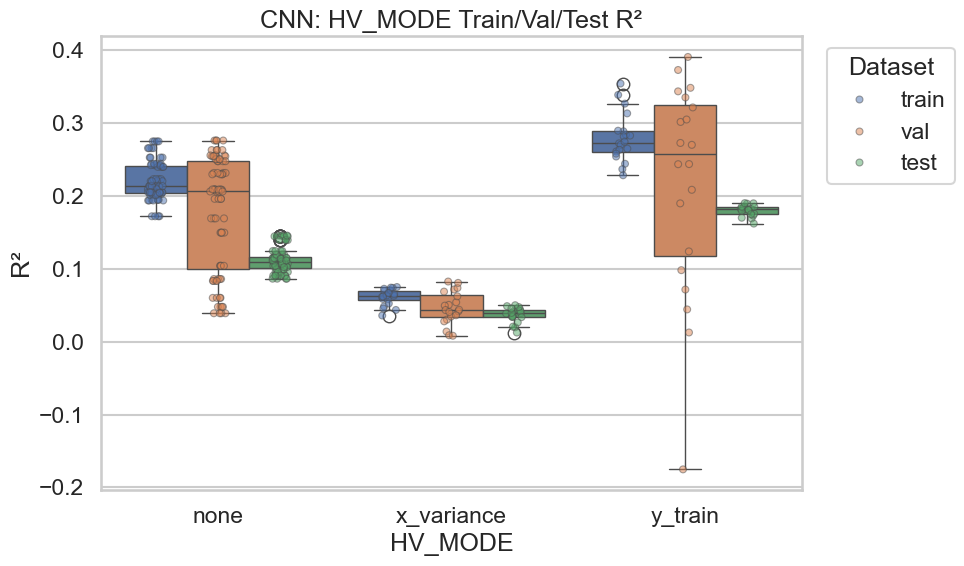

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, re, glob

DIR = "results_planA_fixed_test"
pattern = os.path.join(DIR, "CNN_seed_metrics_across_*.csv")
paths = sorted(glob.glob(pattern))

def parse_hv_mode(path):
    fname = os.path.basename(path)
    m = re.search(r"across_([A-Za-z0-9_]+)_\d{8}_\d{6}\.csv$", fname)
    return m.group(1) if m else "unknown"

dfs = []
for p in paths:
    df = pd.read_csv(p)
    df["HV_MODE"] = parse_hv_mode(p)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# melt
df_r2 = df_all.melt(
    id_vars=["HV_MODE", "seed_idx"],
    value_vars=["train_R2", "val_R2", "test_R2"],
    var_name="dataset", value_name="R2"
)

df_r2["dataset"] = df_r2["dataset"].map({
    "train_R2": "train",
    "val_R2": "val",
    "test_R2": "test"
})

# plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=df_r2, x="HV_MODE", y="R2", hue="dataset", dodge=True)
sns.stripplot(data=df_r2, x="HV_MODE", y="R2", hue="dataset",
              dodge=True, alpha=0.5, linewidth=0.8, edgecolor="gray")

# 중복 범례 제거
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Dataset", bbox_to_anchor=(1.02,1), loc="upper left")

plt.title("CNN: HV_MODE Train/Val/Test R²")
plt.xlabel("HV_MODE")
plt.ylabel("R²")
plt.tight_layout()
plt.show()


In [9]:
# -*- coding: utf-8 -*-
"""
Publication-ready pipeline (Plan A: fixed test cohort)
- Fixed test PID cohort persisted to JSON (reproducibility)
- Single ablation/grid on train+val (no internal split), then seed=20 ensemble
- Optional HV sensitivity (none / x_variance / y_train) — each redoes selection/tuning on train/val
- Negative controls (label shift, time-order destroy) run once
- TF32 explicitly disabled; deterministic knobs set

Requires:
  - ml_pipeline.py: run_ablation, select_features_by_ablation, run_grid_search,
                    train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_seed, to_loader, plot_train_val_loss
"""

import os, json, datetime
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"

import numpy as np
import torch

# ==== Reproducibility / TF32 off (explicit) ====
torch.set_float32_matmul_precision("highest")  # effectively disables TF32 matmul paths
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

from ml_pipeline import (
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results,
)
from ml_utils import (
    set_seed, to_loader
)

# ------------- Config -------------
seed_master = 42
set_seed(seed_master)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"

DATA_DIR = "ml_processed_raw"
OUT_DIR  = "results_planA_fixed_test"
os.makedirs(OUT_DIR, exist_ok=True)

# Fixed test cohort size (recommend 8–12)
TEST_K = 10
VAL_RATIO = 0.20   # among non-test participants
GAP_STEPS = 10     # irrelevant for participant-disjoint splits, kept for consistency
RUN_HV_SENSITIVITY = True  # set False to skip
HV_QUANTILE = 0.25

# Ablation/Grid settings (single pass per HV mode)
RUN_ABLATION = True
ABLATION_EPOCHS = 10
RUN_GRID = True
GRID_EPOCHS = 20

# Final train/eval
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL = 50
patience_ablation = 10
min_delta_ablation = 1e-6
patience_grid = 7
min_delta_grid = 1e-5
patience_train = 7
min_delta_train = 1e-3

# Optional: manually pin a fixed test cohort here; if None, it will be sampled and saved.
MANUAL_TEST_PID_LIST = None  # e.g., ["001","007","010","014","021","033","048","058","077","103"]

# ---------------------------------
# Utilities
# ---------------------------------
def dbg(msg: str):
    print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T)
        return np.transpose(X, (0, 2, 1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous: both middle and last dims equal |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def hv_mask_from_train_x(X_all, train_mask, q=0.30):
    X_all = np.asarray(X_all, dtype=np.float32)
    X_flat = X_all.reshape(X_all.shape[0], -1)
    std_all = X_flat.std(axis=1)
    thr = float(np.quantile(std_all[train_mask], q)) if np.any(train_mask) else 0.0
    keep_all = std_all >= thr
    return keep_all

def center_from_train_split(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        y = y.astype(np.float32)
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y - mu

    return center_fn, {"global_mean": global_mean}

def sample_or_load_fixed_test_pids(pid_array, manual_list=None, k=10, save_path=None, seed=42):
    uniq = np.unique(pid_array).tolist()
    if manual_list is not None:
        test_pids = [p for p in manual_list if p in uniq]
    else:
        rng = np.random.default_rng(seed)
        test_pids = rng.choice(uniq, size=min(k, len(uniq)), replace=False).tolist()
    meta = {
        "date": datetime.datetime.now().isoformat(),
        "seed": seed,
        "test_pids": test_pids,
        "note": "Fixed test cohort for Plan A"
    }
    if save_path:
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)
    return test_pids

def make_participant_disjoint_masks(pid, test_pid_list, val_ratio=0.20, seed=42):
    """Return boolean masks (train_mask, val_mask, test_mask), participant-disjoint."""
    all_pids = np.unique(pid).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    # choose val pids
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])

    pid = np.asarray(pid)
    test_mask  = np.isin(pid, list(test_set))
    val_mask   = np.isin(pid, list(val_pids))
    train_mask = np.isin(pid, list(train_pids))
    return train_mask, val_mask, test_mask, sorted(list(train_pids)), sorted(list(val_pids))

def assert_no_pid_overlap(pid_train, pid_test):
    dup = set(pid_train.tolist()).intersection(set(pid_test.tolist()))
    assert len(dup) == 0, f"PID overlap detected: {sorted(list(dup))[:10]}"

def negative_controls_once(X_trainval, y_trainval, pid_trainval, X_test, y_test, best_params):
    def destroy_time_order(X, rng=None):
        rng = np.random.default_rng(2025) if rng is None else rng
        Nn, Tt, Cc = X.shape
        out = np.empty_like(X)
        for i in range(Nn):
            perm = rng.permutation(Tt)
            out[i] = X[i, perm, :]
        return out

    def shift_labels_per_pid(y_, pid_, k=5):
        y_out = y_.copy()
        for p in np.unique(pid_):
            idx = np.where(pid_ == p)[0]
            if len(idx) > 0:
                y_out[idx] = np.roll(y_[idx], k % len(idx))
        return y_out

    print("\n[QC] Label-shift negative control...")
    y_shift = shift_labels_per_pid(y_trainval, pid_trainval, k=max(1, X_trainval.shape[1]//4))
    _, _, scores_neg = train_and_evaluate_seeds(
        X_trainval, y_shift, pid_trainval,
        X_test, y_test,
        model_type="CNN",
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_neg = float(np.mean([s[0] for s in scores_neg]))
    print(f"[QC] Label-shift R² ≈ {r2_neg:.4f} (≈0 근처가 정상)")

    print("[QC] Time-order destroyed control...")
    X_trv_perm = destroy_time_order(X_trainval)
    X_te_perm  = destroy_time_order(X_test)
    _, _, scores_perm = train_and_evaluate_seeds(
        X_trv_perm, y_trainval, pid_trainval,
        X_te_perm,  y_test,
        model_type="CNN",
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_perm = float(np.mean([s[0] for s in scores_perm]))
    print(f"[QC] Time-order destroyed R² ≈ {r2_perm:.4f} (낮아야 정상)")

# ---------------------------------
# Load data
# ---------------------------------
X = np.load(f"{DATA_DIR}/X_array.npy")
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape} | C={C}")

# ---------------------------------
# Fix test cohort (persist)
# ---------------------------------
SPLIT_JSON = os.path.join(OUT_DIR, "split_fixed_test.json")
test_pid_list = sample_or_load_fixed_test_pids(
    pid, manual_list=MANUAL_TEST_PID_LIST, k=TEST_K, save_path=SPLIT_JSON, seed=seed_master
)
train_mask, val_mask, test_mask, train_pids, val_pids = make_participant_disjoint_masks(
    pid, test_pid_list, val_ratio=VAL_RATIO, seed=seed_master
)
split_info = {
    "train_pids": train_pids,
    "val_pids": val_pids,
    "test_pids": sorted(test_pid_list),
    "val_ratio": VAL_RATIO,
    "gap_steps": GAP_STEPS,
    "seed": seed_master
}
with open(SPLIT_JSON, "w", encoding="utf-8") as f:
    json.dump(split_info, f, ensure_ascii=False, indent=2)
print("[META] Saved split to:", SPLIT_JSON)

# Materialize splits
TR_idx = np.where(train_mask)[0]
VA_idx = np.where(val_mask)[0]
TE_idx = np.where(test_mask)[0]

X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]

assert_no_pid_overlap(pid_train, pid_test)
assert_no_pid_overlap(pid_val, pid_test)
dbg(f"Split sizes → train:{len(y_train_raw)} | val:{len(y_val_raw)} | test:{len(y_test_raw)}")
dbg(f"PIDs → train:{len(np.unique(pid_train))} | val:{len(np.unique(pid_val))} | test:{len(np.unique(pid_test))}")

# ---------------------------------
# Core run (optionally with HV sensitivity)
# ---------------------------------
def run_one_mode(HV_MODE: str):
    """One full round: HV masking (if any) → center(train-only) → ablation/grid → seed-ensemble test."""
    # ---- HV selection (train-only stats) ----
    if HV_MODE == "none":
        keep_train = np.ones(len(y_train_raw), dtype=bool)
        keep_val   = np.ones(len(y_val_raw), dtype=bool)
        keep_test  = np.ones(len(y_test_raw), dtype=bool)
    elif HV_MODE == "x_variance":
        # threshold from TRAIN only
        keep_all   = hv_mask_from_train_x(
            np.concatenate([X_train_raw, X_val_raw, X_test_raw], axis=0),
            np.concatenate([np.ones(len(y_train_raw), bool),
                            np.zeros(len(y_val_raw) + len(y_test_raw), bool)], axis=0),
            q=HV_QUANTILE
        )
        # split back
        keep_train = keep_all[:len(y_train_raw)]
        keep_val   = keep_all[len(y_train_raw):len(y_train_raw)+len(y_val_raw)]
        keep_test  = keep_all[len(y_train_raw)+len(y_val_raw):]
    elif HV_MODE == "y_train":
        # safer variant: train-derived deviation to (pid,scene) means
        # build centerer on TRAIN to reuse (we just need means to compute abs dev)
        center_fn_tmp, _ = center_from_train_split(y_train_raw, pid_train, scene_train)
        # absolute deviation on TRAIN
        y_dev_tr = np.abs(center_fn_tmp(y_train_raw, pid_train, scene_train))
        thr = float(np.quantile(y_dev_tr, HV_QUANTILE)) if len(y_dev_tr) else 0.0
        # apply to VAL/TEST using TRAIN means
        keep_train = (y_dev_tr >= thr)
        keep_val   = (np.abs(center_fn_tmp(y_val_raw, pid_val, scene_val))   >= thr)
        keep_test  = (np.abs(center_fn_tmp(y_test_raw, pid_test, scene_test)) >= thr)
    else:
        raise ValueError("Unknown HV_MODE")

    # slice by HV keepers
    X_tr, y_tr, pid_tr, scene_tr = X_train_raw[keep_train], y_train_raw[keep_train], pid_train[keep_train], scene_train[keep_train]
    X_va, y_va, pid_va, scene_va = X_val_raw[keep_val],   y_val_raw[keep_val],   pid_val[keep_val],   scene_val[keep_val]
    X_te, y_te, pid_te, scene_te = X_test_raw[keep_test], y_test_raw[keep_test], pid_test[keep_test], scene_test[keep_test]
    dbg(f"[{HV_MODE}] kept → train:{len(y_tr)} | val:{len(y_va)} | test:{len(y_te)}")

    # ---- Center from TRAIN only (hierarchical means) ----
    center_fn, _stat = center_from_train_split(y_tr, pid_tr, scene_tr)
    y_tr_c = center_fn(y_tr, pid_tr, scene_tr)
    y_va_c = center_fn(y_va, pid_va, scene_va)
    y_te_c = center_fn(y_te, pid_te, scene_te)

    # ---- Ablation (mask-based) ----
    fixed_params = {
        "num_filters": 64,
        "kernel_size": 5,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "input_channels": X_tr.shape[-1],
    }

    if RUN_ABLATION:
        df_ablation = run_ablation(
            X_tr, y_tr_c, pid_tr,
            X_va, y_va_c, pid_va,
            feature_tag_list,
            model_type=model_type,
            fixed_params=fixed_params,
            seed=seed_master,
            num_epochs=ABLATION_EPOCHS,
            save_path=os.path.join(OUT_DIR, f"ablation_{HV_MODE}.csv"),
            patience=patience_ablation,
            min_delta=min_delta_ablation
        )
        keep_features, keep_indices = select_features_by_ablation(
            df_ablation, feature_tag_list, threshold=0.0005
        )
    else:
        keep_indices = np.arange(X_tr.shape[-1]).tolist()
        keep_features = feature_tag_list

    # ---- Channel slice ----
    X_tr = X_tr[:, :, keep_indices]
    X_va = X_va[:, :, keep_indices]
    X_te = X_te[:, :, keep_indices]
    feat_tags_sel = (np.array(feature_tag_list)[keep_indices]).tolist()
    new_C = X_tr.shape[-1]
    dbg(f"[{HV_MODE}] features selected: {new_C}")

    # ---- Grid Search (external val only) ----
    search_space = {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5, 7],
        "dropout": [0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    }
    # sanity: kernel_size ≤ T
    tmp_loader = to_loader(X_tr, y_tr_c, "CNN", batch_size=1, shuffle=False, input_channels=new_C)
    xb, _ = next(iter(tmp_loader))
    L_eff = xb.shape[-1]
    search_space["kernel_size"] = [k for k in search_space["kernel_size"] if k <= L_eff]

    if RUN_GRID:
        best_params, _ = run_grid_search(
            X_tr, y_tr_c, pid_tr,
            model_type=model_type,
            search_space=search_space,
            seed=seed_master,
            num_epochs=GRID_EPOCHS,
            patience=patience_grid,
            min_delta=min_delta_grid,
            use_internal_split=False,
            external_val_data=(X_va, y_va_c)
        )
        best_params = dict(best_params)
    else:
        best_params = {
            "num_filters": 64, "kernel_size": 5, "dropout": 0.3,
            "batch_size": 32, "learning_rate": 1e-3
        }
    best_params["input_channels"] = new_C
    dbg(f"[{HV_MODE}] best_params={best_params}")

    # ---- Final: train on train+val → test (seed ensemble) ----
    X_trv = np.concatenate([X_tr, X_va], axis=0)
    y_trv = np.concatenate([y_tr_c, y_va_c], axis=0)
    pid_trv = np.concatenate([pid_tr, pid_va], axis=0)

    # Safety
    assert X_trv.shape[-1] == X_te.shape[-1] == best_params["input_channels"]

    train_losses, val_losses, test_scores = train_and_evaluate_seeds(
        X_trv, y_trv, pid_trv,
        X_te, y_te_c,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=NUM_SEEDS_FINAL,
        num_epochs=EPOCHS_FINAL,
        patience=patience_train,
        min_delta=min_delta_train
    )
    summarize_test_results(test_scores)  # prints mean±se over seeds

    # Save a compact summary per HV mode
    r2s = [s[0] for s in test_scores]
    out = {
        "HV_MODE": HV_MODE,
        "test_pids": sorted(np.unique(pid_te).tolist()),
        "feat_count": new_C,
        "best_params": best_params,
        "seed_mean_r2": float(np.mean(r2s)),
        "seed_std_r2": float(np.std(r2s, ddof=1)) if len(r2s) > 1 else 0.0,
        "n_seeds": len(r2s)
    }
    with open(os.path.join(OUT_DIR, f"summary_{HV_MODE}.json"), "w", encoding="utf-8") as f:
        json.dump(out, f, ensure_ascii=False, indent=2)

    return {"best_params": best_params, "feat_tags": feat_tags_sel,
            "X_trv": X_trv, "y_trv": y_trv, "pid_trv": pid_trv,
            "X_te": X_te, "y_te_c": y_te_c}

# ---- Run main (with HV sensitivity loop if enabled) ----
modes = ["none", "x_variance", "y_train"] if RUN_HV_SENSITIVITY else ["none"]
last_result = None
for hv in modes:
    print(f"\n========== HV MODE: {hv} ==========")
    last_result = run_one_mode(hv)

# ---- Negative controls (1회, 마지막 HV 모드의 모델/선택 기준 사용) ----
if last_result is not None:
    print("\n========== NEGATIVE CONTROLS ==========")
    negative_controls_once(
        last_result["X_trv"], last_result["y_trv"], last_result["pid_trv"],
        last_result["X_te"],  last_result["y_te_c"],
        last_result["best_params"]
    )

print("\nDone. See:", OUT_DIR)


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
[META] Saved split to: results_planA_fixed_test\split_fixed_test.json
[DBG] Split sizes → train:9188 | val:1840 | test:951
[DBG] PIDs → train:74 | val:19 | test:10

========== HV MODE: none ==========
[DBG] [none] kept → train:9188 | val:1840 | test:951
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
🔍 Masking EDA_Tonic (1/77)
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥7))
[LOADER-CNN] batch shape=(32, 77, 150)  (expect: (B,77,T≥

KeyboardInterrupt: 

In [1]:
# -*- coding: utf-8 -*-
# planA_main_gru_attn.py
import os, json
import numpy as np
import torch
from ml_utils import (
    set_reproducible, dbg, to_NTC_strict, sample_or_load_fixed_test_pids,
    make_participant_disjoint_masks, assert_no_pid_overlap, run_planA_one_mode,
    negative_controls_once
)

# ======= Config =======
seed_master = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "ml_processed_raw"
OUT_DIR  = "results_planA_fixed_test_GRUAttn"
os.makedirs(OUT_DIR, exist_ok=True)

TEST_K = 10
VAL_RATIO = 0.20
RUN_HV_SENSITIVITY = True
HV_MODES = ["none", "x_variance", "y_train"] if RUN_HV_SENSITIVITY else ["none"]
HV_QUANTILE = 0.25

# Training lengths
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL = 50

# Early-stops
patience_ablation = 10; min_delta_ablation = 1e-6
patience_grid     = 7 ; min_delta_grid     = 1e-5
patience_train    = 7 ; min_delta_train    = 1e-3

# Model meta
model_type = "GRU_Attn"
fixed_params_base = {
    "hidden_size": 64,
    "num_layers": 1,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "use_attention": True,   # ✅ GRU_Attn
}
search_space = {
    "hidden_size":  [32, 64, 128],
    "num_layers":   [1, 2],
    "dropout":      [0.2, 0.3, 0.4, 0.5, 0.6],
    "batch_size":   [32],
    "learning_rate":[1e-3, 3e-4, 1e-4],
    "use_attention":[True],
}

# ======= Reproducibility =======
set_reproducible()
np.random.seed(seed_master)
torch.manual_seed(seed_master)

# ======= Load data =======
X = np.load(f"{DATA_DIR}/X_array.npy")
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
dbg(f"Normalized to (N,T,C)={X.shape} | C={X.shape[-1]}")

# ======= Fix test cohort =======
SPLIT_JSON = os.path.join(OUT_DIR, "split_fixed_test.json")
test_pid_list = sample_or_load_fixed_test_pids(pid, manual_list=None, k=TEST_K, save_path=SPLIT_JSON, seed=42)
train_mask, val_mask, test_mask, train_pids, val_pids = make_participant_disjoint_masks(
    pid, test_pid_list, val_ratio=VAL_RATIO, seed=seed_master
)
with open(SPLIT_JSON, "w", encoding="utf-8") as f:
    json.dump({
        "train_pids": train_pids, "val_pids": val_pids, "test_pids": sorted(test_pid_list),
        "val_ratio": VAL_RATIO, "seed": seed_master
    }, f, ensure_ascii=False, indent=2)
print("[META] Saved split to:", SPLIT_JSON)

# materialize
TR_idx = np.where(train_mask)[0]; VA_idx = np.where(val_mask)[0]; TE_idx = np.where(test_mask)[0]
X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]
assert_no_pid_overlap(pid_train, pid_test); assert_no_pid_overlap(pid_val, pid_test)

# ======= Run (optionally with HV sensitivity) =======
last_result = None
for hv in HV_MODES:
    print(f"\n========== HV MODE: {hv} ==========")
    last_result = run_planA_one_mode(
        hv,
        X_train_raw, y_train_raw, pid_train, scene_train,
        X_val_raw,   y_val_raw,   pid_val,   scene_val,
        X_test_raw,  y_test_raw,  pid_test,  scene_test,
        feature_tag_list, OUT_DIR, seed_master, device, model_type,
        RUN_ABLATION=True, ABLATION_EPOCHS=10, RUN_GRID=True, GRID_EPOCHS=20,
        NUM_SEEDS_FINAL=NUM_SEEDS_FINAL, EPOCHS_FINAL=EPOCHS_FINAL,
        patience_ablation=patience_ablation, min_delta_ablation=min_delta_ablation,
        patience_grid=patience_grid,         min_delta_grid=min_delta_grid,
        patience_train=patience_train,       min_delta_train=min_delta_train,
        HV_QUANTILE=HV_QUANTILE, selection_threshold=0.0005,
        fixed_params_base=fixed_params_base, search_space=search_space
    )

# ======= Negative controls (1회) =======
if last_result is not None:
    print("\n========== NEGATIVE CONTROLS ==========")
    negative_controls_once(
        last_result["X_trv"], last_result["y_trv"], last_result["pid_trv"],
        last_result["X_te"],  last_result["y_te_c"],
        last_result["best_params"], model_type, device
    )

print("\nDone. See:", OUT_DIR)


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
[META] Saved split to: results_planA_fixed_test_GRUAttn\split_fixed_test.json

========== HV MODE: none ==========
[DBG] [none] kept → train:9188 | val:1840 | test:951
🔍 Masking EDA_Tonic (1/77)
🔍 Masking EDA_Tonic_diff1 (2/77)
🔍 Masking EDA_Tonic_diff2 (3/77)
🔍 Masking EDA_Tonic_ma60 (4/77)
🔍 Masking EDA_Tonic_std150 (5/77)
🔍 Masking EDA_Tonic_slope (6/77)
🔍 Masking EDA_Tonic_iqr (7/77)
🔍 Masking EDA_Phasic (8/77)
🔍 Masking EDA_Phasic_diff1 (9/77)
🔍 Masking EDA_Phasic_diff2 (10/77)
🔍 Masking EDA_Phasic_ma60 (11/77)
🔍 Masking EDA_Phasic_std150 (12/77)
🔍 Masking EDA_Phasic_slope (13/77)
🔍 Masking EDA_Phasic_iqr (14/77)
🔍 Masking SCR_Amplitude (15/77)
🔍 Masking SCR_Amplitude_diff1 (16/77)
🔍 Masking SCR_Amplitude_diff2 (17/77)
🔍 Masking SCR_Amplitude_ma60 (18/77)
🔍 Masking SCR_Amplitude_std150 (19/77)
🔍 Masking SCR_Amplitude_slope (20/77)
🔍 Masking SCR_Amplitude_iqr (21/77)
🔍 Masking SCR_RiseTime (22/77)
🔍 Masking SCR_RiseTime_diff1 (23/

In [9]:
# -*- coding: utf-8 -*-
"""
Publication-ready pipeline (Plan A: fixed test cohort) — LSTM version
- Fixed test PID cohort persisted to JSON (reproducibility)
- Single ablation/grid on train+val (no internal split), then seed=20 ensemble
- Optional HV sensitivity (none / x_variance / y_train) — each redoes selection/tuning on train/val
- Negative controls (label shift, time-order destroy) run once
- TF32 explicitly disabled; deterministic knobs set

Requires:
  - ml_pipeline.py: run_ablation, select_features_by_ablation, run_grid_search,
                    train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_seed, to_loader, plot_train_val_loss  (to_loader not strictly needed here)
"""

import os, json, datetime
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"

import numpy as np
import torch

# ==== Reproducibility / TF32 off (explicit) ====
torch.set_float32_matmul_precision("highest")  # effectively disables TF32 matmul paths
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

from ml_pipeline import (
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results,
)
from ml_utils import (
    set_seed, to_loader
)

# ------------- Config -------------
seed_master = 42
set_seed(seed_master)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "LSTM"

DATA_DIR = "ml_processed_raw"
OUT_DIR  = "results_planA_fixed_test_LSTM"
os.makedirs(OUT_DIR, exist_ok=True)

# Fixed test cohort size (recommend 8–12)
TEST_K = 10
VAL_RATIO = 0.20   # among non-test participants
GAP_STEPS = 10     # irrelevant for participant-disjoint splits, kept for consistency
RUN_HV_SENSITIVITY = True  # set False to skip
HV_QUANTILE = 0.25

# Ablation/Grid settings (single pass per HV mode)
RUN_ABLATION = True
ABLATION_EPOCHS = 10
RUN_GRID = True
GRID_EPOCHS = 20

# Final train/eval
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL = 50
patience_ablation = 10
min_delta_ablation = 1e-6
patience_grid = 7
min_delta_grid = 1e-5
patience_train = 7
min_delta_train = 1e-3

# Optional: manually pin a fixed test cohort here; if None, it will be sampled and saved.
MANUAL_TEST_PID_LIST = None  # e.g., ["001","007","010","014","021","033","048","058","077","103"]

# ---------------------------------
# Utilities
# ---------------------------------
def dbg(msg: str):
    print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T)
        return np.transpose(X, (0, 2, 1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous: both middle and last dims equal |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def hv_mask_from_train_x(X_all, train_mask, q=0.30):
    X_all = np.asarray(X_all, dtype=np.float32)
    X_flat = X_all.reshape(X_all.shape[0], -1)
    std_all = X_flat.std(axis=1)
    thr = float(np.quantile(std_all[train_mask], q)) if np.any(train_mask) else 0.0
    keep_all = std_all >= thr
    return keep_all

def center_from_train_split(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        y = y.astype(np.float32)
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y - mu

    return center_fn, {"global_mean": global_mean}

def sample_or_load_fixed_test_pids(pid_array, manual_list=None, k=10, save_path=None, seed=42):
    uniq = np.unique(pid_array).tolist()
    if manual_list is not None:
        test_pids = [p for p in manual_list if p in uniq]
    else:
        rng = np.random.default_rng(seed)
        test_pids = rng.choice(uniq, size=min(k, len(uniq)), replace=False).tolist()
    meta = {
        "date": datetime.datetime.now().isoformat(),
        "seed": seed,
        "test_pids": test_pids,
        "note": "Fixed test cohort for Plan A"
    }
    if save_path:
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)
    return test_pids

def make_participant_disjoint_masks(pid, test_pid_list, val_ratio=0.20, seed=42):
    """Return boolean masks (train_mask, val_mask, test_mask), participant-disjoint."""
    all_pids = np.unique(pid).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    # choose val pids
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])

    pid = np.asarray(pid)
    test_mask  = np.isin(pid, list(test_set))
    val_mask   = np.isin(pid, list(val_pids))
    train_mask = np.isin(pid, list(train_pids))
    return train_mask, val_mask, test_mask, sorted(list(train_pids)), sorted(list(val_pids))

def assert_no_pid_overlap(pid_train, pid_test):
    dup = set(pid_train.tolist()).intersection(set(pid_test.tolist()))
    assert len(dup) == 0, f"PID overlap detected: {sorted(list(dup))[:10]}"

def negative_controls_once(X_trainval, y_trainval, pid_trainval, X_test, y_test, best_params):
    def destroy_time_order(X, rng=None):
        rng = np.random.default_rng(2025) if rng is None else rng
        Nn, Tt, Cc = X.shape
        out = np.empty_like(X)
        for i in range(Nn):
            perm = rng.permutation(Tt)
            out[i] = X[i, perm, :]
        return out

    def shift_labels_per_pid(y_, pid_, k=5):
        y_out = y_.copy()
        for p in np.unique(pid_):
            idx = np.where(pid_ == p)[0]
            if len(idx) > 0:
                y_out[idx] = np.roll(y_[idx], k % len(idx))
        return y_out

    print("\n[QC] Label-shift negative control...")
    y_shift = shift_labels_per_pid(y_trainval, pid_trainval, k=max(1, X_trainval.shape[1]//4))
    _, _, scores_neg = train_and_evaluate_seeds(
        X_trainval, y_shift, pid_trainval,
        X_test, y_test,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_neg = float(np.mean([s[0] for s in scores_neg]))
    print(f"[QC] Label-shift R² ≈ {r2_neg:.4f} (≈0 근처가 정상)")

    print("[QC] Time-order destroyed control...")
    X_trv_perm = destroy_time_order(X_trainval)
    X_te_perm  = destroy_time_order(X_test)
    _, _, scores_perm = train_and_evaluate_seeds(
        X_trv_perm, y_trainval, pid_trainval,
        X_te_perm,  y_test,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_perm = float(np.mean([s[0] for s in scores_perm]))
    print(f"[QC] Time-order destroyed R² ≈ {r2_perm:.4f} (낮아야 정상)")

# ---------------------------------
# Load data
# ---------------------------------
X = np.load(f"{DATA_DIR}/X_array.npy")
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape} | C={C}")

# ---------------------------------
# Fix test cohort (persist)
# ---------------------------------
SPLIT_JSON = os.path.join(OUT_DIR, "split_fixed_test.json")
test_pid_list = sample_or_load_fixed_test_pids(
    pid, manual_list=MANUAL_TEST_PID_LIST, k=TEST_K, save_path=SPLIT_JSON, seed=seed_master
)
train_mask, val_mask, test_mask, train_pids, val_pids = make_participant_disjoint_masks(
    pid, test_pid_list, val_ratio=VAL_RATIO, seed=seed_master
)
split_info = {
    "train_pids": train_pids,
    "val_pids": val_pids,
    "test_pids": sorted(test_pid_list),
    "val_ratio": VAL_RATIO,
    "gap_steps": GAP_STEPS,
    "seed": seed_master
}
with open(SPLIT_JSON, "w", encoding="utf-8") as f:
    json.dump(split_info, f, ensure_ascii=False, indent=2)
print("[META] Saved split to:", SPLIT_JSON)

# Materialize splits
TR_idx = np.where(train_mask)[0]
VA_idx = np.where(val_mask)[0]
TE_idx = np.where(test_mask)[0]

X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]

assert_no_pid_overlap(pid_train, pid_test)
assert_no_pid_overlap(pid_val, pid_test)
dbg(f"Split sizes → train:{len(y_train_raw)} | val:{len(y_val_raw)} | test:{len(y_test_raw)}")
dbg(f"PIDs → train:{len(np.unique(pid_train))} | val:{len(np.unique(pid_val))} | test:{len(np.unique(pid_test))}")

# ---------------------------------
# Core run (optionally with HV sensitivity)
# ---------------------------------
def run_one_mode(HV_MODE: str):
    """One full round: HV masking (if any) → center(train-only) → ablation/grid → seed-ensemble test."""
    # ---- HV selection (train-only stats) ----
    if HV_MODE == "none":
        keep_train = np.ones(len(y_train_raw), dtype=bool)
        keep_val   = np.ones(len(y_val_raw), dtype=bool)
        keep_test  = np.ones(len(y_test_raw), dtype=bool)
    elif HV_MODE == "x_variance":
        # threshold from TRAIN only
        keep_all   = hv_mask_from_train_x(
            np.concatenate([X_train_raw, X_val_raw, X_test_raw], axis=0),
            np.concatenate([np.ones(len(y_train_raw), bool),
                            np.zeros(len(y_val_raw) + len(y_test_raw), bool)], axis=0),
            q=HV_QUANTILE
        )
        # split back
        keep_train = keep_all[:len(y_train_raw)]
        keep_val   = keep_all[len(y_train_raw):len(y_train_raw)+len(y_val_raw)]
        keep_test  = keep_all[len(y_train_raw)+len(y_val_raw):]
    elif HV_MODE == "y_train":
        # safer variant: train-derived deviation to (pid,scene) means
        center_fn_tmp, _ = center_from_train_split(y_train_raw, pid_train, scene_train)
        y_dev_tr = np.abs(center_fn_tmp(y_train_raw, pid_train, scene_train))
        thr = float(np.quantile(y_dev_tr, HV_QUANTILE)) if len(y_dev_tr) else 0.0
        keep_train = (y_dev_tr >= thr)
        keep_val   = (np.abs(center_fn_tmp(y_val_raw, pid_val, scene_val))   >= thr)
        keep_test  = (np.abs(center_fn_tmp(y_test_raw, pid_test, scene_test)) >= thr)
    else:
        raise ValueError("Unknown HV_MODE")

    # slice by HV keepers
    X_tr, y_tr, pid_tr, scene_tr = X_train_raw[keep_train], y_train_raw[keep_train], pid_train[keep_train], scene_train[keep_train]
    X_va, y_va, pid_va, scene_va = X_val_raw[keep_val],   y_val_raw[keep_val],   pid_val[keep_val],   scene_val[keep_val]
    X_te, y_te, pid_te, scene_te = X_test_raw[keep_test], y_test_raw[keep_test], pid_test[keep_test], scene_test[keep_test]
    dbg(f"[{HV_MODE}] kept → train:{len(y_tr)} | val:{len(y_va)} | test:{len(y_te)}")

    # ---- Center from TRAIN only (hierarchical means) ----
    center_fn, _stat = center_from_train_split(y_tr, pid_tr, scene_tr)
    y_tr_c = center_fn(y_tr, pid_tr, scene_tr)
    y_va_c = center_fn(y_va, pid_va, scene_va)
    y_te_c = center_fn(y_te, pid_te, scene_te)

    # ---- Ablation (mask-based) ----
    fixed_params = {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "input_size": X_tr.shape[-1],   # LSTM expects input_size=C
    }

    if RUN_ABLATION:
        df_ablation = run_ablation(
            X_tr, y_tr_c, pid_tr,
            X_va, y_va_c, pid_va,
            feature_tag_list,
            model_type=model_type,
            fixed_params=fixed_params,
            seed=seed_master,
            num_epochs=ABLATION_EPOCHS,
            save_path=os.path.join(OUT_DIR, f"ablation_{HV_MODE}.csv"),
            patience=patience_ablation,
            min_delta=min_delta_ablation
        )
        keep_features, keep_indices = select_features_by_ablation(
            df_ablation, feature_tag_list, threshold=0.0005
        )
    else:
        keep_indices = np.arange(X_tr.shape[-1]).tolist()
        keep_features = feature_tag_list

    # ---- Channel slice ----
    X_tr = X_tr[:, :, keep_indices]
    X_va = X_va[:, :, keep_indices]
    X_te = X_te[:, :, keep_indices]
    feat_tags_sel = (np.array(feature_tag_list)[keep_indices]).tolist()
    new_C = X_tr.shape[-1]
    dbg(f"[{HV_MODE}] features selected: {new_C}")

    # ---- Grid Search (external val only) ----
    # LSTM hyperparameters
    search_space = {
        "hidden_size": [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    }
    # (No kernel_size check necessary for LSTM; ensure input_size is set)
    if RUN_GRID:
        best_params, _ = run_grid_search(
            X_tr, y_tr_c, pid_tr,
            model_type=model_type,
            search_space=search_space,
            seed=seed_master,
            num_epochs=GRID_EPOCHS,
            patience=patience_grid,
            min_delta=min_delta_grid,
            use_internal_split=False,
            external_val_data=(X_va, y_va_c)
        )
        best_params = dict(best_params)
    else:
        best_params = {
            "hidden_size": 64, "num_layers": 1, "dropout": 0.3,
            "batch_size": 32, "learning_rate": 1e-3
        }
    best_params["input_size"] = new_C
    dbg(f"[{HV_MODE}] best_params={best_params}")

    # ---- Final: train on train+val → test (seed ensemble) ----
    X_trv = np.concatenate([X_tr, X_va], axis=0)
    y_trv = np.concatenate([y_tr_c, y_va_c], axis=0)
    pid_trv = np.concatenate([pid_tr, pid_va], axis=0)

    # Safety
    assert X_trv.shape[-1] == X_te.shape[-1] == best_params["input_size"]

    train_losses, val_losses, test_scores = train_and_evaluate_seeds(
        X_trv, y_trv, pid_trv,
        X_te, y_te_c,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=NUM_SEEDS_FINAL,
        num_epochs=EPOCHS_FINAL,
        patience=patience_train,
        min_delta=min_delta_train
    )
    summarize_test_results(test_scores)  # prints mean±se over seeds

    # Save a compact summary per HV mode
    r2s = [s[0] for s in test_scores]
    out = {
        "HV_MODE": HV_MODE,
        "test_pids": sorted(np.unique(pid_te).tolist()),
        "feat_count": new_C,
        "best_params": best_params,
        "seed_mean_r2": float(np.mean(r2s)),
        "seed_std_r2": float(np.std(r2s, ddof=1)) if len(r2s) > 1 else 0.0,
        "n_seeds": len(r2s)
    }
    with open(os.path.join(OUT_DIR, f"summary_{HV_MODE}.json"), "w", encoding="utf-8") as f:
        json.dump(out, f, ensure_ascii=False, indent=2)

    return {"best_params": best_params, "feat_tags": feat_tags_sel,
            "X_trv": X_trv, "y_trv": y_trv, "pid_trv": pid_trv,
            "X_te": X_te, "y_te_c": y_te_c}

# ---- Run main (with HV sensitivity loop if enabled) ----
modes = ["none", "x_variance", "y_train"] if RUN_HV_SENSITIVITY else ["none"]
last_result = None
for hv in modes:
    print(f"\n========== HV MODE: {hv} ==========")
    last_result = run_one_mode(hv)

# ---- Negative controls (1회, 마지막 HV 모드의 모델/선택 기준 사용) ----
if last_result is not None:
    print("\n========== NEGATIVE CONTROLS ==========")
    negative_controls_once(
        last_result["X_trv"], last_result["y_trv"], last_result["pid_trv"],
        last_result["X_te"],  last_result["y_te_c"],
        last_result["best_params"]
    )

print("\nDone. See:", OUT_DIR)


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
[META] Saved split to: results_planA_fixed_test_LSTM\split_fixed_test.json
[DBG] Split sizes → train:9188 | val:1840 | test:951
[DBG] PIDs → train:74 | val:19 | test:10

========== HV MODE: none ==========
[DBG] [none] kept → train:9188 | val:1840 | test:951
🔍 Masking EDA_Tonic (1/77)
🔍 Masking EDA_Tonic_diff1 (2/77)
🔍 Masking EDA_Tonic_diff2 (3/77)
🔍 Masking EDA_Tonic_ma60 (4/77)
🔍 Masking EDA_Tonic_std150 (5/77)
🔍 Masking EDA_Tonic_slope (6/77)
🔍 Masking EDA_Tonic_iqr (7/77)
🔍 Masking EDA_Phasic (8/77)
🔍 Masking EDA_Phasic_diff1 (9/77)
🔍 Masking EDA_Phasic_diff2 (10/77)
🔍 Masking EDA_Phasic_ma60 (11/77)
🔍 Masking EDA_Phasic_std150 (12/77)
🔍 Masking EDA_Phasic_slope (13/77)
🔍 Masking EDA_Phasic_iqr (14/77)
🔍 Masking SCR_Amplitude (15/77)
🔍 Masking SCR_Amplitude_diff1 (16/77)
🔍 Masking SCR_Amplitude_diff2 (17/77)
🔍 Masking SCR_Amplitude_ma60 (18/77)
🔍 Masking SCR_Amplitude_std150 (19/77)
🔍 Masking SCR_Amplitude_slope (20/77)
🔍 Masking

In [2]:
# -*- coding: utf-8 -*-
"""
Publication-ready pipeline (Plan A: fixed test cohort) — LSTM + Sanity Check 옵션 통합본
(리팩토링: train/val/test 점수 집계/저장 강화, 외부 API 변경 없이 파이프라인만 수정)

- 참가자 분리 고정 테스트 코호트 유지
- Ablation/Grid: 외부 검증으로 한 번만 수행
- 선택적 HV 마스킹 (none / x_variance / y_train)
- 선택적 타깃 중심화(center_from_train_split)
- 선택적 TRAIN-only per-channel z-score
- Sanity Check 모드: dropout=0, ES≈off, epochs↑ 로 과적합 가능성 점검

필요:
  - ml_pipeline.py: run_ablation, select_features_by_ablation, run_grid_search,
                    train_and_evaluate_seeds, summarize_test_results
  - ml_utils.py: set_seed, to_loader
  - ml_processed_raw/{X_array.npy, y_array.npy, pid_array.npy, scene_array.npy, windex_array.npy, feature_tag_list.npy}
"""

import os, json, datetime, csv
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = "42"

import numpy as np
import torch

# ==== Reproducibility / TF32 off (explicit) ====
torch.set_float32_matmul_precision("highest")
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

from ml_pipeline import (
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results,
)
from ml_utils import set_seed, to_loader  # to_loader는 필요시만

# ------------- Base Config -------------
seed_master = 42
set_seed(int(seed_master))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "LSTM"

DATA_DIR = "ml_processed_raw"
OUT_DIR  = "results_planA_fixed_test_LSTM"
os.makedirs(OUT_DIR, exist_ok=True)

# Fixed test cohort size (recommend 8–12)
TEST_K = 10
VAL_RATIO = 0.20
GAP_STEPS = 10
RUN_HV_SENSITIVITY = True
HV_QUANTILE = 0.25

# Ablation/Grid (일반 설정)
RUN_ABLATION = True
ABLATION_EPOCHS = 10
RUN_GRID = True
GRID_EPOCHS = 20

# Final train/eval (일반 설정)
NUM_SEEDS_FINAL = 20
EPOCHS_FINAL = 50
patience_ablation = 10
min_delta_ablation = 1e-6
patience_grid = 7
min_delta_grid = 1e-5
patience_train = 7
min_delta_train = 1e-3

# Optional: 수동 테스트 코호트
MANUAL_TEST_PID_LIST = None  # e.g., ["001","007","010","014","021","033","048","058","077","103"]

# ---- Sanity Check switches ----
SANITY_CHECK = True            # True면 과적합 가능성 점검 모드
APPLY_ZSCORE = True            # TRAIN 통계 기반 per-channel 표준화
APPLY_CENTERING = True         # True면 (pid,scene) 평균으로 타깃 center
FORCE_HV_MODE = "none"         # SANITY_CHECK일 때 단일 모드

if SANITY_CHECK:
    RUN_HV_SENSITIVITY = False
    patience_ablation = 999999
    patience_grid = 999999
    patience_train = 999999
    min_delta_ablation = 0.0
    min_delta_grid = 0.0
    min_delta_train = 0.0
    GRID_EPOCHS = 60
    EPOCHS_FINAL = 200

# ---------------------------------
# Utilities
# ---------------------------------
def dbg(msg: str):
    print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T)
        return np.transpose(X, (0, 2, 1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous: both middle and last dims equal |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def hv_mask_from_train_x(X_all, train_mask, q=0.30):
    X_all = np.asarray(X_all, dtype=np.float32)
    X_flat = X_all.reshape(X_all.shape[0], -1)
    std_all = X_flat.std(axis=1)
    thr = float(np.quantile(std_all[train_mask], q)) if np.any(train_mask) else 0.0
    keep_all = std_all >= thr
    return keep_all

def center_from_train_split(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        y = y.astype(np.float32)
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y - mu

    return center_fn, {"global_mean": global_mean}

def sample_or_load_fixed_test_pids(pid_array, manual_list=None, k=10, save_path=None, seed=42):
    uniq = np.unique(pid_array).tolist()
    if manual_list is not None:
        test_pids = [p for p in manual_list if p in uniq]
    else:
        rng = np.random.default_rng(seed)
        test_pids = rng.choice(uniq, size=min(k, len(uniq)), replace=False).tolist()
    meta = {
        "date": datetime.datetime.now().isoformat(),
        "seed": int(seed),
        "test_pids": test_pids,
        "note": "Fixed test cohort for Plan A"
    }
    if save_path:
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)
    return test_pids

def make_participant_disjoint_masks(pid, test_pid_list, val_ratio=0.20, seed=42):
    all_pids = np.unique(pid).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])

    pid = np.asarray(pid)
    test_mask  = np.isin(pid, list(test_set))
    val_mask   = np.isin(pid, list(val_pids))
    train_mask = np.isin(pid, list(train_pids))
    return train_mask, val_mask, test_mask, sorted(list(train_pids)), sorted(list(val_pids))

def assert_no_pid_overlap(pid_a, pid_b):
    dup = set(np.unique(pid_a).tolist()).intersection(set(np.unique(pid_b).tolist()))
    assert len(dup) == 0, f"PID overlap detected: {sorted(list(dup))[:10]}"

def negative_controls_once(X_trainval, y_trainval, pid_trainval, X_test, y_test, best_params):
    def destroy_time_order(X, rng=None):
        rng = np.random.default_rng(2025) if rng is None else rng
        Nn, Tt, Cc = X.shape
        out = np.empty_like(X)
        for i in range(Nn):
            perm = rng.permutation(Tt)
            out[i] = X[i, perm, :]
        return out

    def shift_labels_per_pid(y_, pid_, k=5):
        y_out = y_.copy()
        for p in np.unique(pid_):
            idx = np.where(pid_ == p)[0]
            if len(idx) > 0:
                y_out[idx] = np.roll(y_[idx], k % len(idx))
        return y_out

    print("\n[QC] Label-shift negative control...")
    y_shift = shift_labels_per_pid(y_trainval, pid_trainval, k=max(1, X_trainval.shape[1]//4))
    _, _, scores_neg, _, _ = train_and_evaluate_seeds(
        X_trainval, y_shift, pid_trainval,
        X_test, y_test,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_neg = float(np.mean([s[0] for s in scores_neg]))
    print(f"[QC] Label-shift R² ≈ {r2_neg:.4f} (≈0 근처가 정상)")

    print("[QC] Time-order destroyed control...")
    X_trv_perm = destroy_time_order(X_trainval)
    X_te_perm  = destroy_time_order(X_test)
    _, _, scores_perm, _, _ = train_and_evaluate_seeds(
        X_trv_perm, y_trainval, pid_trainval,
        X_te_perm,  y_test,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=2, num_epochs=5, patience=3, min_delta=1e-3
    )
    r2_perm = float(np.mean([s[0] for s in scores_perm]))
    print(f"[QC] Time-order destroyed R² ≈ {r2_perm:.4f} (낮아야 정상)")

# -------- New: score summarizer & CSV writer --------
def summarize_split_scores(name, scores):
    """
    scores: List[Tuple[r2, rmse, mae]] for a split
    return dict with mean/std
    """
    if scores is None or len(scores) == 0:
        return {f"{name}_r2_mean": None, f"{name}_r2_std": None,
                f"{name}_rmse_mean": None, f"{name}_rmse_std": None,
                f"{name}_mae_mean": None, f"{name}_mae_std": None}
    arr = np.array(scores, dtype=np.float64)  # (S,3)
    out = {
        f"{name}_r2_mean": float(np.mean(arr[:,0])),
        f"{name}_r2_std":  float(np.std(arr[:,0], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_rmse_mean": float(np.mean(arr[:,1])),
        f"{name}_rmse_std":  float(np.std(arr[:,1], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_mae_mean": float(np.mean(arr[:,2])),
        f"{name}_mae_std":  float(np.std(arr[:,2], ddof=1)) if len(arr)>1 else 0.0,
    }
    print(f"➡ {name.upper()}  R² {out[f'{name}_r2_mean']:.4f}±{out[f'{name}_r2_std']:.4f} | "
          f"RMSE {out[f'{name}_rmse_mean']:.4f}±{out[f'{name}_rmse_std']:.4f} | "
          f"MAE {out[f'{name}_mae_mean']:.4f}±{out[f'{name}_mae_std']:.4f}")
    return out

def write_seed_metrics_csv(path_csv, all_train_scores, all_val_scores, test_scores):
    """
    CSV columns: seed, split, r2, rmse, mae
    길이가 다르면 가능한 범위만 기록.
    """
    S = max(len(all_train_scores or []), len(all_val_scores or []), len(test_scores or []))
    with open(path_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["seed","split","r2","rmse","mae"])
        for i in range(S):
            if all_train_scores and i < len(all_train_scores):
                r2, rmse, mae = all_train_scores[i]
                w.writerow([i, "train", f"{r2:.6f}", f"{rmse:.6f}", f"{mae:.6f}"])
            if all_val_scores and i < len(all_val_scores):
                r2, rmse, mae = all_val_scores[i]
                w.writerow([i, "val", f"{r2:.6f}", f"{rmse:.6f}", f"{mae:.6f}"])
            if test_scores and i < len(test_scores):
                r2, rmse, mae = test_scores[i]
                w.writerow([i, "test", f"{r2:.6f}", f"{rmse:.6f}", f"{mae:.6f}"])

# ---------------------------------
# Load data
# ---------------------------------
X = np.load(f"{DATA_DIR}/X_array.npy")
y = np.load(f"{DATA_DIR}/y_array.npy").astype(np.float32)
pid = np.load(f"{DATA_DIR}/pid_array.npy")
scene = np.load(f"{DATA_DIR}/scene_array.npy")
widx = np.load(f"{DATA_DIR}/windex_array.npy")
feature_tag_list = np.load(f"{DATA_DIR}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape} | C={C}")

# ---------------------------------
# Fix test cohort (persist)
# ---------------------------------
SPLIT_JSON = os.path.join(OUT_DIR, "split_fixed_test.json")
test_pid_list = sample_or_load_fixed_test_pids(
    pid, manual_list=MANUAL_TEST_PID_LIST, k=TEST_K, save_path=SPLIT_JSON, seed=seed_master
)
train_mask, val_mask, test_mask, train_pids, val_pids = make_participant_disjoint_masks(
    pid, test_pid_list, val_ratio=VAL_RATIO, seed=seed_master
)
split_info = {
    "train_pids": train_pids,
    "val_pids": val_pids,
    "test_pids": sorted(test_pid_list),
    "val_ratio": VAL_RATIO,
    "gap_steps": GAP_STEPS,
    "seed": int(seed_master)
}
with open(SPLIT_JSON, "w", encoding="utf-8") as f:
    json.dump(split_info, f, ensure_ascii=False, indent=2)
print("[META] Saved split to:", SPLIT_JSON)

# Materialize splits
TR_idx = np.where(train_mask)[0]
VA_idx = np.where(val_mask)[0]
TE_idx = np.where(test_mask)[0]

X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]

assert_no_pid_overlap(pid_train, pid_test)
assert_no_pid_overlap(pid_val, pid_test)
dbg(f"Split sizes → train:{len(y_train_raw)} | val:{len(y_val_raw)} | test:{len(y_test_raw)}")
dbg(f"PIDs → train:{len(np.unique(pid_train))} | val:{len(np.unique(pid_val))} | test:{len(np.unique(pid_test))}")

# ---------------------------------
# Core run (optionally with HV sensitivity)
# ---------------------------------
def run_one_mode(HV_MODE: str):
    """One full round: HV masking (if any) → center(train-only) → (optional) z-score → ablation/grid → seed-ensemble test."""
    # ---- HV selection (train-only stats) ----
    if HV_MODE == "none":
        keep_train = np.ones(len(y_train_raw), dtype=bool)
        keep_val   = np.ones(len(y_val_raw), dtype=bool)
        keep_test  = np.ones(len(y_test_raw), dtype=bool)
    elif HV_MODE == "x_variance":
        keep_all   = hv_mask_from_train_x(
            np.concatenate([X_train_raw, X_val_raw, X_test_raw], axis=0),
            np.concatenate([np.ones(len(y_train_raw), bool),
                            np.zeros(len(y_val_raw) + len(y_test_raw), bool)], axis=0),
            q=HV_QUANTILE
        )
        keep_train = keep_all[:len(y_train_raw)]
        keep_val   = keep_all[len(y_train_raw):len(y_train_raw)+len(y_val_raw)]
        keep_test  = keep_all[len(y_train_raw)+len(y_val_raw):]
    elif HV_MODE == "y_train":
        center_fn_tmp, _ = center_from_train_split(y_train_raw, pid_train, scene_train)
        y_dev_tr = np.abs(center_fn_tmp(y_train_raw, pid_train, scene_train))
        thr = float(np.quantile(y_dev_tr, HV_QUANTILE)) if len(y_dev_tr) else 0.0
        keep_train = (y_dev_tr >= thr)
        keep_val   = (np.abs(center_fn_tmp(y_val_raw, pid_val, scene_val))   >= thr)
        keep_test  = (np.abs(center_fn_tmp(y_test_raw, pid_test, scene_test)) >= thr)
    else:
        raise ValueError("Unknown HV_MODE")

    # slice by HV keepers
    X_tr, y_tr, pid_tr, scene_tr = X_train_raw[keep_train], y_train_raw[keep_train], pid_train[keep_train], scene_train[keep_train]
    X_va, y_va, pid_va, scene_va = X_val_raw[keep_val],   y_val_raw[keep_val],   pid_val[keep_val],   scene_val[keep_val]
    X_te, y_te, pid_te, scene_te = X_test_raw[keep_test], y_test_raw[keep_test], pid_test[keep_test], scene_test[keep_test]
    dbg(f"[{HV_MODE}] kept → train:{len(y_tr)} | val:{len(y_va)} | test:{len(y_te)}")

    # ---- Center from TRAIN only (hierarchical means) ----
    if APPLY_CENTERING:
        center_fn, _stat = center_from_train_split(y_tr, pid_tr, scene_tr)
        y_tr_c = center_fn(y_tr, pid_tr, scene_tr)
        y_va_c = center_fn(y_va, pid_va, scene_va)
        y_te_c = center_fn(y_te, pid_te, scene_te)
    else:
        y_tr_c, y_va_c, y_te_c = y_tr.astype(np.float32), y_va.astype(np.float32), y_te.astype(np.float32)

    # ---- Fixed params for ablation warm-start ----
    fixed_params = {
        "hidden_size": 64,
        "num_layers": 1,
        "dropout": 0.3 if not SANITY_CHECK else 0.0,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "input_size": X_tr.shape[-1],
    }

    # ---- Ablation (mask-based) ----
    if RUN_ABLATION:
        df_ablation = run_ablation(
            X_tr, y_tr_c, pid_tr,
            X_va, y_va_c, pid_va,
            feature_tag_list,
            model_type=model_type,
            fixed_params=fixed_params,
            seed=seed_master,
            num_epochs=ABLATION_EPOCHS if not SANITY_CHECK else max(ABLATION_EPOCHS, 20),
            save_path=os.path.join(OUT_DIR, f"ablation_{HV_MODE}.csv"),
            patience=patience_ablation,
            min_delta=min_delta_ablation
        )
        keep_features, keep_indices = select_features_by_ablation(
            df_ablation, feature_tag_list, threshold=0.0005
        )
    else:
        keep_indices = np.arange(X_tr.shape[-1]).tolist()
        keep_features = feature_tag_list

    # ---- Channel slice ----
    X_tr = X_tr[:, :, keep_indices]
    X_va = X_va[:, :, keep_indices]
    X_te = X_te[:, :, keep_indices]
    feat_tags_sel = (np.array(feature_tag_list)[keep_indices]).tolist()
    new_C = X_tr.shape[-1]
    dbg(f"[{HV_MODE}] features selected: {new_C}")

    # === TRAIN-only per-channel z-score ===
    if APPLY_ZSCORE:
        eps = 1e-8
        mu = X_tr.mean(axis=(0, 1), dtype=np.float64)
        sd = X_tr.std(axis=(0, 1), dtype=np.float64)
        sd = np.where(sd < eps, 1.0, sd)
        def zscore_ntc(X_): return (X_ - mu.reshape(1, 1, -1)) / sd.reshape(1, 1, -1)
        X_tr = zscore_ntc(X_tr).astype(np.float32)
        X_va = zscore_ntc(X_va).astype(np.float32)
        X_te = zscore_ntc(X_te).astype(np.float32)
        dbg(f"[{HV_MODE}] applied TRAIN-only z-score.")

    # ---- Grid Search (external val only) ----
    search_space = {
        "hidden_size": [32, 64, 128, 256] if SANITY_CHECK else [32, 64, 128],
        "num_layers": [1, 2],
        "dropout": [0.0] if SANITY_CHECK else [0.2, 0.3, 0.4, 0.5, 0.6],
        "batch_size": [32],
        "learning_rate": [1e-3, 3e-4, 1e-4],
    }
    if RUN_GRID:
        best_params, _ = run_grid_search(
            X_tr, y_tr_c, pid_tr,
            model_type=model_type,
            search_space=search_space,
            seed=seed_master,
            num_epochs=GRID_EPOCHS,
            patience=patience_grid,
            min_delta=min_delta_grid,
            use_internal_split=False,
            external_val_data=(X_va, y_va_c)
        )
        best_params = dict(best_params)
    else:
        best_params = {
            "hidden_size": 64,
            "num_layers": 1,
            "dropout": 0.0 if SANITY_CHECK else 0.3,
            "batch_size": 32,
            "learning_rate": 1e-3
        }
    best_params["input_size"] = new_C
    dbg(f"[{HV_MODE}] best_params={best_params}")

    # ---- Final: train on train+val → test (seed ensemble) ----
    X_trv = np.concatenate([X_tr, X_va], axis=0)
    y_trv = np.concatenate([y_tr_c, y_va_c], axis=0)
    pid_trv = np.concatenate([pid_tr, pid_va], axis=0)

    assert X_trv.shape[-1] == X_te.shape[-1] == best_params["input_size"]

    train_losses, val_losses, test_scores, all_train_scores, all_val_scores = train_and_evaluate_seeds(
        X_trv, y_trv, pid_trv,
        X_te, y_te_c,
        model_type=model_type,
        best_params=best_params,
        device=device,
        num_seeds=NUM_SEEDS_FINAL,
        num_epochs=EPOCHS_FINAL,
        patience=patience_train,
        min_delta=min_delta_train
    )
    # 기존 test 요약
    summarize_test_results(test_scores)

    # ---- New: split별 요약 출력/저장 ----
    print("\n===== SPLIT-WISE SUMMARY (mean ± std) =====")
    stat_train = summarize_split_scores("train", all_train_scores)
    stat_val   = summarize_split_scores("val",   all_val_scores)
    stat_test  = summarize_split_scores("test",  test_scores)

    # per-seed CSV 저장
    csv_path = os.path.join(OUT_DIR, f"metrics_{HV_MODE}.csv")
    write_seed_metrics_csv(csv_path, all_train_scores, all_val_scores, test_scores)
    print(f"[META] Saved per-seed metrics → {csv_path}")

    # Save a compact JSON summary per HV mode (train/val/test 모두 포함)
    out = {
        "HV_MODE": HV_MODE,
        "test_pids": sorted(np.unique(pid_te).tolist()),
        "feat_count": new_C,
        "best_params": best_params,
        "n_seeds": len(test_scores) if test_scores else 0,
        "apply_centering": bool(APPLY_CENTERING),
        "apply_zscore": bool(APPLY_ZSCORE),
        "sanity_check": bool(SANITY_CHECK),
    }
    out.update(stat_train)
    out.update(stat_val)
    out.update(stat_test)

    with open(os.path.join(OUT_DIR, f"summary_{HV_MODE}.json"), "w", encoding="utf-8") as f:
        json.dump(out, f, ensure_ascii=False, indent=2)
    print(f"[META] Saved summary → {os.path.join(OUT_DIR, f'summary_{HV_MODE}.json')}")

    return {"best_params": best_params, "feat_tags": feat_tags_sel,
            "X_trv": X_trv, "y_trv": y_trv, "pid_trv": pid_trv,
            "X_te": X_te, "y_te_c": y_te_c}

# ---- Run main ----
modes = ["none", "x_variance", "y_train"] if RUN_HV_SENSITIVITY else [FORCE_HV_MODE]
last_result = None
for hv in modes:
    print(f"\n========== HV MODE: {hv} ==========")
    last_result = run_one_mode(hv)

# ---- Negative controls (1회, 마지막 HV 모드 기준) ----
if last_result is not None:
    print("\n========== NEGATIVE CONTROLS ==========")
    negative_controls_once(
        last_result["X_trv"], last_result["y_trv"], last_result["pid_trv"],
        last_result["X_te"],  last_result["y_te_c"],
        last_result["best_params"]
    )

print("\nDone. See:", OUT_DIR)


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
[META] Saved split to: results_planA_fixed_test_LSTM\split_fixed_test.json
[DBG] Split sizes → train:9188 | val:1840 | test:951
[DBG] PIDs → train:74 | val:19 | test:10

========== HV MODE: none ==========
[DBG] [none] kept → train:9188 | val:1840 | test:951
🔍 Masking EDA_Tonic (1/77)
🔍 Masking EDA_Tonic_diff1 (2/77)
🔍 Masking EDA_Tonic_diff2 (3/77)
🔍 Masking EDA_Tonic_ma60 (4/77)
🔍 Masking EDA_Tonic_std150 (5/77)
🔍 Masking EDA_Tonic_slope (6/77)
🔍 Masking EDA_Tonic_iqr (7/77)
🔍 Masking EDA_Phasic (8/77)
🔍 Masking EDA_Phasic_diff1 (9/77)
🔍 Masking EDA_Phasic_diff2 (10/77)
🔍 Masking EDA_Phasic_ma60 (11/77)
🔍 Masking EDA_Phasic_std150 (12/77)
🔍 Masking EDA_Phasic_slope (13/77)
🔍 Masking EDA_Phasic_iqr (14/77)
🔍 Masking SCR_Amplitude (15/77)
🔍 Masking SCR_Amplitude_diff1 (16/77)
🔍 Masking SCR_Amplitude_diff2 (17/77)
🔍 Masking SCR_Amplitude_ma60 (18/77)
🔍 Masking SCR_Amplitude_std150 (19/77)
🔍 Masking SCR_Amplitude_slope (20/77)
🔍 Masking

In [1]:
# -*- coding: utf-8 -*-
"""
Capacity sweep runner — re-use fixed feature subset & best hyperparams,
then ONLY vary hidden_size and num_layers until we clearly see overfitting.

What it does
- Loads: data (X,y,pid,scene), previously chosen feature subset, previously best hyperparams
- Applies: participant/scene centering on y (train-only stats), TRAIN-only z-score on X
- Sweeps: hidden_size ∈ H_LIST, num_layers ∈ L_LIST (dropout=0.0), other hparams fixed to prior best
- Trains: seed ensemble (NUM_SEEDS_FINAL) with long epochs (sanity-style)
- Prints & saves: per-seed train/val/test R², RMSE, MAE; split-wise mean±std; params & counts
- Stops early when "overfitting detected" (configurable), i.e., train R² ≫ val R²

Assumptions
- You already ran Plan A once (HV_MODE = "none" or your chosen mode).
- You have:
    1) OUT_DIR/summary_<HV>.json              (contains "best_params")
    2) A fixed feature subset to re-use:
        - either OUT_DIR/feature_subset.json  ({"indices":[...]} or {"tags":[...]}),
        - or OUT_DIR/ablation_<HV>.csv        (we'll re-derive using select_features_by_ablation)
      If neither exists, we fall back to "use all features".
- No re-ablation, no new grid search — on purpose.

Edit the CONFIG section below to match your paths & sweep ranges.
"""
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"
os.environ["PYTHONHASHSEED"] = "42"

import os, json, datetime, csv
import numpy as np
import pandas as pd
import torch
from typing import Dict, List, Tuple

# ====== CONFIG ======
DATA_DIR   = "ml_processed_raw"
OUT_DIR    = "results_capacity_sweep"          # new output directory
BASE_OUT   = "results_planA_fixed_test_LSTM"   # where prior results (summary/ablation) live
HV_MODE    = "none"                            # which prior HV mode your summary/ablation corresponds to
SUMMARY_PATH = os.path.join(BASE_OUT, f"summary_{HV_MODE}.json")
FEATURE_SUBSET_PATH = os.path.join(BASE_OUT, "feature_subset.json")     # optional (preferred)
ABLATION_CSV_PATH   = os.path.join(BASE_OUT, f"ablation_{HV_MODE}.csv") # fallback if subset file absent

# Sweep ranges (keep modest first; expand if needed)
H_LIST = [128, 256, 512]    # hidden_size candidates (increase to 768/1024 if needed)
L_LIST = [1, 2]             # num_layers candidates

# Training setup (sanity style)
NUM_SEEDS_FINAL = 10         # you can increase to 20 later
EPOCHS_FINAL    = 200
PATIENCE        = 999999     # effectively off
MIN_DELTA       = 0.0
DROPOUT_ALWAYS  = 0.0        # force 0.0 for sanity runs

# Overfitting detection
STOP_ON_OVERFIT     = True
OFIT_TRAIN_MIN      = 0.85   # if train mean R² >= this, we say "overfit reached"
OFIT_GAP_MIN        = 0.20   # or if (train mean R² - val mean R²) >= this

# Repro & device
SEED_MASTER = 42
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass
torch.set_float32_matmul_precision("highest")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Imports from your codebase ======
from ml_pipeline import (
    run_ablation,                    # not used here, but kept for completeness
    select_features_by_ablation,     # used if we only have ablation CSV
    run_grid_search,                 # not used here
    train_and_evaluate_seeds,
    summarize_test_results,          # keeps behavior consistent
)
from ml_utils import set_seed

# ====== Small utilities ======
def dbg(msg: str):
    print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T) -> (N,T,C)
        return np.transpose(X, (0, 2, 1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous dims: X.shape={X.shape}, |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def make_participant_disjoint_masks(pid, test_pid_list, val_ratio=0.20, seed=42):
    all_pids = np.unique(pid).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])

    pid = np.asarray(pid)
    test_mask  = np.isin(pid, list(test_set))
    val_mask   = np.isin(pid, list(val_pids))
    train_mask = np.isin(pid, list(train_pids))
    return train_mask, val_mask, test_mask, sorted(list(train_pids)), sorted(list(val_pids))

def center_from_train_split(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        y = y.astype(np.float32)
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y - mu

    return center_fn, {"global_mean": global_mean}

def summarize_split_scores(name, scores):
    if scores is None or len(scores) == 0:
        return {f"{name}_r2_mean": None, f"{name}_r2_std": None,
                f"{name}_rmse_mean": None, f"{name}_rmse_std": None,
                f"{name}_mae_mean": None, f"{name}_mae_std": None}
    arr = np.array(scores, dtype=np.float64)
    out = {
        f"{name}_r2_mean": float(np.mean(arr[:,0])),
        f"{name}_r2_std":  float(np.std(arr[:,0], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_rmse_mean": float(np.mean(arr[:,1])),
        f"{name}_rmse_std":  float(np.std(arr[:,1], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_mae_mean": float(np.mean(arr[:,2])),
        f"{name}_mae_std":  float(np.std(arr[:,2], ddof=1)) if len(arr)>1 else 0.0,
    }
    print(f"➡ {name.upper()}  R² {out[f'{name}_r2_mean']:.4f}±{out[f'{name}_r2_std']:.4f} | "
          f"RMSE {out[f'{name}_rmse_mean']:.4f}±{out[f'{name}_rmse_std']:.4f} | "
          f"MAE {out[f'{name}_mae_mean']:.4f}±{out[f'{name}_mae_std']:.4f}")
    return out

def write_seed_metrics_csv(path_csv, all_train_scores, all_val_scores, test_scores):
    S = max(len(all_train_scores or []), len(all_val_scores or []), len(test_scores or []))
    with open(path_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["seed","split","r2","rmse","mae"])
        for i in range(S):
            if all_train_scores and i < len(all_train_scores):
                r2, rmse, mae = all_train_scores[i]
                w.writerow([i, "train", f"{r2:.6f}", f"{rmse:.6f}", f"{mae:.6f}"])
            if all_val_scores and i < len(all_val_scores):
                r2, rmse, mae = all_val_scores[i]
                w.writerow([i, "val", f"{r2:.6f}", f"{rmse:.6f}", f"{mae:.6f}"])
            if test_scores and i < len(test_scores):
                r2, rmse, mae = test_scores[i]
                w.writerow([i, "test", f"{r2:.6f}", f"{rmse:.6f}", f"{mae:.6f}"])

def count_lstm_params(input_size: int, hidden_size: int, num_layers: int) -> int:
    """
    Pytorch LSTM with bias: per layer params = 4*H*(I_or_H + H + 2)
    (because i2h: 4H*(in), h2h: 4H*H, bias_ih:4H, bias_hh:4H)
    First layer in_dim=I, subsequent layers in_dim=H.
    """
    total = 0
    for layer in range(num_layers):
        in_dim = input_size if layer == 0 else hidden_size
        total += 4 * hidden_size * in_dim   # weight_ih
        total += 4 * hidden_size * hidden_size  # weight_hh
        total += 8 * hidden_size  # two biases
    return total

# ====== I/O prep ======
os.makedirs(OUT_DIR, exist_ok=True)
set_seed(int(SEED_MASTER))

# ====== Load data ======
X = np.load(os.path.join(DATA_DIR, "X_array.npy"))
y = np.load(os.path.join(DATA_DIR, "y_array.npy")).astype(np.float32)
pid = np.load(os.path.join(DATA_DIR, "pid_array.npy"))
scene = np.load(os.path.join(DATA_DIR, "scene_array.npy"))
feature_tag_list = np.load(os.path.join(DATA_DIR, "feature_tag_list.npy"), allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape} | C={C}")

# ====== Load prior best_params ======
if not os.path.isfile(SUMMARY_PATH):
    raise FileNotFoundError(f"Missing summary file: {SUMMARY_PATH}")
with open(SUMMARY_PATH, "r", encoding="utf-8") as f:
    prior_summary = json.load(f)
if "best_params" not in prior_summary:
    raise KeyError(f"'best_params' not in {SUMMARY_PATH}")
base_best = dict(prior_summary["best_params"])

# ====== Load fixed test cohort from prior split file ======
SPLIT_JSON = os.path.join(BASE_OUT, "split_fixed_test.json")
if not os.path.isfile(SPLIT_JSON):
    raise FileNotFoundError(f"Missing split file: {SPLIT_JSON}")
with open(SPLIT_JSON, "r", encoding="utf-8") as f:
    split_info = json.load(f)
dbg(f"[META] Using fixed split from {SPLIT_JSON}")

# ====== Materialize participant-disjoint split ======
# (Re-create masks using same VAL_RATIO/seed to match prior split intent)
VAL_RATIO = split_info.get("val_ratio", 0.20)
seed_for_split = split_info.get("seed", SEED_MASTER)
test_pids = split_info["test_pids"]

def make_masks_from_fixed_test(pid_arr, test_pid_list, val_ratio, seed):
    all_pids = np.unique(pid_arr).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])
    pid_arr = np.asarray(pid_arr)
    test_mask  = np.isin(pid_arr, list(test_set))
    val_mask   = np.isin(pid_arr, list(val_pids))
    train_mask = np.isin(pid_arr, list(train_pids))
    return train_mask, val_mask, test_mask

train_mask, val_mask, test_mask = make_masks_from_fixed_test(pid, test_pids, VAL_RATIO, seed_for_split)
TR_idx = np.where(train_mask)[0]
VA_idx = np.where(val_mask)[0]
TE_idx = np.where(test_mask)[0]

X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]

print(f"[SPLIT] train:{len(y_train_raw)} | val:{len(y_val_raw)} | test:{len(y_test_raw)}")
print(f"[PIDs]  train:{len(np.unique(pid_train))} | val:{len(np.unique(pid_val))} | test:{len(np.unique(pid_test))}")

# ====== Resolve feature subset ======
keep_indices: List[int] = []
if os.path.isfile(FEATURE_SUBSET_PATH):
    with open(FEATURE_SUBSET_PATH, "r", encoding="utf-8") as f:
        subset = json.load(f)
    if "indices" in subset:
        keep_indices = list(map(int, subset["indices"]))
        dbg(f"Loaded feature indices from {FEATURE_SUBSET_PATH} → {len(keep_indices)}")
    elif "tags" in subset:
        tag_to_idx = {t:i for i,t in enumerate(feature_tag_list)}
        keep_indices = [tag_to_idx[t] for t in subset["tags"] if t in tag_to_idx]
        dbg(f"Loaded feature tags from {FEATURE_SUBSET_PATH} → {len(keep_indices)}")
elif os.path.isfile(ABLATION_CSV_PATH):
    df_abl = pd.read_csv(ABLATION_CSV_PATH)
    # Use same threshold as before (adjust if needed)
    _, keep_indices = select_features_by_ablation(df_abl, feature_tag_list, threshold=0.0005)
    dbg(f"Derived feature indices from {ABLATION_CSV_PATH} → {len(keep_indices)}")
else:
    keep_indices = list(range(C))
    dbg("No prior feature subset found → using ALL features.")

# Slice channels
X_train_raw = X_train_raw[:, :, keep_indices]
X_val_raw   = X_val_raw[:,   :, keep_indices]
X_test_raw  = X_test_raw[:,  :, keep_indices]
feat_tags_sel = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train_raw.shape[-1]
print(f"[FEATS] selected {new_C} channels.")

# ====== Center (TRAIN-only) & TRAIN-only z-score ======
center_fn, _stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_tr_c = center_fn(y_train_raw, pid_train, scene_train)
y_va_c = center_fn(y_val_raw,   pid_val,   scene_val)
y_te_c = center_fn(y_test_raw,  pid_test,  scene_test)

# z-score (TRAIN stats)
eps = 1e-8
mu = X_train_raw.mean(axis=(0,1), dtype=np.float64)
sd = X_train_raw.std(axis=(0,1), dtype=np.float64)
sd = np.where(sd < eps, 1.0, sd)
def zscore_ntc(X_): return (X_ - mu.reshape(1,1,-1))/sd.reshape(1,1,-1)

X_tr = zscore_ntc(X_train_raw).astype(np.float32)
X_va = zscore_ntc(X_val_raw).astype(np.float32)
X_te = zscore_ntc(X_test_raw).astype(np.float32)

# Final trainval concat for training
X_trv  = np.concatenate([X_tr, X_va], axis=0)
y_trv  = np.concatenate([y_tr_c, y_va_c], axis=0)
pid_trv= np.concatenate([pid_train, pid_val], axis=0)

# ====== Fixed base hyperparams from prior best (except hidden_size/num_layers/dropout) ======
FIXED_HP = dict(base_best)  # copy
for k in ["hidden_size","num_layers","dropout","input_size"]:
    FIXED_HP.pop(k, None)
FIXED_HP["batch_size"]    = FIXED_HP.get("batch_size", 32)
FIXED_HP["learning_rate"] = FIXED_HP.get("learning_rate", 1e-3)

# ====== Sweep loop ======
sweep_records = []  # collect mean/std per combo
os.makedirs(OUT_DIR, exist_ok=True)

def run_one_combo(H:int, L:int) -> Dict:
    best_params = dict(FIXED_HP)
    best_params["hidden_size"] = int(H)
    best_params["num_layers"]  = int(L)
    best_params["dropout"]     = float(DROPOUT_ALWAYS if L == 1 else DROPOUT_ALWAYS)  # keep 0.0
    best_params["input_size"]  = int(new_C)

    # param count (LSTM + head)
    lstm_params = count_lstm_params(new_C, H, L)
    head_params = H + 1
    total_params = lstm_params + head_params

    print(f"\n===== SWEEP: hidden_size={H}, num_layers={L} | params≈{total_params:,} =====")
    # Safety check
    assert X_trv.shape[-1] == X_te.shape[-1] == best_params["input_size"]

    # Train/eval (seed ensemble)
    train_losses, val_losses, test_scores, all_train_scores, all_val_scores = train_and_evaluate_seeds(
        X_trv, y_trv, pid_trv,
        X_te,  y_te_c,
        model_type="LSTM",
        best_params=best_params,
        device=DEVICE,
        num_seeds=NUM_SEEDS_FINAL,
        num_epochs=EPOCHS_FINAL,
        patience=PATIENCE,
        min_delta=MIN_DELTA
    )
    # Keep prior behavior (prints test mean±se)
    summarize_test_results(test_scores)

    # Split-wise summary
    print("----- SPLIT-WISE SUMMARY (mean ± std) -----")
    stat_train = summarize_split_scores("train", all_train_scores)
    stat_val   = summarize_split_scores("val",   all_val_scores)
    stat_test  = summarize_split_scores("test",  test_scores)

    # Save per-seed CSV for this combo
    combo_tag = f"H{H}_L{L}"
    csv_path = os.path.join(OUT_DIR, f"metrics_{combo_tag}.csv")
    write_seed_metrics_csv(csv_path, all_train_scores, all_val_scores, test_scores)
    print(f"[META] Saved per-seed metrics → {csv_path}")

    # Save JSON summary for this combo
    out = {
        "hidden_size": H,
        "num_layers":  L,
        "params_lstm": int(lstm_params),
        "params_head": int(head_params),
        "params_total": int(total_params),
        "n_seeds": int(len(test_scores) if test_scores else 0),
        "input_size": int(new_C),
        "fixed_hparams": FIXED_HP,
    }
    out.update(stat_train)
    out.update(stat_val)
    out.update(stat_test)
    json_path = os.path.join(OUT_DIR, f"summary_{combo_tag}.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(out, f, ensure_ascii=False, indent=2)
    print(f"[META] Saved summary → {json_path}")

    return out

# Main sweep with early stop on overfitting
for H in H_LIST:
    for L in L_LIST:
        res = run_one_combo(H, L)
        sweep_records.append(res)

        # Overfitting criteria
        tr = res.get("train_r2_mean", None)
        va = res.get("val_r2_mean", None)
        if tr is not None and va is not None:
            gap = tr - va
            hit = (tr >= OFIT_TRAIN_MIN) or (gap >= OFIT_GAP_MIN)
            if hit:
                print(f"⚠️ Overfitting pattern detected at H={H}, L={L} "
                      f"(train R²={tr:.3f}, val R²={va:.3f}, gap={gap:.3f}).")
                if STOP_ON_OVERFIT:
                    print("🛑 Stopping sweep early (STOP_ON_OVERFIT=True).")
                    break
    else:
        continue
    break

# Save global sweep table
df = pd.DataFrame(sweep_records)
df_path = os.path.join(OUT_DIR, "capacity_sweep_summary.csv")
df.to_csv(df_path, index=False)
print(f"\n[ALL DONE] Saved capacity sweep table → {df_path}")


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
[DBG] [META] Using fixed split from results_planA_fixed_test_LSTM\split_fixed_test.json
[SPLIT] train:9188 | val:1840 | test:951
[PIDs]  train:74 | val:19 | test:10
📌 선택된 feature 수: 6 / 77
📌 feature_indices: [35, 1, 46, 9, 4, 0]
[DBG] Derived feature indices from results_planA_fixed_test_LSTM\ablation_none.csv → 6
[FEATS] selected 6 channels.

===== SWEEP: hidden_size=128, num_layers=1 | params≈69,761 =====

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (8964, 150, 6), y_train shape: (8964,)
Saved predictions to lstm_test_predictions_seed0.npz
📊 Test R²: 0.1600 | RMSE: 0.8868 | MAE: 0.6598  → saved to lstm_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (9084, 150, 6), y_train shape: (9084,)
Saved predictions to lstm_test_predictions_seed1.npz
📊 Test R²: 0.1558 | RMSE: 0.8891 | MAE: 0.6582  → saved to lstm_test_predictions_seed1.npz

🟢 SEED 2 시작

🎯 create_dataloaders X_train shape: (8684, 150, 6), y_tra

In [2]:
# plot_capacity_sweep.py
# --------------------------------------------
# Plotting for capacity sweep results.
# Reads:
#   - results_capacity_sweep/capacity_sweep_summary.csv
#   - results_capacity_sweep/metrics_H*_L*.csv
# Writes:
#   - plots_capacity_sweep/*.png
# --------------------------------------------

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SWEEP_DIR = "results_capacity_sweep"
OUT_PLOTS = "plots_capacity_sweep"
os.makedirs(OUT_PLOTS, exist_ok=True)

# ---------------------------
# 1) Load sweep summary table
# ---------------------------
summary_csv = os.path.join(SWEEP_DIR, "capacity_sweep_summary.csv")
if not os.path.isfile(summary_csv):
    raise FileNotFoundError(f"Not found: {summary_csv}")

df = pd.read_csv(summary_csv)

# Normalize column names just in case
def _col(df_, key):
    for c in df_.columns:
        if c.lower() == key.lower():
            return c
    return key

hs_col = _col(df, "hidden_size")
nl_col = _col(df, "num_layers")

# Required metric columns (means)
cols_needed = [
    "train_r2_mean", "val_r2_mean", "test_r2_mean",
    "train_rmse_mean","val_rmse_mean","test_rmse_mean",
    "train_mae_mean","val_mae_mean","test_mae_mean",
]
for c in cols_needed:
    if c not in df.columns:
        raise KeyError(f"Column missing in summary csv: {c}")

# Sort for prettier lines
df = df.sort_values([nl_col, hs_col]).reset_index(drop=True)

# Color/marker maps (matplotlib default colors will be used if unspecified)
layer_values = sorted(df[nl_col].unique())
markers = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]
marker_map = {L: markers[i % len(markers)] for i, L in enumerate(layer_values)}

# ---------------------------------
# 2) Line plots: R² vs hidden_size
# ---------------------------------
def lineplot_metric(metric_key: str, title: str, fname: str):
    plt.figure(figsize=(8,6))
    for i, L in enumerate(layer_values):
        d = df[df[nl_col] == L]
        x = d[hs_col].values
        y = d[metric_key].values
        plt.plot(x, y, marker=marker_map[L], linestyle="-", label=f"num_layers={L}")
    plt.xlabel("hidden_size")
    plt.ylabel(metric_key.replace("_", " "))
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    out = os.path.join(OUT_PLOTS, fname)
    plt.savefig(out, dpi=200)
    plt.close()
    print(f"[Saved] {out}")

lineplot_metric("train_r2_mean", "Train R² vs hidden_size",  "r2_train_vs_hidden.png")
lineplot_metric("val_r2_mean",   "Val R² vs hidden_size",    "r2_val_vs_hidden.png")
lineplot_metric("test_r2_mean",  "Test R² vs hidden_size",   "r2_test_vs_hidden.png")

# ---------------------------------
# 3) Line plots: RMSE/MAE vs hidden
# ---------------------------------
lineplot_metric("train_rmse_mean", "Train RMSE vs hidden_size", "rmse_train_vs_hidden.png")
lineplot_metric("val_rmse_mean",   "Val RMSE vs hidden_size",   "rmse_val_vs_hidden.png")
lineplot_metric("test_rmse_mean",  "Test RMSE vs hidden_size",  "rmse_test_vs_hidden.png")

lineplot_metric("train_mae_mean", "Train MAE vs hidden_size", "mae_train_vs_hidden.png")
lineplot_metric("val_mae_mean",   "Val MAE vs hidden_size",   "mae_val_vs_hidden.png")
lineplot_metric("test_mae_mean",  "Test MAE vs hidden_size",  "mae_test_vs_hidden.png")

# ---------------------------------
# 4) Gap heatmap: (Train R² - Val R²)
# ---------------------------------
pivot_gap = (df.assign(gap=df["train_r2_mean"] - df["val_r2_mean"])
               .pivot(index=nl_col, columns=hs_col, values="gap")
               .sort_index())
plt.figure(figsize=(1.2 * len(pivot_gap.columns) + 2, 1.1 * len(pivot_gap.index) + 2))
plt.imshow(pivot_gap.values, aspect="auto")
plt.colorbar(label="Train R² - Val R²")
plt.xticks(range(len(pivot_gap.columns)), pivot_gap.columns, rotation=0)
plt.yticks(range(len(pivot_gap.index)), pivot_gap.index)
plt.xlabel("hidden_size")
plt.ylabel("num_layers")
plt.title("Overfitting heatmap (Train R² − Val R²)")
for i in range(pivot_gap.shape[0]):
    for j in range(pivot_gap.shape[1]):
        val = pivot_gap.values[i, j]
        if pd.notnull(val):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="white" if abs(val) > 0.15 else "black")
plt.tight_layout()
out = os.path.join(OUT_PLOTS, "gap_heatmap_train_minus_val.png")
plt.savefig(out, dpi=200)
plt.close()
print(f"[Saved] {out}")

# ------------------------------------------------
# 5) Per-seed distribution (violin-style / boxes)
#    from metrics_H{H}_L{L}.csv (optional)
# ------------------------------------------------
# Collect all metrics files
metrics_paths = sorted(glob.glob(os.path.join(SWEEP_DIR, "metrics_H*_L*.csv")))
if metrics_paths:
    # Build one long DF
    rows = []
    for p in metrics_paths:
        base = os.path.splitext(os.path.basename(p))[0]  # metrics_H{H}_L{L}
        # parse H and L
        H = None; L = None
        try:
            # name like metrics_H512_L2.csv
            stem = base.replace("metrics_", "")
            parts = stem.split("_")
            for part in parts:
                if part.startswith("H"):
                    H = int(part[1:])
                if part.startswith("L"):
                    L = int(part[1:])
        except Exception:
            pass
        dfm = pd.read_csv(p)
        dfm["hidden_size"] = H
        dfm["num_layers"]  = L
        rows.append(dfm)
    dfl = pd.concat(rows, axis=0, ignore_index=True)

    # Only R² violins/boxes per split
    # We'll draw a separate figure per split, grouped by (hidden_size, num_layers)
    def boxplot_r2(split):
        dd = dfl[dfl["split"] == split].copy()
        if dd.empty:
            return
        # Sort groups for readability
        dd["combo"] = dd.apply(lambda r: f"H{int(r['hidden_size'])}_L{int(r['num_layers'])}", axis=1)
        order = (dd[["hidden_size","num_layers"]].drop_duplicates()
                   .sort_values(["num_layers","hidden_size"])
                   .apply(lambda r: f"H{int(r['hidden_size'])}_L{int(r['num_layers'])}", axis=1)
                   .tolist())
        plt.figure(figsize=(max(8, 0.8*len(order)+2), 6))
        # Draw boxplot with matplotlib
        data = [dd.loc[dd["combo"]==c, "r2"].astype(float).values for c in order]
        plt.boxplot(data, labels=order, showfliers=False)
        plt.title(f"{split.capitalize()} R² by combo (per-seed distribution)")
        plt.ylabel("R²")
        plt.xlabel("Combo (hidden_size & num_layers)")
        plt.grid(axis="y", linestyle="--", alpha=0.4)
        plt.tight_layout()
        out = os.path.join(OUT_PLOTS, f"box_{split}_r2_by_combo.png")
        plt.savefig(out, dpi=200)
        plt.close()
        print(f"[Saved] {out}")

    for sp in ["train", "val", "test"]:
        boxplot_r2(sp)
else:
    print("[Info] No per-seed metrics files found; skipping seed-level distribution plots.")

print("\nAll plots saved under:", OUT_PLOTS)


[Saved] plots_capacity_sweep\r2_train_vs_hidden.png
[Saved] plots_capacity_sweep\r2_val_vs_hidden.png
[Saved] plots_capacity_sweep\r2_test_vs_hidden.png
[Saved] plots_capacity_sweep\rmse_train_vs_hidden.png
[Saved] plots_capacity_sweep\rmse_val_vs_hidden.png
[Saved] plots_capacity_sweep\rmse_test_vs_hidden.png
[Saved] plots_capacity_sweep\mae_train_vs_hidden.png
[Saved] plots_capacity_sweep\mae_val_vs_hidden.png
[Saved] plots_capacity_sweep\mae_test_vs_hidden.png
[Saved] plots_capacity_sweep\gap_heatmap_train_minus_val.png


C:\Users\user\AppData\Local\Temp\ipykernel_49220\1948905342.py:163: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


[Saved] plots_capacity_sweep\box_train_r2_by_combo.png


C:\Users\user\AppData\Local\Temp\ipykernel_49220\1948905342.py:163: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


[Saved] plots_capacity_sweep\box_val_r2_by_combo.png


C:\Users\user\AppData\Local\Temp\ipykernel_49220\1948905342.py:163: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


[Saved] plots_capacity_sweep\box_test_r2_by_combo.png

All plots saved under: plots_capacity_sweep


In [ ]:
# -*- coding: utf-8 -*-
"""
Capacity sweep (renewed):
- Reuse fixed feature subset & prior best hyperparams
- Only vary hidden_size & num_layers
- Scale lr/epochs by model size to ensure full training (even overfitting)
- Auto OOM retry by shrinking batch size
- Save per-seed CSVs, JSON summaries, and a global CSV table
"""

# ---------- Must be BEFORE importing torch ----------
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # deterministic cublas
os.environ["PYTHONHASHSEED"] = "42"
# ----------------------------------------------------

import json, csv, glob
import numpy as np
import pandas as pd
import torch
from typing import Dict, List

# ====== CONFIG ======
DATA_DIR   = "ml_processed_raw"
BASE_OUT   = "results_planA_fixed_test_LSTM"   # prior run (has summary_{HV}.json, ablation CSV or feature_subset.json)
OUT_DIR    = "results_capacity_sweep"          # new outputs here
HV_MODE    = "none"                            # which prior HV mode we refer to

SUMMARY_PATH = os.path.join(BASE_OUT, f"summary_{HV_MODE}.json")
FEATURE_SUBSET_PATH = os.path.join(BASE_OUT, "feature_subset.json")      # optional (preferred)
ABLATION_CSV_PATH   = os.path.join(BASE_OUT, f"ablation_{HV_MODE}.csv")  # fallback if subset json absent
SPLIT_JSON          = os.path.join(BASE_OUT, "split_fixed_test.json")    # fixed cohort

# Sweep ranges
H_LIST = [128, 256, 512]    # increase to [128,256,512,768,1024] if needed
L_LIST = [1, 2]

# Base training setup (sanity-like, but size-aware scaling will override epochs/lr below)
NUM_SEEDS_FINAL = 10
BASE_BATCH_SIZE = 32
MIN_BATCH_SIZE  = 8          # for OOM auto-retry
PATIENCE        = 999_999    # effectively off
MIN_DELTA       = 0.0
DROPOUT_ALWAYS  = 0.0        # allow overfitting
AMP_ENABLED     = True       # keep AMP unless 문제가 있으면 False로
DETERMINISTIC   = True       # reproducibility

# Overfitting detection (optional early stop of the sweep)
STOP_ON_OVERFIT = True
OFIT_TRAIN_MIN  = 0.85       # or
OFIT_GAP_MIN    = 0.20       # train - val

# Device & torch knobs
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = DETERMINISTIC
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(DETERMINISTIC, warn_only=True)
except Exception:
    pass
torch.set_float32_matmul_precision("highest")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Import your project helpers ======
from ml_pipeline import (
    select_features_by_ablation,
    train_and_evaluate_seeds,
    summarize_test_results,
)
from ml_utils import set_seed

# ====== Small utils ======
def dbg(msg: str): print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T) -> (N,T,C)
        return np.transpose(X, (0,2,1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous dims: X.shape={X.shape}, |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def make_masks_from_fixed_test(pid_arr, test_pid_list, val_ratio, seed):
    all_pids = np.unique(pid_arr).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])
    pid_arr = np.asarray(pid_arr)
    test_mask  = np.isin(pid_arr, list(test_set))
    val_mask   = np.isin(pid_arr, list(val_pids))
    train_mask = np.isin(pid_arr, list(train_pids))
    return train_mask, val_mask, test_mask

def center_from_train_split(y_tr, pid_tr, scene_tr):
    y_tr = y_tr.astype(np.float32)
    ps_mean, pid_mean = {}, {}
    ps_keys = np.stack([pid_tr, scene_tr], axis=1)
    for (k_pid, k_sc) in np.unique(ps_keys, axis=0):
        m = (pid_tr == k_pid) & (scene_tr == k_sc)
        ps_mean[(k_pid, k_sc)] = float(y_tr[m].mean()) if np.any(m) else np.nan
    for k_pid in np.unique(pid_tr):
        m = (pid_tr == k_pid)
        pid_mean[k_pid] = float(y_tr[m].mean()) if np.any(m) else np.nan
    global_mean = float(y_tr.mean()) if len(y_tr) else 0.0

    def _mu(pid_i, sc_i):
        m = ps_mean.get((pid_i, sc_i))
        if m is None or np.isnan(m):
            m = pid_mean.get(pid_i, global_mean)
            if m is None or np.isnan(m):
                m = global_mean
        return m

    def center_fn(y, pid, scene):
        y = y.astype(np.float32)
        mu = np.array([_mu(p, s) for p, s in zip(pid, scene)], dtype=np.float32)
        return y - mu

    return center_fn, {"global_mean": global_mean}

def summarize_split_scores(name, scores):
    if not scores:
        return {f"{name}_r2_mean": None, f"{name}_r2_std": None,
                f"{name}_rmse_mean": None, f"{name}_rmse_std": None,
                f"{name}_mae_mean": None, f"{name}_mae_std": None}
    arr = np.array(scores, dtype=np.float64)
    out = {
        f"{name}_r2_mean": float(np.mean(arr[:,0])),
        f"{name}_r2_std":  float(np.std(arr[:,0], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_rmse_mean": float(np.mean(arr[:,1])),
        f"{name}_rmse_std":  float(np.std(arr[:,1], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_mae_mean":  float(np.mean(arr[:,2])),
        f"{name}_mae_std":   float(np.std(arr[:,2], ddof=1)) if len(arr)>1 else 0.0,
    }
    print(f"➡ {name.upper()}  R² {out[f'{name}_r2_mean']:.4f}±{out[f'{name}_r2_std']:.4f} | "
          f"RMSE {out[f'{name}_rmse_mean']:.4f}±{out[f'{name}_rmse_std']:.4f} | "
          f"MAE {out[f'{name}_mae_mean']:.4f}±{out[f'{name}_mae_std']:.4f}")
    return out

def write_seed_metrics_csv(path_csv, all_train_scores, all_val_scores, test_scores):
    S = max(len(all_train_scores or []), len(all_val_scores or []), len(test_scores or []))
    with open(path_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["seed","split","r2","rmse","mae"])
        for i in range(S):
            if all_train_scores and i < len(all_train_scores):
                r2, rmse, mae = all_train_scores[i]; w.writerow([i,"train",f"{r2:.6f}",f"{rmse:.6f}",f"{mae:.6f}"])
            if all_val_scores and i < len(all_val_scores):
                r2, rmse, mae = all_val_scores[i];  w.writerow([i,"val",  f"{r2:.6f}",f"{rmse:.6f}",f"{mae:.6f}"])
            if test_scores and i < len(test_scores):
                r2, rmse, mae = test_scores[i];     w.writerow([i,"test", f"{r2:.6f}",f"{rmse:.6f}",f"{mae:.6f}"])

def count_lstm_params(input_size: int, hidden_size: int, num_layers: int) -> int:
    total = 0
    for layer in range(num_layers):
        in_dim = input_size if layer == 0 else hidden_size
        total += 4 * hidden_size * in_dim        # weight_ih
        total += 4 * hidden_size * hidden_size   # weight_hh
        total += 8 * hidden_size                 # biases (ih+hh)
    return total

# ---- size-aware training recipe (lr / epochs / batch) ----
def recipe_for(H:int, L:int):
    """Return dict with learning_rate, epochs, batch_size tuned for model size."""
    if H <= 128:
        lr, epochs = 1e-3, 200
    elif H <= 256:
        lr, epochs = 3e-4, 300
    else:  # H >= 512
        lr, epochs = 1e-4, 400
    if L >= 2:
        epochs += 100
    return {"learning_rate": lr, "epochs": epochs, "batch_size": BASE_BATCH_SIZE}

# ====== I/O prep & seeds ======
os.makedirs(OUT_DIR, exist_ok=True)
set_seed(42)

# ====== Load data ======
X = np.load(os.path.join(DATA_DIR, "X_array.npy"))
y = np.load(os.path.join(DATA_DIR, "y_array.npy")).astype(np.float32)
pid = np.load(os.path.join(DATA_DIR, "pid_array.npy"))
scene = np.load(os.path.join(DATA_DIR, "scene_array.npy"))
feature_tag_list = np.load(os.path.join(DATA_DIR, "feature_tag_list.npy"), allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape} | C={C}")

# ====== prior best params ======
with open(SUMMARY_PATH, "r", encoding="utf-8") as f:
    prior_summary = json.load(f)
base_best = dict(prior_summary["best_params"])

# ====== fixed split ======
with open(SPLIT_JSON, "r", encoding="utf-8") as f:
    split_info = json.load(f)
VAL_RATIO = split_info.get("val_ratio", 0.20)
seed_for_split = split_info.get("seed", 42)
test_pids = split_info["test_pids"]

train_mask, val_mask, test_mask = make_masks_from_fixed_test(pid, test_pids, VAL_RATIO, seed_for_split)
TR_idx = np.where(train_mask)[0]; VA_idx = np.where(val_mask)[0]; TE_idx = np.where(test_mask)[0]
X_train_raw, y_train_raw, pid_train, scene_train = X[TR_idx], y[TR_idx], pid[TR_idx], scene[TR_idx]
X_val_raw,   y_val_raw,   pid_val,   scene_val   = X[VA_idx], y[VA_idx], pid[VA_idx], scene[VA_idx]
X_test_raw,  y_test_raw,  pid_test,  scene_test  = X[TE_idx], y[TE_idx], pid[TE_idx], scene[TE_idx]

print(f"[SPLIT] train:{len(y_train_raw)} | val:{len(y_val_raw)} | test:{len(y_test_raw)}")
print(f"[PIDs]  train:{len(np.unique(pid_train))} | val:{len(np.unique(pid_val))} | test:{len(np.unique(pid_test))}")

# ====== feature subset reuse ======
keep_indices: List[int] = []
if os.path.isfile(FEATURE_SUBSET_PATH):
    with open(FEATURE_SUBSET_PATH, "r", encoding="utf-8") as f:
        subset = json.load(f)
    if "indices" in subset:
        keep_indices = list(map(int, subset["indices"]))
        dbg(f"Loaded feature indices from feature_subset.json → {len(keep_indices)}")
    elif "tags" in subset:
        tag_to_idx = {t:i for i,t in enumerate(feature_tag_list)}
        keep_indices = [tag_to_idx[t] for t in subset["tags"] if t in tag_to_idx]
        dbg(f"Loaded feature tags from feature_subset.json → {len(keep_indices)}")
elif os.path.isfile(ABLATION_CSV_PATH):
    df_abl = pd.read_csv(ABLATION_CSV_PATH)
    _, keep_indices = select_features_by_ablation(df_abl, feature_tag_list, threshold=0.0005)
    dbg(f"Derived feature indices from ablation CSV → {len(keep_indices)}")
else:
    keep_indices = list(range(C))
    dbg("No prior subset found → using ALL features.")

X_train_raw = X_train_raw[:, :, keep_indices]
X_val_raw   = X_val_raw[:,   :, keep_indices]
X_test_raw  = X_test_raw[:,  :, keep_indices]
feat_tags_sel = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X_train_raw.shape[-1]
print(f"[FEATS] selected {new_C} channels.")

# ====== center(y) train-only & z-score(X) train stats ======
center_fn, _stat = center_from_train_split(y_train_raw, pid_train, scene_train)
y_tr_c = center_fn(y_train_raw, pid_train, scene_train)
y_va_c = center_fn(y_val_raw,   pid_val,   scene_val)
y_te_c = center_fn(y_test_raw,  pid_test,  scene_test)

eps = 1e-8
mu = X_train_raw.mean(axis=(0,1), dtype=np.float64)
sd = X_train_raw.std(axis=(0,1), dtype=np.float64)
sd = np.where(sd < eps, 1.0, sd)
def zscore_ntc(X_): return (X_ - mu.reshape(1,1,-1))/sd.reshape(1,1,-1)

X_tr = zscore_ntc(X_train_raw).astype(np.float32)
X_va = zscore_ntc(X_val_raw).astype(np.float32)
X_te = zscore_ntc(X_test_raw).astype(np.float32)

# concat train+val for final training as before
X_trv  = np.concatenate([X_tr, X_va], axis=0)
y_trv  = np.concatenate([y_tr_c, y_va_c], axis=0)
pid_trv= np.concatenate([pid_train, pid_val], axis=0)

# base fixed hparams from prior best (except those we sweep/override)
FIXED_HP = dict(base_best)
for k in ["hidden_size","num_layers","dropout","input_size","learning_rate","batch_size"]:
    FIXED_HP.pop(k, None)  # we will set these per combo

# ====== main sweep ======
sweep_records = []
os.makedirs(OUT_DIR, exist_ok=True)

def run_one_combo(H:int, L:int):
    # derive size-aware recipe
    rcp = recipe_for(H, L)
    # prepare params
    best_params = dict(FIXED_HP)
    best_params["hidden_size"] = int(H)
    best_params["num_layers"]  = int(L)
    best_params["dropout"]     = float(DROPOUT_ALWAYS)
    best_params["input_size"]  = int(new_C)
    best_params["learning_rate"] = float(rcp["learning_rate"])

    # try training with auto OOM retry by reducing batch size
    bs_try = int(rcp["batch_size"])
    last_err = None
    while bs_try >= MIN_BATCH_SIZE:
        try:
            best_params["batch_size"] = int(bs_try)
            lstm_params = count_lstm_params(new_C, H, L)
            head_params = H + 1
            total_params = lstm_params + head_params
            epochs = int(rcp["epochs"])

            print(f"\n===== SWEEP: H={H}, L={L}, bs={bs_try}, lr={best_params['learning_rate']}, "
                  f"epochs={epochs} | params≈{total_params:,} =====")
            assert X_trv.shape[-1] == X_te.shape[-1] == best_params["input_size"]

            # train/eval
            train_losses, val_losses, test_scores, all_train_scores, all_val_scores = train_and_evaluate_seeds(
                X_trv, y_trv, pid_trv,
                X_te,  y_te_c,
                model_type="LSTM",
                best_params=best_params,
                device=DEVICE,
                num_seeds=NUM_SEEDS_FINAL,
                num_epochs=epochs,
                patience=PATIENCE,
                min_delta=MIN_DELTA
                # NOTE: train_model() inside supports amp/clip/scheduler args,
                # but ml_pipeline.train_and_evaluate_seeds may not expose them.
                # If needed, wire them there; for now we rely on lr/epoch sizing + bs retry.
            )
            summarize_test_results(test_scores)

            print("----- SPLIT-WISE SUMMARY (mean ± std) -----")
            stat_train = summarize_split_scores("train", all_train_scores)
            stat_val   = summarize_split_scores("val",   all_val_scores)
            stat_test  = summarize_split_scores("test",  test_scores)

            combo_tag = f"H{H}_L{L}"
            csv_path  = os.path.join(OUT_DIR, f"metrics_{combo_tag}.csv")
            write_seed_metrics_csv(csv_path, all_train_scores, all_val_scores, test_scores)
            print(f"[META] Saved per-seed metrics → {csv_path}")

            out = {
                "hidden_size": H,
                "num_layers":  L,
                "params_lstm": int(lstm_params),
                "params_head": int(head_params),
                "params_total": int(total_params),
                "n_seeds": int(len(test_scores) if test_scores else 0),
                "input_size": int(new_C),
                "fixed_hparams": FIXED_HP,
                "batch_size": int(bs_try),
                "learning_rate": float(best_params["learning_rate"]),
                "epochs": int(epochs),
            }
            out.update(stat_train); out.update(stat_val); out.update(stat_test)

            json_path = os.path.join(OUT_DIR, f"summary_{combo_tag}.json")
            with open(json_path, "w", encoding="utf-8") as f:
                json.dump(out, f, ensure_ascii=False, indent=2)
            print(f"[META] Saved summary → {json_path}")

            return out
        except RuntimeError as e:
            msg = str(e)
            if "CUDA out of memory" in msg or "CUBLAS_STATUS_ALLOC_FAILED" in msg:
                print(f"⚠️ OOM at bs={bs_try}. Retrying with smaller batch...")
                last_err = e
                bs_try = bs_try // 2
                torch.cuda.empty_cache()
                continue
            else:
                raise

    # if we exit loop due to tiny batch
    if last_err:
        raise last_err
    else:
        raise RuntimeError("Unknown failure in run_one_combo")

# Sweep with optional early stop on overfitting pattern
for H in H_LIST:
    for L in L_LIST:
        res = run_one_combo(H, L)
        sweep_records.append(res)

        tr = res.get("train_r2_mean", None)
        va = res.get("val_r2_mean", None)
        if tr is not None and va is not None:
            gap = tr - va
            hit = (tr >= OFIT_TRAIN_MIN) or (gap >= OFIT_GAP_MIN)
            if hit:
                print(f"⚠️ Overfitting detected at H={H}, L={L} "
                      f"(train R²={tr:.3f}, val R²={va:.3f}, gap={gap:.3f}).")
                if STOP_ON_OVERFIT:
                    print("🛑 Stopping sweep early (STOP_ON_OVERFIT=True).")
                    break
    else:
        continue
    break

# Save global sweep table
df = pd.DataFrame(sweep_records)
df_path = os.path.join(OUT_DIR, "capacity_sweep_summary.csv")
df.to_csv(df_path, index=False)
print(f"\n[ALL DONE] Saved capacity sweep table → {df_path}")


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
[SPLIT] train:9188 | val:1840 | test:951
[PIDs]  train:74 | val:19 | test:10
📌 선택된 feature 수: 6 / 77
📌 feature_indices: [35, 1, 46, 9, 4, 0]
[DBG] Derived feature indices from ablation CSV → 6
[FEATS] selected 6 channels.

===== SWEEP: H=128, L=1, bs=32, lr=0.001, epochs=200 | params≈69,761 =====

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (8964, 150, 6), y_train shape: (8964,)
Saved predictions to lstm_test_predictions_seed0.npz
📊 Test R²: 0.1600 | RMSE: 0.8868 | MAE: 0.6598  → saved to lstm_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (9084, 150, 6), y_train shape: (9084,)
Saved predictions to lstm_test_predictions_seed1.npz
📊 Test R²: 0.1558 | RMSE: 0.8891 | MAE: 0.6582  → saved to lstm_test_predictions_seed1.npz

🟢 SEED 2 시작

🎯 create_dataloaders X_train shape: (8684, 150, 6), y_train shape: (8684,)
Saved predictions to lstm_test_predictions_seed2.npz
📊 Test R²: 0.1617 | RMSE: 0.8859 | MAE: 0.

In [ ]:
# -*- coding: utf-8 -*-
"""
Capacity sweep — Memorization check mode (fixed & cleaned)
- Reuse fixed feature subset & prior best hyperparams
- Only vary hidden_size & num_layers
- NO target centering
- Participant-disjoint split 유지 (Plan A와 동일한 split)
- Train partition만 사용하여 "훈련셋을 외울 수 있는지" 확인 (평가는 고정 test로)
- Size-aware scaling of lr/epochs to encourage full training (even overfitting)
- Auto OOM retry: GPU 메모리 부족 시 배치 크기를 반으로 줄여 재시도
- Save per-seed CSVs, JSON summaries, and a global CSV table
- (옵션) TRAIN_SUBSET 지정 시 일부 샘플만 뽑아서 빠른 과적합 체크 가능
"""

# ---------- Must be BEFORE importing torch ----------
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # deterministic cublas
os.environ["PYTHONHASHSEED"] = "42"
# ----------------------------------------------------

import json, csv
import numpy as np
import pandas as pd
import torch
from typing import Dict, List

# ====== CONFIG ======
DATA_DIR   = "ml_processed_raw"
BASE_OUT   = "results_planA_fixed_test_LSTM"   # prior run (best params / feature subset)
OUT_DIR    = "results_capacity_memorize_full"       # NEW: outputs for memorization check
HV_MODE    = "none"

SUMMARY_PATH        = os.path.join(BASE_OUT, f"summary_{HV_MODE}.json")
FEATURE_SUBSET_PATH = os.path.join(BASE_OUT, "feature_subset.json")      # optional (preferred)
ABLATION_CSV_PATH   = os.path.join(BASE_OUT, f"ablation_{HV_MODE}.csv")  # fallback
SPLIT_JSON          = os.path.join(BASE_OUT, "split_fixed_test.json")

# Sweep ranges
H_LIST = [128, 256, 512]
L_LIST = [1, 2]

# Training setup
NUM_SEEDS_FINAL = 10
BASE_BATCH_SIZE = 16
MIN_BATCH_SIZE  = 8
PATIENCE        = 999_999     # effectively off
MIN_DELTA       = 0.0
DROPOUT_ALWAYS  = 0.0
AMP_ENABLED     = True
DETERMINISTIC   = True

# Overfitting detection (optional early stop of SWEEP)
STOP_ON_OVERFIT = False
OFIT_TRAIN_MIN  = 0.85
OFIT_GAP_MIN    = 0.20

# Train subset option (None → full train set, int → sample that many from train set)
TRAIN_SUBSET = None   # e.g., 1024 for quick memorization check

# Torch knobs
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = DETERMINISTIC
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(DETERMINISTIC, warn_only=True)
except Exception:
    pass
torch.set_float32_matmul_precision("highest")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== project helpers ======
from ml_pipeline import (
    select_features_by_ablation,
    train_and_evaluate_seeds,
    summarize_test_results,
)
from ml_utils import set_seed

# ====== utils ======
def dbg(msg: str): print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T) -> (N,T,C)
        return np.transpose(X, (0,2,1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous dims: X.shape={X.shape}, |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def summarize_split_scores(name, scores):
    if not scores:
        return {f"{name}_r2_mean": None, f"{name}_r2_std": None,
                f"{name}_rmse_mean": None, f"{name}_rmse_std": None,
                f"{name}_mae_mean": None, f"{name}_mae_std": None}
    arr = np.array(scores, dtype=np.float64)
    out = {
        f"{name}_r2_mean": float(np.mean(arr[:,0])),
        f"{name}_r2_std":  float(np.std(arr[:,0], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_rmse_mean": float(np.mean(arr[:,1])),
        f"{name}_rmse_std":  float(np.std(arr[:,1], ddof=1)) if len(arr)>1 else 0.0,
        f"{name}_mae_mean":  float(np.mean(arr[:,2])),
        f"{name}_mae_std":   float(np.std(arr[:,2], ddof=1)) if len(arr)>1 else 0.0,
    }
    print(f"➡ {name.upper()}  R² {out[f'{name}_r2_mean']:.4f}±{out[f'{name}_r2_std']:.4f} | "
          f"RMSE {out[f'{name}_rmse_mean']:.4f}±{out[f'{name}_rmse_std']:.4f} | "
          f"MAE {out[f'{name}_mae_mean']:.4f}±{out[f'{name}_mae_std']:.4f}")
    return out

def write_seed_metrics_csv(path_csv, all_train_scores, all_val_scores, test_scores):
    S = max(len(all_train_scores or []), len(all_val_scores or []), len(test_scores or []))
    with open(path_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f); w.writerow(["seed","split","r2","rmse","mae"])
        for i in range(S):
            if all_train_scores and i < len(all_train_scores):
                r2, rmse, mae = all_train_scores[i]; w.writerow([i,"train",f"{r2:.6f}",f"{rmse:.6f}",f"{mae:.6f}"])
            if all_val_scores and i < len(all_val_scores):
                r2, rmse, mae = all_val_scores[i];  w.writerow([i,"val",  f"{r2:.6f}",f"{rmse:.6f}",f"{mae:.6f}"])
            if test_scores and i < len(test_scores):
                r2, rmse, mae = test_scores[i];     w.writerow([i,"test", f"{r2:.6f}",f"{rmse:.6f}",f"{mae:.6f}"])

def count_lstm_params(input_size: int, hidden_size: int, num_layers: int) -> int:
    total = 0
    for layer in range(num_layers):
        in_dim = input_size if layer == 0 else hidden_size
        total += 4 * hidden_size * in_dim        # weight_ih
        total += 4 * hidden_size * hidden_size   # weight_hh
        total += 8 * hidden_size                 # biases (ih+hh)
    return total

# size-aware recipe (lr / epochs / batch)
def recipe_for(H:int, L:int):
    if H <= 128:
        lr, epochs = 1e-3, 400
    elif H <= 256:
        lr, epochs = 3e-4, 600
    else:  # H >= 512
        lr, epochs = 1e-4, 800
    if L >= 2:
        epochs += 200
    return {"learning_rate": lr, "epochs": epochs, "batch_size": BASE_BATCH_SIZE}

# ====== I/O & seeds ======
os.makedirs(OUT_DIR, exist_ok=True)
set_seed(42)

# ====== Load data ======
X = np.load(os.path.join(DATA_DIR, "X_array.npy"))
y = np.load(os.path.join(DATA_DIR, "y_array.npy")).astype(np.float32)
pid = np.load(os.path.join(DATA_DIR, "pid_array.npy"))
scene = np.load(os.path.join(DATA_DIR, "scene_array.npy"))
feature_tag_list = np.load(os.path.join(DATA_DIR, "feature_tag_list.npy"), allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape} | C={C}")

# ====== prior best params ======
with open(SUMMARY_PATH, "r", encoding="utf-8") as f:
    prior_summary = json.load(f)
base_best = dict(prior_summary["best_params"])

# ====== feature subset reuse ======
keep_indices: List[int] = []
if os.path.isfile(FEATURE_SUBSET_PATH):
    with open(FEATURE_SUBSET_PATH, "r", encoding="utf-8") as f:
        subset = json.load(f)
    if "indices" in subset:
        keep_indices = list(map(int, subset["indices"]))
        dbg(f"Loaded feature indices → {len(keep_indices)}")
    elif "tags" in subset:
        tag_to_idx = {t:i for i,t in enumerate(feature_tag_list)}
        keep_indices = [tag_to_idx[t] for t in subset["tags"] if t in tag_to_idx]
        dbg(f"Loaded feature tags → {len(keep_indices)}")
elif os.path.isfile(ABLATION_CSV_PATH):
    df_abl = pd.read_csv(ABLATION_CSV_PATH)
    _, keep_indices = select_features_by_ablation(df_abl, feature_tag_list, threshold=0.0005)
    dbg(f"Derived feature indices from ablation CSV → {len(keep_indices)}")
else:
    keep_indices = list(range(C))
    dbg("No prior subset found → using ALL features.")

X = X[:, :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()
new_C = X.shape[-1]
print(f"[FEATS] selected {new_C} channels.")

# ====== participant-disjoint split 유지 ======
with open(SPLIT_JSON, "r", encoding="utf-8") as f:
    split_info = json.load(f)
VAL_RATIO = split_info.get("val_ratio", 0.20)
seed_for_split = split_info.get("seed", 42)
test_pids = split_info["test_pids"]

def make_masks_from_fixed_test(pid_arr, test_pid_list, val_ratio, seed):
    all_pids = np.unique(pid_arr).tolist()
    test_set = set(test_pid_list)
    trainval_pids = [p for p in all_pids if p not in test_set]
    rng = np.random.default_rng(seed)
    n_val = max(1, int(round(len(trainval_pids) * val_ratio)))
    val_pids = set(rng.choice(trainval_pids, size=n_val, replace=False).tolist())
    train_pids = set([p for p in trainval_pids if p not in val_pids])
    pid_arr = np.asarray(pid_arr)
    test_mask  = np.isin(pid_arr, list(test_set))
    val_mask   = np.isin(pid_arr, list(val_pids))
    train_mask = np.isin(pid_arr, list(train_pids))
    return train_mask, val_mask, test_mask

train_mask, val_mask, test_mask = make_masks_from_fixed_test(pid, test_pids, VAL_RATIO, seed_for_split)
TR_idx = np.where(train_mask)[0]
VA_idx = np.where(val_mask)[0]
TE_idx = np.where(test_mask)[0]

X_train_raw, y_train_raw, pid_train = X[TR_idx], y[TR_idx], pid[TR_idx]
X_val_raw,   y_val_raw,   pid_val   = X[VA_idx], y[VA_idx], pid[VA_idx]
X_test_raw,  y_test_raw,  pid_test  = X[TE_idx], y[TE_idx], pid[TE_idx]

print(f"[SPLIT] train:{len(y_train_raw)} | val:{len(y_val_raw)} | test:{len(y_test_raw)}")

# ====== NO TARGET CENTERING ======
y_tr_c = y_train_raw.astype(np.float32)
y_va_c = y_val_raw.astype(np.float32)
y_te_c = y_test_raw.astype(np.float32)

# ====== TRAIN-only z-score (apply to train/val/test using train stats) ======
eps = 1e-8
mu = X_train_raw.mean(axis=(0,1), dtype=np.float64)
sd = X_train_raw.std(axis=(0,1), dtype=np.float64)
sd = np.where(sd < eps, 1.0, sd)
def zscore_ntc(X_): return (X_ - mu.reshape(1,1,-1))/sd.reshape(1,1,-1)

X_tr = zscore_ntc(X_train_raw).astype(np.float32)
X_va = zscore_ntc(X_val_raw).astype(np.float32)
X_te = zscore_ntc(X_test_raw).astype(np.float32)

# ====== Train subset option ======
if TRAIN_SUBSET is not None and TRAIN_SUBSET < len(y_tr_c):
    rng = np.random.default_rng(42)
    idx = rng.choice(len(y_tr_c), size=TRAIN_SUBSET, replace=False)
    X_tr   = X_tr[idx]
    y_tr_c = y_tr_c[idx]
    pid_train = pid_train[idx]
    print(f"[SUBSET] Using only {len(y_tr_c)} samples for memorization check.")

# Final arrays for training (학습 입력은 TRAIN만; 평가는 고정 TEST로)
X_trv   = X_tr
y_trv   = y_tr_c
pid_trv = pid_train

# base fixed hparams (we override swept fields per combo)
FIXED_HP = dict(base_best)
for k in ["hidden_size","num_layers","dropout","input_size","learning_rate","batch_size"]:
    FIXED_HP.pop(k, None)

# ====== main sweep ======
sweep_records = []
os.makedirs(OUT_DIR, exist_ok=True)

def run_one_combo(H:int, L:int):
    rcp = recipe_for(H, L)
    best_params = dict(FIXED_HP)
    best_params["hidden_size"]   = int(H)
    best_params["num_layers"]    = int(L)
    best_params["dropout"]       = float(DROPOUT_ALWAYS)
    best_params["input_size"]    = int(new_C)
    best_params["learning_rate"] = float(rcp["learning_rate"])

    # OOM auto-retry
    bs_try = int(rcp["batch_size"])
    last_err = None
    while bs_try >= MIN_BATCH_SIZE:
        try:
            best_params["batch_size"] = int(bs_try)
            lstm_params = count_lstm_params(new_C, H, L)
            head_params = H + 1
            total_params = lstm_params + head_params
            epochs = int(rcp["epochs"])

            print(f"\n===== SWEEP: H={H}, L={L}, bs={bs_try}, lr={best_params['learning_rate']}, "
                  f"epochs={epochs} | params≈{total_params:,} =====")
            assert X_trv.shape[-1] == X_te.shape[-1] == best_params["input_size"]

            # train & evaluate (학습: TRAIN only, 평가: TEST)
            train_losses, val_losses, test_scores, all_train_scores, all_val_scores = train_and_evaluate_seeds(
                X_trv, y_trv, pid_trv,
                X_te,  y_te_c,
                model_type="LSTM",
                best_params=best_params,
                device=DEVICE,
                num_seeds=NUM_SEEDS_FINAL,
                num_epochs=epochs,
                patience=PATIENCE,
                min_delta=MIN_DELTA
            )
            summarize_test_results(test_scores)

            # summaries
            print("----- SPLIT-WISE SUMMARY (mean ± std) -----")
            stat_train = summarize_split_scores("train", all_train_scores)
            stat_val   = summarize_split_scores("val",   all_val_scores)
            stat_test  = summarize_split_scores("test",  test_scores)

            # save metrics
            combo_tag = f"H{H}_L{L}"
            csv_path  = os.path.join(OUT_DIR, f"metrics_{combo_tag}.csv")
            write_seed_metrics_csv(csv_path, all_train_scores, all_val_scores, test_scores)
            print(f"[META] Saved per-seed metrics → {csv_path}")

            out = {
                "hidden_size": H,
                "num_layers":  L,
                "params_lstm": int(lstm_params),
                "params_head": int(head_params),
                "params_total": int(total_params),
                "n_seeds": int(len(test_scores) if test_scores else 0),
                "input_size": int(new_C),
                "batch_size": int(bs_try),
                "learning_rate": float(best_params["learning_rate"]),
                "epochs": int(epochs),
            }
            out.update(stat_train); out.update(stat_val); out.update(stat_test)

            json_path = os.path.join(OUT_DIR, f"summary_{combo_tag}.json")
            with open(json_path, "w", encoding="utf-8") as f:
                json.dump(out, f, ensure_ascii=False, indent=2)
            print(f"[META] Saved summary → {json_path}")

            return out
        except RuntimeError as e:
            msg = str(e)
            if "CUDA out of memory" in msg or "CUBLAS_STATUS_ALLOC_FAILED" in msg:
                print(f"⚠️ OOM at bs={bs_try}. Retrying with smaller batch...")
                last_err = e
                bs_try = bs_try // 2
                torch.cuda.empty_cache()
                continue
            else:
                raise
    if last_err: raise last_err
    raise RuntimeError("Unknown failure in run_one_combo")

# Sweep
for H in H_LIST:
    for L in L_LIST:
        res = run_one_combo(H, L)
        sweep_records.append(res)

        tr = res.get("train_r2_mean", None)
        va = res.get("val_r2_mean", None)
        if tr is not None and va is not None:
            gap = tr - va
            hit = (tr >= OFIT_TRAIN_MIN) or (gap >= OFIT_GAP_MIN)
            if hit:
                print(f"⚠️ Overfitting detected at H={H}, L={L} "
                      f"(train R²={tr:.3f}, val R²={va:.3f}, gap={gap:.3f}).")
                if STOP_ON_OVERFIT:
                    print("🛑 Stopping sweep early (STOP_ON_OVERFIT=True).")
                    break
    else:
        continue
    break

# Save global sweep table
df = pd.DataFrame(sweep_records)
df_path = os.path.join(OUT_DIR, "capacity_sweep_summary.csv")
df.to_csv(df_path, index=False)
print(f"\n[ALL DONE] Saved capacity sweep table → {df_path}")


[DBG] Normalized to (N,T,C)=(11979, 150, 77) | C=77
📌 선택된 feature 수: 6 / 77
📌 feature_indices: [35, 1, 46, 9, 4, 0]
[DBG] Derived feature indices from ablation CSV → 6
[FEATS] selected 6 channels.
[SPLIT] train:9188 | val:1840 | test:951
[SUBSET] Using only 1024 samples for memorization check.

===== SWEEP: H=128, L=1, bs=16, lr=0.001, epochs=400 | params≈69,761 =====

🟢 SEED 0 시작

🎯 create_dataloaders X_train shape: (819, 150, 6), y_train shape: (819,)
Saved predictions to lstm_test_predictions_seed0.npz
📊 Test R²: 0.0686 | RMSE: 0.9338 | MAE: 0.6826  → saved to lstm_test_predictions_seed0.npz

🟢 SEED 1 시작

🎯 create_dataloaders X_train shape: (808, 150, 6), y_train shape: (808,)
Saved predictions to lstm_test_predictions_seed1.npz
📊 Test R²: 0.0245 | RMSE: 0.9557 | MAE: 0.7621  → saved to lstm_test_predictions_seed1.npz

🟢 SEED 2 시작

🎯 create_dataloaders X_train shape: (835, 150, 6), y_train shape: (835,)
Saved predictions to lstm_test_predictions_seed2.npz
📊 Test R²: 0.1037 | RMSE: 0

In [14]:
# =========================================================
# Quick Overfit Diagnostic (Jupyter-friendly, standalone)
# - TRAIN만 학습하여 TRUE train R² 직접 확인
# - y-centering ON/OFF 토글
# - feature subset 적용(있는 경우) + 입력 z-score(train 통계)
# - 소서브셋(기본 256) 빠른 과적합 후 메트릭 저장
# - (선택) full-train 짧게 확인
# - 결과는 OUT_DIR에 CSV/JSON/TXT로 저장
# =========================================================

import os, json, math, datetime, platform
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ------------------ 사용자 설정 (여기만 수정) ------------------
PARAMS = {
    "DATA_DIR": "ml_processed_raw",
    "BASE_OUT": "results_planA_fixed_test_LSTM",  # feature_subset.json, split_fixed_test.json 위치
    "HV_MODE": "none",
    "OUT_DIR": "quick_diag_overfit_on",              # 결과 저장 폴더 (새 폴더 권장)

    # 학습/모델
    "TRAIN_SUBSET": 256,      # 빠른 과적합 용 소서브셋; 0이면 full train 사용
    "EPOCHS_SUBSET": 200,     # 소서브셋 학습 에폭
    "EPOCHS_FULL": 60,        # full train 간단 확인; TRAIN_SUBSET>0인 경우에만 실행
    "BATCH_SIZE": 64,
    "LR": 3e-3,               # 빠른 수렴 유도(과적합용): 높게
    "HIDDEN_SIZE": 256,
    "NUM_LAYERS": 1,
    "DROPOUT": 0.0,
    "Y_CENTERING": True,     # True로 켜서 비교 가능
    "SEED": 42,
    "AMP": False              # 디버깅 안정 위해 기본 False
}
# ------------------------------------------------------------

# =============== 유틸/베이스 함수들 ===============
def set_seed(seed=42):
    import random, os
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L:     # (N,T,C)
        return X
    if A == L and B != L:     # (N,C,T) -> (N,T,C)
        return np.transpose(X, (0,2,1))
    if A == L and B == L:
        raise ValueError(f"Ambiguous dims: X.shape={X.shape}, |features|={L}.")
    raise ValueError(f"Mismatch: X.shape={X.shape}, |features|={L}.")

def r2_score(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    ss_res = np.sum((y_true - y_pred)**2, dtype=np.float64)
    ss_tot = np.sum((y_true - np.mean(y_true))**2, dtype=np.float64)
    if ss_tot == 0:
        return float("nan")
    return 1.0 - (ss_res / ss_tot)

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred), dtype=np.float64))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2, dtype=np.float64)))

def dbg(msg): print(f"[DBG] {msg}")

class NTCRegDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)).view(-1, 1)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class SimpleLSTMReg(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=1, dropout=0.0):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
            bidirectional=False,
        )
        self.head = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)          # (N,T,H)
        last = out[:, -1, :]          # last timestep
        return self.head(last)        # (N,1)

def train_pure_train(model, loader, epochs, device, lr=3e-3, amp=False):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)  # weight_decay=0 (의도적으로 끔)
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    loss_fn = nn.MSELoss()

    model.train()
    for ep in range(1, epochs+1):
        losses = []
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=amp):
                pred = model(xb)
                loss = loss_fn(pred, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            losses.append(loss.item())
        if ep % max(1, epochs//10) == 0:
            print(f"  - epoch {ep:4d}/{epochs}: loss={np.mean(losses):.6f}")
    return model

def ensure_outdir(path):
    os.makedirs(path, exist_ok=True)

def save_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# =============== 실행 블록 (Jupyter 전용) ===============
# 재현성/결정론(가능한 범위)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass
set_seed(PARAMS["SEED"])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[META] device={DEVICE}, amp={PARAMS['AMP']}")

# 출력 폴더
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = os.path.join(PARAMS["OUT_DIR"], ts)
ensure_outdir(OUT_DIR)
print(f"[META] OUT_DIR={OUT_DIR}")

# 환경/설정 저장
meta = {
    "platform": platform.platform(),
    "torch": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "params": PARAMS
}
save_json(os.path.join(OUT_DIR, "config_meta.json"), meta)

# -------- 데이터 로드 --------
X = np.load(os.path.join(PARAMS["DATA_DIR"], "X_array.npy"))
y = np.load(os.path.join(PARAMS["DATA_DIR"], "y_array.npy")).astype(np.float32)
pid = np.load(os.path.join(PARAMS["DATA_DIR"], "pid_array.npy"))
feature_tags = np.load(os.path.join(PARAMS["DATA_DIR"], "feature_tag_list.npy"), allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tags)
N, T, C = X.shape
dbg(f"(N,T,C)={X.shape}")

# -------- feature subset (있으면 적용) --------
feat_subset_path = os.path.join(PARAMS["BASE_OUT"], "feature_subset.json")
keep_idx = None
if os.path.isfile(feat_subset_path):
    with open(feat_subset_path, "r", encoding="utf-8") as f:
        subset = json.load(f)
    if "indices" in subset:
        keep_idx = list(map(int, subset["indices"]))
        dbg(f"feature_subset.json: indices → {len(keep_idx)}")
    elif "tags" in subset:
        tag_to_i = {t:i for i,t in enumerate(feature_tags)}
        keep_idx = [tag_to_i[t] for t in subset["tags"] if t in tag_to_i]
        dbg(f"feature_subset.json: tags → {len(keep_idx)}")
else:
    dbg("feature_subset.json not found → using ALL channels")

if keep_idx is not None and len(keep_idx) > 0:
    X = X[:, :, keep_idx]
    feature_tags = (np.array(feature_tags)[keep_idx]).tolist()
    C = X.shape[-1]
    print(f"[FEATS] Selected channels: {C}")

# -------- 고정 test 제외 → TRAIN 확보 --------
split_json = os.path.join(PARAMS["BASE_OUT"], "split_fixed_test.json")
with open(split_json, "r", encoding="utf-8") as f:
    split_info = json.load(f)
test_pids = set(split_info["test_pids"])
train_mask = ~np.isin(pid, list(test_pids))
X_train_raw, y_train_raw = X[train_mask], y[train_mask]
print(f"[SPLIT] train={len(y_train_raw)} | test(not used)={np.sum(~train_mask)}")

# -------- 입력 z-score (train 통계) --------
eps = 1e-8
mu = X_train_raw.mean(axis=(0,1), dtype=np.float64)
sd = X_train_raw.std(axis=(0,1), dtype=np.float64)
dead_mask = (sd < 1e-6)
dead = int(np.sum(dead_mask))
sd = np.where(sd < eps, 1.0, sd)  # near-zero 분산 채널 보호
def zscore(X_): return (X_ - mu.reshape(1,1,-1)) / sd.reshape(1,1,-1)

X_train = zscore(X_train_raw).astype(np.float32)
zstat = {
    "dead_channels_count(sd<1e-6)": int(dead),
    "total_channels": int(C),
}
save_json(os.path.join(OUT_DIR, "zscore_stats.json"), zstat)
print(f"[ZSCORE] dead/near-zero var channels: {dead}/{C}")

# -------- 타깃 centering (선택) --------
if PARAMS["Y_CENTERING"]:
    y_mean = float(np.mean(y_train_raw, dtype=np.float64))
    y_train = (y_train_raw - y_mean).astype(np.float32)
    print(f"[Y] centering ON | mean={y_mean:.6f}")
else:
    y_train = y_train_raw.astype(np.float32)
    print("[Y] centering OFF")

y_summary = {
    "mean": float(np.mean(y_train)),
    "std": float(np.std(y_train)),
    "min": float(np.min(y_train)),
    "max": float(np.max(y_train)),
    "centering": bool(PARAMS["Y_CENTERING"])
}
save_json(os.path.join(OUT_DIR, "y_stats.json"), y_summary)

# -------- 빠른 과적합용 소서브셋 --------
use_subset = (PARAMS["TRAIN_SUBSET"] and PARAMS["TRAIN_SUBSET"] > 0 and PARAMS["TRAIN_SUBSET"] < len(y_train))
if use_subset:
    rng = np.random.default_rng(PARAMS["SEED"])
    idx = rng.choice(len(y_train), size=PARAMS["TRAIN_SUBSET"], replace=False)
    X_sub, y_sub = X_train[idx], y_train[idx]
    print(f"[SUBSET] using {len(y_sub)} samples for quick overfit")
else:
    X_sub, y_sub = X_train, y_train
    print("[SUBSET] using FULL train set for quick overfit")

# -------- DataLoader --------
ds_sub = NTCRegDataset(X_sub, y_sub)
dl_sub = DataLoader(ds_sub, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, drop_last=False, num_workers=0, pin_memory=True)

# -------- Model (정규화 없음) --------
model = SimpleLSTMReg(
    input_size=C,
    hidden_size=PARAMS["HIDDEN_SIZE"],
    num_layers=PARAMS["NUM_LAYERS"],
    dropout=PARAMS["DROPOUT"]
)

# -------- Train on TRAIN-only --------
print(f"[TRAIN] lr={PARAMS['LR']}, bs={PARAMS['BATCH_SIZE']}, H={PARAMS['HIDDEN_SIZE']}, L={PARAMS['NUM_LAYERS']}, dropout={PARAMS['DROPOUT']}")
model = train_pure_train(
    model, dl_sub, epochs=PARAMS["EPOCHS_SUBSET"], device=DEVICE,
    lr=PARAMS["LR"], amp=PARAMS["AMP"]
)

# -------- TRUE-TRAIN 평가(동일 데이터) & 저장 --------
model.eval()
with torch.no_grad():
    YH = []
    for xb, yb in DataLoader(ds_sub, batch_size=1024, shuffle=False):
        pred = model(xb.to(DEVICE)).cpu().numpy().reshape(-1)
        YH.append(pred)
    y_pred_sub = np.concatenate(YH, axis=0)

metrics_subset = {
    "train_subset_size": int(len(y_sub)),
    "R2": float(r2_score(y_sub, y_pred_sub)),
    "RMSE": float(rmse(y_sub, y_pred_sub)),
    "MAE": float(mae(y_sub, y_pred_sub))
}
save_json(os.path.join(OUT_DIR, "metrics_train_subset.json"), metrics_subset)
print(f"\n[RESULT-SUBSET] TRUE-TRAIN  R²={metrics_subset['R2']:.4f} | RMSE={metrics_subset['RMSE']:.4f} | MAE={metrics_subset['MAE']:.4f}")

# 예측/정답 CSV 저장
csv_path = os.path.join(OUT_DIR, "train_subset_preds.csv")
import csv
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["y_true","y_pred"])
    for t, p in zip(y_sub.reshape(-1), y_pred_sub.reshape(-1)):
        w.writerow([f"{float(t):.6f}", f"{float(p):.6f}"])
print(f"[SAVE] {csv_path}")

# -------- (선택) Full train 간단 확인 --------
if use_subset and PARAMS["EPOCHS_FULL"] > 0:
    print("\n[OPTIONAL] Brief full-train confirmation...")
    ds_full = NTCRegDataset(X_train, y_train)
    dl_full = DataLoader(ds_full, batch_size=PARAMS["BATCH_SIZE"], shuffle=True, drop_last=False, num_workers=0, pin_memory=True)
    model_full = SimpleLSTMReg(C, PARAMS["HIDDEN_SIZE"], PARAMS["NUM_LAYERS"], PARAMS["DROPOUT"])
    model_full = train_pure_train(
        model_full, dl_full, epochs=PARAMS["EPOCHS_FULL"],
        device=DEVICE, lr=PARAMS["LR"], amp=PARAMS["AMP"]
    )
    model_full.eval()
    with torch.no_grad():
        YHF = []
        for xb, yb in DataLoader(ds_full, batch_size=1024, shuffle=False):
            pred = model_full(xb.to(DEVICE)).cpu().numpy().reshape(-1)
            YHF.append(pred)
        y_pred_full = np.concatenate(YHF, axis=0)
    metrics_full = {
        "train_full_size": int(len(y_train)),
        "R2": float(r2_score(y_train, y_pred_full)),
        "RMSE": float(rmse(y_train, y_pred_full)),
        "MAE": float(mae(y_train, y_pred_full))
    }
    save_json(os.path.join(OUT_DIR, "metrics_train_full.json"), metrics_full)
    print(f"[RESULT-FULL]  TRUE-TRAIN  R²={metrics_full['R2']:.4f} | RMSE={metrics_full['RMSE']:.4f} | MAE={metrics_full['MAE']:.4f}")

# -------- prior best_params 경고 출력(정규화 잔존 여부) --------
summ_path = os.path.join(PARAMS["BASE_OUT"], f"summary_{PARAMS['HV_MODE']}.json")
warn_info = {}
if os.path.isfile(summ_path):
    try:
        with open(summ_path, "r", encoding="utf-8") as f:
            prior = json.load(f)
        base_best = dict(prior.get("best_params", {}))
        danger_keys = [k for k in base_best.keys() if k.lower() in (
            "weight_decay","wd","l2","label_smoothing","ema","mixup","cutmix","scheduler"
        )]
        warn_info["has_prior"] = True
        warn_info["danger_keys"] = danger_keys
        for k in danger_keys:
            warn_info[k] = base_best.get(k)
        print("\n[WARN] prior best_params include potentially regularizing keys:" if danger_keys else "\n[INFO] prior best_params look clean.")
        if danger_keys:
            for k in danger_keys:
                print(f"       {k}={base_best.get(k)}")
    except Exception as e:
        warn_info["error"] = str(e)
        print(f"[INFO] Could not read prior summary for regularizer check: {e}")
else:
    warn_info["has_prior"] = False
save_json(os.path.join(OUT_DIR, "prior_regularizer_check.json"), warn_info)

# -------- 간단 README --------
readme_lines = [
    "# Quick Overfit Diagnostic (TRAIN-only)\n",
    f"- OUT_DIR: {OUT_DIR}\n",
    "- 주요 산출물:\n",
    "  - config_meta.json: 환경/설정\n",
    "  - zscore_stats.json: dead channel 개수 등 입력 통계\n",
    "  - y_stats.json: 타깃 통계 및 centering 여부\n",
    "  - metrics_train_subset.json: 소서브셋 TRUE-TRAIN 메트릭\n",
    "  - train_subset_preds.csv: 소서브셋 예측/정답\n",
    "  - (옵션) metrics_train_full.json: full-train TRUE-TRAIN 메트릭\n",
    "  - prior_regularizer_check.json: 과거 best_params 내 정규화 키 존재 여부\n",
    "\n해석 가이드:\n",
    "- 여기서 TRUE-TRAIN R²가 0.9+로 잘 오르면, 파이프라인 내부(dev 분할/정규화/ES 등) 영향 가능성이 큼.\n",
    "- 여기서도 R²가 안오르면, feature subset/입력 스케일/y 분포 등 데이터 측 이슈 의심.\n"
]
with open(os.path.join(OUT_DIR, "README.txt"), "w", encoding="utf-8") as f:
    f.writelines(readme_lines)

print("\n[DONE] 결과 저장 완료.")
print("      OUT_DIR 내용을 확인하세요.")


[META] device=cuda, amp=False
[META] OUT_DIR=quick_diag_overfit_on\20250826_113604
[DBG] (N,T,C)=(11979, 150, 77)
[DBG] feature_subset.json not found → using ALL channels
[SPLIT] train=11028 | test(not used)=951
[ZSCORE] dead/near-zero var channels: 20/77
[Y] centering ON | mean=0.011113
[SUBSET] using 256 samples for quick overfit
[TRAIN] lr=0.003, bs=64, H=256, L=1, dropout=0.0
  - epoch   20/200: loss=0.057481
  - epoch   40/200: loss=0.043680
  - epoch   60/200: loss=0.078098
  - epoch   80/200: loss=0.047759
  - epoch  100/200: loss=0.042130
  - epoch  120/200: loss=0.041797
  - epoch  140/200: loss=0.037891
  - epoch  160/200: loss=0.037538
  - epoch  180/200: loss=0.038755
  - epoch  200/200: loss=0.038129

[RESULT-SUBSET] TRUE-TRAIN  R²=0.9578 | RMSE=0.1940 | MAE=0.0636
[SAVE] quick_diag_overfit_on\20250826_113604\train_subset_preds.csv

[OPTIONAL] Brief full-train confirmation...
  - epoch    6/60: loss=0.638672
  - epoch   12/60: loss=0.319330
  - epoch   18/60: loss=0.123501

In [1]:
# =========================================================
# Unified Capacity Sweep with Instrumentation (Jupyter-friendly)
# - One-file run: load → preprocess → (optional) internal dev split/ES/regularization → train LSTM → sweep H/L
# - Controls over early stopping, participant-disjoint dev, weight_decay/dropout overrides
# - Saves per-epoch histories, per-seed metrics, per-combo summary, and global sweep CSV
# =========================================================

import os, json, csv, datetime, platform
from typing import Dict, Tuple, Optional, List
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# ------------------ USER CONFIG ------------------
PARAMS = {
    "DATA_DIR": "ml_processed_raw",
    "BASE_OUT": "results_planA_fixed_test_LSTM",    # feature_subset.json, split_fixed_test.json 위치
    "OUT_DIR":  "unified_capacity_instrument",      # 결과 폴더 (자동 타임스탬프 하위 폴더 생성)
    "HV_MODE": "none",

    # Sweep
    "H_LIST": [128, 256, 512],
    "L_LIST": [1, 2],
    "NUM_SEEDS": 5,

    # Train base
    "BATCH_SIZE": 64,
    "LR": 3e-3,                 # 과적합 확인을 위해 다소 공격적으로
    "EPOCHS": 300,
    "DROPOUT": 0.0,
    "Y_CENTERING": False,
    "SEED": 42,
    "AMP": False,

    # Optional: Quick subset to speed up
    "TRAIN_SUBSET": None,       # 예: 1024 (None이면 full train 사용)
}

# Instrumentation / Controls
INSTRUMENT = {
    "use_internal_dev": True,          # 내부 dev split 생성 및 모니터링
    "internal_dev_ratio": 0.2,         # dev 비율
    "participant_disjoint_dev": True,  # 참가자 분리 dev 여부

    "early_stopping": True,            # ES 사용
    "es_metric": "R2",                 # R2 | RMSE | MAE
    "es_patience": 30,
    "es_min_delta": 1e-4,

    # Regularization overrides (None이면 그대로 둠)
    "weight_decay_override": 0.0,      # 0.0로 강제 권장 (과적합 체크 목적)
    "dropout_override": 0.0,           # num_layers>1일 때만 유효

    "print_every": 1,                  # 로그 간격(에폭)
}
# --------------------------------------------------

# =============== Utils ===============
def set_seed(seed=42):
    import random, os
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert X.ndim == 3
    L = len(feature_tags)
    N, A, B = X.shape
    if B == L and A != L: return X              # (N,T,C)
    if A == L and B != L: return np.transpose(X, (0,2,1))  # (N,C,T)->(N,T,C)
    if A == L and B == L: raise ValueError(f"Ambiguous dims: {X.shape}, |feat|={L}")
    raise ValueError(f"Mismatch: {X.shape}, |feat|={L}")

def r2_np(y_true, y_pred):
    y_true = y_true.reshape(-1); y_pred = y_pred.reshape(-1)
    ss_res = np.sum((y_true - y_pred)**2, dtype=np.float64)
    ss_tot = np.sum((y_true - np.mean(y_true))**2, dtype=np.float64)
    return 1.0 - (ss_res/ss_tot) if ss_tot != 0 else float("nan")

def rmse_np(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2, dtype=np.float64)))

def mae_np(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred), dtype=np.float64))

def metric_pack(y_true, y_pred):
    return (r2_np(y_true, y_pred), rmse_np(y_true, y_pred), mae_np(y_true, y_pred))

def better(new, best, metric: str, min_delta: float):
    m = metric.upper()
    if m == "R2":
        return (best is None) or (new > best + min_delta)
    else:  # RMSE/MAE
        return (best is None) or (new < best - min_delta)

class NTCRegDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)).view(-1,1)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

class SliceLast(nn.Module):
    def forward(self, x_tuple):
        x, _ = x_tuple
        return x[:, -1, :]

def build_lstm(input_size, hidden_size, num_layers, dropout):
    return nn.Sequential(
        nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers>1 else 0.0),
            bidirectional=False
        ),
        SliceLast(),
        nn.Linear(hidden_size, 1)
    )

def evaluate(model, X_np, y_np, device, eval_bs: int = 1024):
    """
    GPU 메모리 안전을 위해 배치 단위로 예측 후 지표 계산
    """
    model.eval()
    preds = []
    with torch.no_grad():
        N = len(X_np)
        for i in range(0, N, eval_bs):
            xb = torch.from_numpy(X_np[i:i+eval_bs].astype(np.float32)).to(device, non_blocking=False)
            yb = model(xb).cpu().numpy().reshape(-1)
            preds.append(yb)
    yhat = np.concatenate(preds, axis=0)
    return metric_pack(y_np, yhat)

def participant_disjoint_split(pid_arr: np.ndarray, ratio: float, seed: int=42):
    rng = np.random.default_rng(seed)
    uniq = np.unique(pid_arr)
    n_dev = max(1, int(round(len(uniq)*ratio)))
    dev_p = set(rng.choice(uniq, size=n_dev, replace=False).tolist())
    dev_mask = np.isin(pid_arr, list(dev_p))
    train_mask = ~dev_mask
    return train_mask, dev_mask

def random_index_split(n: int, ratio: float, seed: int=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n); rng.shuffle(idx)
    n_dev = max(1, int(round(n*ratio)))
    dev_idx = idx[:n_dev]
    dev_mask = np.zeros(n, dtype=bool); dev_mask[dev_idx] = True
    train_mask = ~dev_mask
    return train_mask, dev_mask

def ensure_dir(p): os.makedirs(p, exist_ok=True)

# =============== One-file run ===============
# Determinism-ish
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass
set_seed(PARAMS["SEED"])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[META] device={DEVICE}, amp={PARAMS['AMP']}")

# Output root
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_ROOT = os.path.join(PARAMS["OUT_DIR"], ts)
ensure_dir(OUT_ROOT)
with open(os.path.join(OUT_ROOT, "run_config.json"), "w", encoding="utf-8") as f:
    json.dump({"PARAMS": PARAMS, "INSTRUMENT": INSTRUMENT,
               "torch": torch.__version__, "cuda_available": torch.cuda.is_available(),
               "platform": platform.platform()}, f, ensure_ascii=False, indent=2)

# ----- Load data -----
X = np.load(os.path.join(PARAMS["DATA_DIR"], "X_array.npy"))
y = np.load(os.path.join(PARAMS["DATA_DIR"], "y_array.npy")).astype(np.float32)
pid = np.load(os.path.join(PARAMS["DATA_DIR"], "pid_array.npy"))
feature_tags = np.load(os.path.join(PARAMS["DATA_DIR"], "feature_tag_list.npy"), allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tags)
N, T, C_full = X.shape
print(f"[DATA] (N,T,C)={X.shape}")

# Feature subset (if exists)
feat_subset_path = os.path.join(PARAMS["BASE_OUT"], "feature_subset.json")
keep_idx = None
if os.path.isfile(feat_subset_path):
    with open(feat_subset_path, "r", encoding="utf-8") as f:
        subset = json.load(f)
    if "indices" in subset:
        keep_idx = list(map(int, subset["indices"]))
    elif "tags" in subset:
        tag2i = {t:i for i,t in enumerate(feature_tags)}
        keep_idx = [tag2i[t] for t in subset["tags"] if t in tag2i]
if keep_idx:
    X = X[:, :, keep_idx]
    feature_tags = (np.array(feature_tags)[keep_idx]).tolist()
C = X.shape[-1]
print(f"[FEATS] C={C} (subset applied: {bool(keep_idx)})")

# Fixed test split
split_json = os.path.join(PARAMS["BASE_OUT"], "split_fixed_test.json")
with open(split_json, "r", encoding="utf-8") as f:
    split_info = json.load(f)
test_pids = set(split_info["test_pids"])
train_mask_global = ~np.isin(pid, list(test_pids))
X_train_raw, y_train_raw, pid_train = X[train_mask_global], y[train_mask_global], pid[train_mask_global]
X_test_raw,  y_test_raw  = X[~train_mask_global], y[~train_mask_global]
print(f"[SPLIT] train={len(y_train_raw)} | test={len(y_test_raw)}")

# Z-score by train stats
eps = 1e-8
mu = X_train_raw.mean(axis=(0,1), dtype=np.float64)
sd = X_train_raw.std(axis=(0,1), dtype=np.float64)
dead = int(np.sum(sd < 1e-6))
sd = np.where(sd < eps, 1.0, sd)
def zscore(X_): return (X_ - mu.reshape(1,1,-1)) / sd.reshape(1,1,-1)
X_train = zscore(X_train_raw).astype(np.float32)
X_test  = zscore(X_test_raw).astype(np.float32)
print(f"[ZSCORE] dead channels(sd<1e-6): {dead}/{C}")

# Target centering (optional)
if PARAMS["Y_CENTERING"]:
    y_mean = float(np.mean(y_train_raw, dtype=np.float64))
    y_train = (y_train_raw - y_mean).astype(np.float32)
    y_test_ = (y_test_raw  - y_mean).astype(np.float32)
    print(f"[Y] centering ON | mean={y_mean:.6f}")
else:
    y_train = y_train_raw.astype(np.float32)
    y_test_ = y_test_raw.astype(np.float32)
    print("[Y] centering OFF")

# Optional train subset
if PARAMS["TRAIN_SUBSET"] is not None and PARAMS["TRAIN_SUBSET"] < len(y_train):
    rng = np.random.default_rng(PARAMS["SEED"])
    idx = rng.choice(len(y_train), size=PARAMS["TRAIN_SUBSET"], replace=False)
    X_train_use, y_train_use, pid_train_use = X_train[idx], y_train[idx], pid_train[idx]
    print(f"[SUBSET] using {len(y_train_use)} samples for faster sweep")
else:
    X_train_use, y_train_use, pid_train_use = X_train, y_train, pid_train
    print("[SUBSET] using FULL train")

# ----------------- Internal dev split (once) -----------------
if INSTRUMENT["use_internal_dev"]:
    if INSTRUMENT["participant_disjoint_dev"]:
        tr_mask, dv_mask = participant_disjoint_split(pid_train_use, INSTRUMENT["internal_dev_ratio"], seed=PARAMS["SEED"])
        split_mode = "participant-disjoint"
    else:
        tr_mask, dv_mask = random_index_split(len(y_train_use), INSTRUMENT["internal_dev_ratio"], seed=PARAMS["SEED"])
        split_mode = "random-index"
    X_tr_i, y_tr_i = X_train_use[tr_mask], y_train_use[tr_mask]
    X_dv_i, y_dv_i = X_train_use[dv_mask], y_train_use[dv_mask]
else:
    split_mode = "no-internal-dev"
    X_tr_i, y_tr_i = X_train_use, y_train_use
    X_dv_i, y_dv_i = None, None

print(f"[INTERNAL-DEV] mode={split_mode} | train_in={len(y_tr_i)} | dev_in={0 if y_dv_i is None else len(y_dv_i)}")

# ----------------- Sweep -----------------
ensure_dir(OUT_ROOT)
global_records = []

def run_combo(H:int, L:int):
    combo_tag = f"H{H}_L{L}"
    combo_dir = os.path.join(OUT_ROOT, combo_tag)
    ensure_dir(combo_dir)

    dropout = INSTRUMENT["dropout_override"] if INSTRUMENT["dropout_override"] is not None else PARAMS["DROPOUT"]
    wd = INSTRUMENT["weight_decay_override"] if INSTRUMENT["weight_decay_override"] is not None else 0.0
    lr = PARAMS["LR"]; bs = PARAMS["BATCH_SIZE"]; epochs = PARAMS["EPOCHS"]

    per_seed_metrics = []
    for seed_idx in range(PARAMS["NUM_SEEDS"]):
        # model / opt
        model = build_lstm(C, H, L, dropout).to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = nn.MSELoss()
        dl_tr = DataLoader(NTCRegDS(X_tr_i, y_tr_i), batch_size=bs, shuffle=True, drop_last=False, num_workers=0, pin_memory=True)

        best_metric = None
        best_state = None
        wait = 0
        hist = []

        for ep in range(1, epochs+1):
            model.train()
            batch_losses = []
            for xb, yb in dl_tr:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                opt.zero_grad(set_to_none=True)
                pred = model(xb); loss = loss_fn(pred, yb)
                loss.backward(); opt.step()
                batch_losses.append(loss.item())

            tr_r2, tr_rmse, tr_mae = evaluate(model, X_tr_i, y_tr_i, DEVICE, eval_bs=1024)
            if X_dv_i is not None:
                dv_r2, dv_rmse, dv_mae = evaluate(model, X_dv_i, y_dv_i, DEVICE, eval_bs=1024)
            te_r2, te_rmse, te_mae = evaluate(model, X_test, y_test_, DEVICE, eval_bs=1024)

            if ep % max(1, INSTRUMENT["print_every"]) == 0:
                print(f"[{combo_tag} s{seed_idx:02d}] ep {ep:>3}/{epochs} | "
                      f"train R2={tr_r2:.3f} | "
                      f"{'dev R2='+format(dv_r2,'.3f') if dv_r2 is not None else 'dev N/A'} | "
                      f"test R2={te_r2:.3f} | wd={wd} | dr={dropout} | lr={lr} | bs={bs}")

            hist.append({
                "epoch": ep,
                "train_R2": tr_r2, "train_RMSE": tr_rmse, "train_MAE": tr_mae,
                "dev_R2": dv_r2,   "dev_RMSE": dv_rmse,  "dev_MAE": dv_mae,
                "test_R2": te_r2,  "test_RMSE": te_rmse, "test_MAE": te_mae,
                "avg_train_loss": float(np.mean(batch_losses))
            })

            if INSTRUMENT["early_stopping"] and (X_dv_i is not None):
                metric_name = INSTRUMENT["es_metric"].upper()
                cand = dv_r2 if metric_name=="R2" else (dv_rmse if metric_name=="RMSE" else dv_mae)
                if better(cand, best_metric, metric_name, INSTRUMENT["es_min_delta"]):
                    best_metric = cand
                    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                    wait = 0
                else:
                    wait += 1
                if wait >= INSTRUMENT["es_patience"]:
                    print(f"[{combo_tag} s{seed_idx:02d}] EarlyStopping at ep={ep} (best {metric_name}={best_metric:.4f})")
                    break

        # restore best (dev-based)
        if INSTRUMENT["early_stopping"] and (X_dv_i is not None) and (best_state is not None):
            model.load_state_dict(best_state)

        # final metrics
        tr = evaluate(model, X_tr_i, y_tr_i, DEVICE)
        dv = evaluate(model, X_dv_i, y_dv_i, DEVICE) if X_dv_i is not None else (None, None, None)
        te = evaluate(model, X_test, y_test_, DEVICE)

        per_seed_metrics.append({"seed": seed_idx,
                                 "train_r2": tr[0], "train_rmse": tr[1], "train_mae": tr[2],
                                 "dev_r2": dv[0],   "dev_rmse": dv[1],   "dev_mae": dv[2],
                                 "test_r2": te[0],  "test_rmse": te[1],  "test_mae": te[2]})

        # save history per-seed
        with open(os.path.join(combo_dir, f"history_seed{seed_idx}.json"), "w", encoding="utf-8") as f:
            json.dump(hist, f, ensure_ascii=False, indent=2)

    # save per-seed csv
    csv_path = os.path.join(combo_dir, f"metrics_per_seed.csv")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f); w.writerow(["seed","split","r2","rmse","mae"])
        for m in per_seed_metrics:
            for split in ("train","dev","test"):
                w.writerow([m["seed"], split,
                            f"{(m[f'{split}_r2'] if m[f'{split}_r2'] is not None else np.nan):.6f}",
                            f"{(m[f'{split}_rmse'] if m[f'{split}_rmse'] is not None else np.nan):.6f}",
                            f"{(m[f'{split}_mae'] if m[f'{split}_mae'] is not None else np.nan):.6f}"])

    # summarize
    def _mean_std(vals):
        arr = np.array([v for v in vals if v is not None], dtype=np.float64)
        if len(arr)==0: return (None, None)
        return (float(np.mean(arr)), float(np.std(arr, ddof=1)) if len(arr)>1 else 0.0)

    def _collect(split, key):
        return [m[f"{split}_{key}"] for m in per_seed_metrics]

    summary = {
        "hidden_size": H, "num_layers": L,
        "batch_size": PARAMS["BATCH_SIZE"], "learning_rate": PARAMS["LR"],
        "epochs": PARAMS["EPOCHS"],
        "weight_decay": INSTRUMENT["weight_decay_override"] if INSTRUMENT["weight_decay_override"] is not None else 0.0,
        "dropout": INSTRUMENT["dropout_override"] if INSTRUMENT["dropout_override"] is not None else PARAMS["DROPOUT"],
        "use_internal_dev": INSTRUMENT["use_internal_dev"],
        "dev_mode": split_mode,
        "es_enabled": INSTRUMENT["early_stopping"],
        "es_metric": INSTRUMENT["es_metric"],
        "es_patience": INSTRUMENT["es_patience"],
        "n_seeds": len(per_seed_metrics),
    }
    for split in ("train","dev","test"):
        r2m, r2s = _mean_std(_collect(split,"r2"))
        rm, rs   = _mean_std(_collect(split,"rmse"))
        ma, ms   = _mean_std(_collect(split,"mae"))
        summary.update({
            f"{split}_r2_mean": r2m, f"{split}_r2_std": r2s,
            f"{split}_rmse_mean": rm, f"{split}_rmse_std": rs,
            f"{split}_mae_mean": ma, f"{split}_mae_std": ms,
        })

    with open(os.path.join(combo_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    return summary

# run sweep
all_summ = []
for H in PARAMS["H_LIST"]:
    for L in PARAMS["L_LIST"]:
        print(f"\n===== RUN {H=}, {L=} =====")
        summ = run_combo(H, L)
        all_summ.append(summ)

# save global table
import pandas as pd
df = pd.DataFrame(all_summ)
df.to_csv(os.path.join(OUT_ROOT, "capacity_sweep_summary.csv"), index=False)
print(f"\n[ALL DONE] Saved global summary → {os.path.join(OUT_ROOT, 'capacity_sweep_summary.csv')}")
print(f"[OUT_DIR] {OUT_ROOT}")


[META] device=cuda, amp=False
[DATA] (N,T,C)=(11979, 150, 77)
[FEATS] C=77 (subset applied: False)
[SPLIT] train=11028 | test=951
[ZSCORE] dead channels(sd<1e-6): 20/77
[Y] centering OFF
[SUBSET] using FULL train
[INTERNAL-DEV] mode=participant-disjoint | train_in=9188 | dev_in=1840

===== RUN H=128, L=1 =====
[H128_L1 s00] ep   1/300 | train R2=0.211 | dev R2=0.180 | test R2=0.169 | wd=0.0 | dr=0.0 | lr=0.003 | bs=64
[H128_L1 s00] ep   2/300 | train R2=0.251 | dev R2=0.183 | test R2=0.152 | wd=0.0 | dr=0.0 | lr=0.003 | bs=64
[H128_L1 s00] ep   3/300 | train R2=0.306 | dev R2=0.163 | test R2=0.107 | wd=0.0 | dr=0.0 | lr=0.003 | bs=64
[H128_L1 s00] ep   4/300 | train R2=0.355 | dev R2=0.126 | test R2=0.113 | wd=0.0 | dr=0.0 | lr=0.003 | bs=64
[H128_L1 s00] ep   5/300 | train R2=0.418 | dev R2=0.128 | test R2=0.103 | wd=0.0 | dr=0.0 | lr=0.003 | bs=64
[H128_L1 s00] ep   6/300 | train R2=0.507 | dev R2=0.043 | test R2=-0.066 | wd=0.0 | dr=0.0 | lr=0.003 | bs=64
[H128_L1 s00] ep   7/300 | 

In [ ]:
# =========================================================
# Plot train/test curves per run (per-seed & mean) from unified_capacity_instrument outputs
# ---------------------------------------------------------
# What it does:
# - For each combo dir (H*_L*):
#     * For each seed: plot Train vs Test curve over epochs → save PNG
#     * Aggregate across seeds: mean±std curves for Train & Test → save PNG
# - Also saves an epoch-wise CSV of mean/std for Train/Test per combo
# =========================================================

import os, json, glob, math, csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------- USER SETTINGS ----------
OUT_ROOT = "unified_capacity_instrument/20250826_122307"  # <-- 바꾸세요 (타임스탬프 폴더)
METRIC = "R2"          # "R2" | "RMSE" | "MAE"
SAVE_DIRNAME = "plots"  # 각 combo 폴더 아래에 생성
DPI = 140
SHOW = False            # True면 plt.show()로 화면 표시
ROLLING = 0             # n>0이면 단순 이동평균 스무딩(예: 3,5)
# -----------------------------------

def ensure_dir(p): os.makedirs(p, exist_ok=True)

def load_histories(combo_dir):
    """returns dict: seed -> list of dicts (epoch, train_R2, test_R2, ...)"""
    paths = sorted(glob.glob(os.path.join(combo_dir, "history_seed*.json")))
    hist = {}
    for p in paths:
        seed = int(os.path.basename(p).split("history_seed")[-1].split(".json")[0])
        with open(p, "r", encoding="utf-8") as f:
            hist[seed] = json.load(f)
    return hist

def pick_series(hlist, split, metric):
    key = f"{split}_{metric.upper()}"
    xs, ys = [], []
    for rec in hlist:
        val = rec.get(key, None)
        if val is None or (isinstance(val, float) and (math.isnan(val))):
            # skip Nones (e.g., dev when not used)
            continue
        xs.append(rec["epoch"])
        ys.append(float(val))
    return np.array(xs, dtype=int), np.array(ys, dtype=float)

def rolling_mean(y, w):
    if w <= 1 or len(y) == 0: return y
    # simple centered moving average; pad edges by valid window
    return np.convolve(y, np.ones(w)/w, mode="same")

def plot_seed_curves(combo_dir, seed, hist, metric="R2", save_dir="plots", dpi=140, show=False):
    xs_tr, ys_tr = pick_series(hist, "train", metric)
    xs_te, ys_te = pick_series(hist, "test",  metric)
    if ROLLING > 1:
        ys_tr = rolling_mean(ys_tr, ROLLING)
        ys_te = rolling_mean(ys_te, ROLLING)

    plt.figure(figsize=(7,4))
    plt.plot(xs_tr, ys_tr, label=f"Train {metric}")
    plt.plot(xs_te, ys_te, label=f"Test {metric}")
    plt.xlabel("Epoch"); plt.ylabel(metric)
    plt.title(f"{os.path.basename(combo_dir)} | seed {seed}")
    plt.legend()
    ensure_dir(save_dir)
    out = os.path.join(save_dir, f"seed{seed}_train_test_{metric}.png")
    plt.tight_layout(); plt.savefig(out, dpi=dpi)
    if show: plt.show()
    plt.close()
    return out

def align_by_epoch(series_list):
    """
    series_list: list of (epochs_np, values_np)
    Returns: common_epochs, stacked_values (len(E) x S with NaN where missing)
    """
    all_epochs = sorted(set(int(e) for xs,_ in series_list for e in xs))
    E = len(all_epochs); S = len(series_list)
    mat = np.full((E, S), np.nan, dtype=float)
    for j, (xs, ys) in enumerate(series_list):
        idx = {int(e):i for i,e in enumerate(xs)}
        for r, ep in enumerate(all_epochs):
            i = idx.get(ep, None)
            if i is not None:
                mat[r, j] = ys[i]
    return np.array(all_epochs, dtype=int), mat

def plot_mean_curves(combo_dir, histories, metric="R2", save_dir="plots", dpi=140, show=False, save_csv=True):
    # collect per-seed series
    tr_list, te_list = [], []
    for seed, h in histories.items():
        tr_list.append(pick_series(h, "train", metric))
        te_list.append(pick_series(h, "test",  metric))

    # align by epoch
    ep_tr, mat_tr = align_by_epoch(tr_list)
    ep_te, mat_te = align_by_epoch(te_list)

    # compute mean/std ignoring NaN
    tr_mean = np.nanmean(mat_tr, axis=1)
    tr_std  = np.nanstd(mat_tr,  axis=1, ddof=1) if mat_tr.shape[1] > 1 else np.zeros_like(tr_mean)
    te_mean = np.nanmean(mat_te, axis=1)
    te_std  = np.nanstd(mat_te,  axis=1, ddof=1) if mat_te.shape[1] > 1 else np.zeros_like(te_mean)

    if ROLLING > 1:
        tr_mean = rolling_mean(tr_mean, ROLLING)
        te_mean = rolling_mean(te_mean, ROLLING)

    # plot
    plt.figure(figsize=(7,4))
    plt.plot(ep_tr, tr_mean, label=f"Train {metric} (mean)")
    plt.fill_between(ep_tr, tr_mean - tr_std, tr_mean + tr_std, alpha=0.2)
    plt.plot(ep_te, te_mean, label=f"Test {metric} (mean)")
    plt.fill_between(ep_te, te_mean - te_std, te_mean + te_std, alpha=0.2)
    plt.xlabel("Epoch"); plt.ylabel(metric)
    plt.title(f"{os.path.basename(combo_dir)} | Mean ± Std across seeds")
    plt.legend()
    ensure_dir(save_dir)
    out_png = os.path.join(save_dir, f"mean_train_test_{metric}.png")
    plt.tight_layout(); plt.savefig(out_png, dpi=dpi)
    if show: plt.show()
    plt.close()

    # save CSV of mean/std
    if save_csv:
        out_csv = os.path.join(save_dir, f"mean_train_test_{metric}.csv")
        with open(out_csv, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f); w.writerow(["epoch","train_mean","train_std","test_mean","test_std"])
            # unify epoch axis (use union)
            all_epochs = sorted(set(ep_tr.tolist()) | set(ep_te.tolist()))
            # make dicts for fast lookup
            m_tr = {int(e):i for i,e in enumerate(ep_tr)}
            m_te = {int(e):i for i,e in enumerate(ep_te)}
            for e in all_epochs:
                tm = tr_mean[m_tr[e]] if e in m_tr else np.nan
                ts = tr_std[m_tr[e]]  if e in m_tr else np.nan
                em = te_mean[m_te[e]] if e in m_te else np.nan
                es = te_std[m_te[e]]  if e in m_te else np.nan
                w.writerow([e, tm, ts, em, es])
    return out_png

# --------- main ----------
combo_dirs = sorted([d for d in glob.glob(os.path.join(OUT_ROOT, "H*_L*")) if os.path.isdir(d)])
if not combo_dirs:
    raise RuntimeError(f"No combo dirs found under: {OUT_ROOT}")

for combo in combo_dirs:
    save_dir = os.path.join(combo, SAVE_DIRNAME)
    histories = load_histories(combo)
    if not histories:
        print(f"[WARN] no history_seed*.json in {combo}; skip")
        continue

    # per-seed plots
    for seed, hist in histories.items():
        out = plot_seed_curves(combo, seed, hist, metric=METRIC, save_dir=save_dir, dpi=DPI, show=SHOW)
        print(f"[SAVE] {out}")

    # mean±std plot + CSV
    out_mean = plot_mean_curves(combo, histories, metric=METRIC, save_dir=save_dir, dpi=DPI, show=SHOW, save_csv=True)
    print(f"[SAVE] {out_mean}")

print("\n[DONE] All plots saved.")


RuntimeError: No combo dirs found under: unified_capacity_instrument/20250101_123456

In [ ]:
# -*- coding: utf-8 -*-
# CNN main (lag off / (N,T,C) end-to-end / robust checks)

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import numpy as np
import torch

from ml_pipeline import (
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)

from ml_utils import (
    high_variance_mask, center_target, restore_target,
    split_across_with_gap, apply_mask_arrays,
    plot_train_val_loss, set_seed,
    to_loader,                         # ✅ 프리체크용 로더
)

# ------------------------------
# utils
# ------------------------------
def dbg(msg): print(f"[DBG] {msg}")

def to_NTC_strict(X: np.ndarray, feature_tags: list):
    assert isinstance(X, np.ndarray) and X.ndim == 3, \
        f"X must be 3D np.ndarray, got {type(X)}, ndim={getattr(X,'ndim',None)}"
    L = len(feature_tags)
    N, A, B = X.shape
    dbg(f"Raw X shape={X.shape}, len(feature_tags)={L}")

    last_is_L = (B == L)
    mid_is_L  = (A == L)

    if last_is_L and mid_is_L:
        raise ValueError(
            f"[Shape Ambiguous] X.shape={X.shape}, len(feature_tags)={L} → "
            f"both middle and last dims equal L. Check how X was saved."
        )

    if last_is_L:
        dbg("Assume (N,T,C) already (last dim == len(features)).")
        return X

    if mid_is_L:
        dbg("Detected (N,C,T). Transpose -> (N,T,C).")
        return np.transpose(X, (0, 2, 1))

    raise ValueError(
        f"[Shape Mismatch] X.shape={X.shape}, len(feature_tags)={L}\n"
        f"- Ensure C (feature axis) equals len(feature_tags)."
    )

# ------------------------------
# 1) Config
# ------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"

set_seed(seed)
patience_ablation = 10
min_delta_ablation = 1e-6
patience_grid = 7
min_delta_grid = 1e-5
patience_train = 7
min_delta_train = 1e-3

# ------------------------------
# 2) Load + basic prep
# ------------------------------
path = "ml_processed_raw"
X = np.load(f"{path}/X_array.npy")                 # (N,C,T) or (N,T,C)
y = np.load(f"{path}/y_array.npy").astype(np.float32)
pid = np.load(f"{path}/pid_array.npy")
scene = np.load(f"{path}/scene_array.npy")
widx = np.load(f"{path}/windex_array.npy")
feature_tag_list = np.load(f"{path}/feature_tag_list.npy", allow_pickle=True).tolist()

X = to_NTC_strict(X, feature_tag_list)
N, T, C = X.shape
dbg(f"Normalized to (N,T,C)={X.shape}")
assert len(feature_tag_list) == C, f"len(feature_tag_list)={len(feature_tag_list)} != C={C}"

dbg(f"Quick stats — T={T}, C={C}")
dbg("Sample[0] T-mean/std (first 3 chans): " + ", ".join([f"{i}: {X[0,:,i].mean():.3f}/{X[0,:,i].std():.3f}" for i in range(min(3, C))]))

# high-variance filter
mask = high_variance_mask(y, pid, scene, quantile=0.3)
X, y, pid, scene, widx = apply_mask_arrays(X, y, pid, scene, widx, mask)
dbg(f"After high_variance_mask: X={X.shape}, y={y.shape}")

# center target
y_c, y_means = center_target(y, pid, scene)
dbg(f"Centered target: y_c={y_c.shape}")

# ------------------------------
# 3) Split (PID-wise, with gap)
# ------------------------------
train_m, val_m, test_m, split_info = split_across_with_gap(
    pid, scene, widx, val_ratio=0.2, gap_steps=2, seed=seed
)
X_train, y_train, pid_train, scene_train, _ = apply_mask_arrays(X, y_c, pid, scene, widx, train_m)
X_val,   y_val,   pid_val,   scene_val,   _ = apply_mask_arrays(X, y_c, pid, scene, widx, val_m)
X_test,  y_test,  pid_test,  scene_test,  _ = apply_mask_arrays(X, y_c, pid, scene, widx, test_m)

dbg(f"SPLIT → train:{X_train.shape}, val:{X_val.shape}, test:{X_test.shape}")
for nm, arr in [("X_train", X_train), ("X_val", X_val), ("X_test", X_test)]:
    assert arr.ndim == 3 and arr.shape[2] == C, f"{nm} must be (N,T,C) with C={C}"

# ------------------------------
# 4) Ablation (mask-based)
# ------------------------------
fixed_params = {
    "num_filters": 64,
    "kernel_size": 5,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "input_channels": X_train.shape[-1],    # ✅ 명시 (선택이지만 안전)
}
dbg(f"[ABLATION] Input check: X_train={X_train.shape}, X_val={X_val.shape}, C={X_train.shape[-1]}")

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path="ablation_result_cnn.csv",
    patience=patience_ablation,
    min_delta=min_delta_ablation
)
dbg(f"Ablation done → shape={getattr(df_ablation, 'shape', None)}")

# ------------------------------
# 5) Feature selection
# ------------------------------
keep_features, keep_indices = select_features_by_ablation(
    df_ablation, feature_tag_list, threshold=0.0005
)
dbg(f"Selected {len(keep_indices)} / {C} features")
assert len(keep_indices) > 0, "No features selected."

# slice last axis (C)
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:,   :, keep_indices]
X_test  = X_test[:,  :, keep_indices]
feature_tag_list = (np.array(feature_tag_list)[keep_indices]).tolist()

new_C = X_train.shape[-1]
dbg(f"After selection: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, new_C={new_C}")
assert len(feature_tag_list) == new_C

# ------------------------------
# 6) Grid Search (external val)
# ------------------------------
# 원본 search_space 보존 → 복사본 사용
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [1e-3, 3e-4, 1e-4],
}
grid_space = {k: list(v) for k, v in search_space.items()}

# (선택) T 기반 1차 필터
grid_space["kernel_size"] = [k for k in grid_space["kernel_size"] if k <= X_train.shape[1]]

# ✅ 실제 로더 첫 배치로 L_eff 확인 → 최종 필터 (축 뒤집힘/전치 이슈를 조기 노출)
tmp_loader = to_loader(X_train, y_train, "CNN", batch_size=1, shuffle=False, input_channels=new_C)
xb, _ = next(iter(tmp_loader))
print(f"[GRID-PRECHECK] first batch shape = {tuple(xb.shape)}")  # 기대: (1, new_C, T)
L_eff = xb.shape[-1]
grid_space["kernel_size"] = [k for k in grid_space["kernel_size"] if k <= L_eff]

dbg(f"[GRID] X_train={X_train.shape}, X_val={X_val.shape}, channels(new_C)={new_C}, ks={grid_space['kernel_size']}")

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=grid_space,              # ✅ 필터된 복사본
    seed=seed,
    num_epochs=20,
    patience=patience_grid,
    min_delta=min_delta_grid,
    use_internal_split=False,
    external_val_data=(X_val, y_val)
)

best_params = dict(best_params)
best_params["input_channels"] = new_C
dbg(f"[GRID] best_params={best_params}")

# ------------------------------
# 7) Train on train+val → Test (seed ensemble)
# ------------------------------
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)

dbg(f"[SEEDS] X_trainval={X_trainval.shape}, X_test={X_test.shape}, input_channels={new_C}")
for nm, arr in [("X_trainval", X_trainval), ("X_test", X_test)]:
    assert arr.ndim == 3 and arr.shape[-1] == new_C, f"{nm} must be (N,T,C) with C={new_C}"

train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=50,
    patience=patience_train,
    min_delta=min_delta_train
)

# ------------------------------
# 8) Summaries
# ------------------------------
if len(train_losses) and len(val_losses):
    try:
        plot_train_val_loss(train_losses[0], val_losses[0])
    except Exception as e:
        dbg(f"plot_train_val_loss error: {e}")

summarize_test_results(test_scores)
print(f"[META] split_info={split_info} | lag=DISABLED | format=(N,T,C) | channels={new_C}")


NameError: name 'overall_df' is not defined

In [31]:
import numpy as np

# 1) Scene 라벨 실체 확인
#   공백/대소문자/철자 확인용
vals, counts = np.unique(scene, return_counts=True)
print("Unique scenes:", vals[:20], counts[:20])

# 2) Outside 마스크 적용 후 PID별 윈도우 수
m_out = np.array([s == "Elevator1" for s in scene])  # 필요시 strip/lower
pids = np.unique(pid[m_out])
print("Elevator1 PIDs:", len(pids))

sizes = [(p, int((pid[m_out]==p).sum())) for p in pids]
sizes_sorted = sorted(sizes, key=lambda x: x[1])[:10]  # 가장 작은 10개
print("Smallest Elevator1 PID window counts:", sizes_sorted)

# 3) high_variance_mask 영향도
from ml_utils import high_variance_mask
m_var = high_variance_mask(y, pid, scene, quantile=0.5)
m_out_var = m_out & m_var
print("Elevator1 windows before/after var mask:", m_out.sum(), m_out_var.sum())

# 4) per-PID 최소 샘플 기준 확인
#   스크립트엔 m_pid.sum()<20 continue 있음. 20 미만이 많으면 0it 찍힙니다.
counts_ok = sum(((pid[m_out_var] == p).sum() >= 20) for p in np.unique(pid[m_out_var]))
print("Elevator1 PIDs with >=20 windows:", counts_ok)


Unique scenes: ['Elevator1'] [2431]
Elevator1 PIDs: 103
Smallest Elevator1 PID window counts: [('034', 17), ('071', 17), ('100', 17), ('105', 17), ('002', 18), ('010', 18), ('020', 18), ('023', 18), ('028', 18), ('029', 18)]
Elevator1 windows before/after var mask: 2431 1454
Elevator1 PIDs with >=20 windows: 17


## Window 2 stride 1

🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 11), y_train shape: (20310,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_d

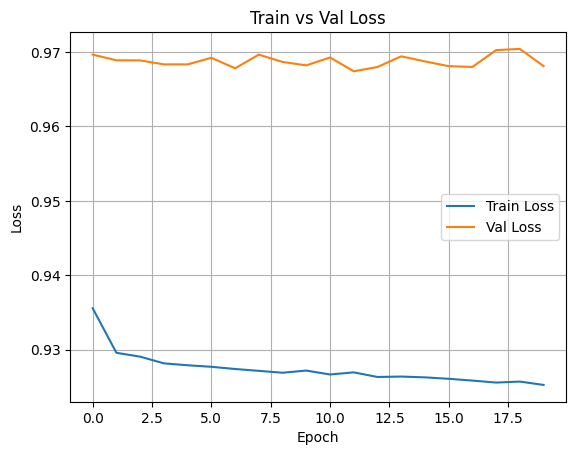


📊 평균 Test R²: -0.0330 ± 0.0137


In [7]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,
    "num_layers": 1,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 0.001
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path="ablation_result_gru.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 11), y_train shape: (20310,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_d

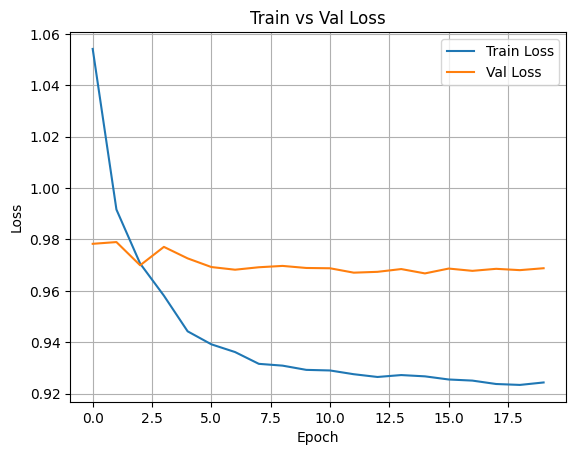


📊 평균 Test R²: -0.2994 ± 0.2077


In [8]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "num_filters": 64,         # CNN conv 채널 수
    "kernel_size": 5,          # receptive field
    "dropout": 0.3,            # regularization
    "batch_size": 32,          # mini-batch size
    "learning_rate": 0.001,    # learning rate
    "input_channels": X_train.shape[1]  # CNN용 필수 입력!
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 11), y_train shape: (20310,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_d

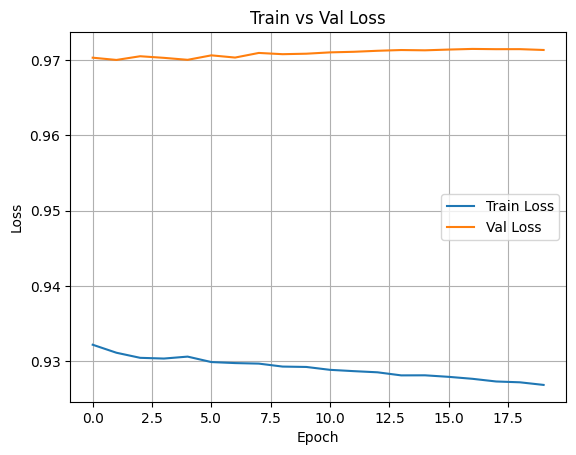


📊 평균 Test R²: -0.0053 ± 0.0054


In [9]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU_Attn"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # GRU hidden state 크기
    "num_layers": 1,          # GRU layer 수 (보통 1)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001,   # 학습률
    "use_attention": True     # 🔥 Attention 사용 여부 (GRU 기반 모델에서 이 플래그 사용)
}
df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001],
    "use_attention": [True]  # 고정 (Attention 모델만 탐색)
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 11), y_train shape: (20310,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (20310, 240, 10), y_train shape: (20310,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_d

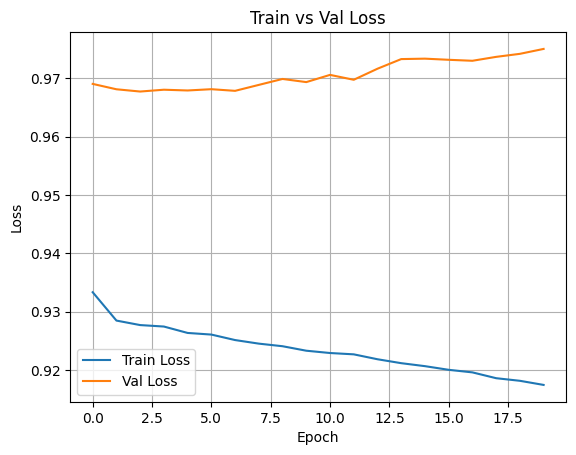


📊 평균 Test R²: -0.0238 ± 0.0083


In [10]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "LSTM"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # LSTM hidden state 크기
    "num_layers": 1,          # LSTM layer 수 (stack depth)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001    # 학습률
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


## Window 5 stride 3

🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 11), y_train shape: (6726,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloaders X

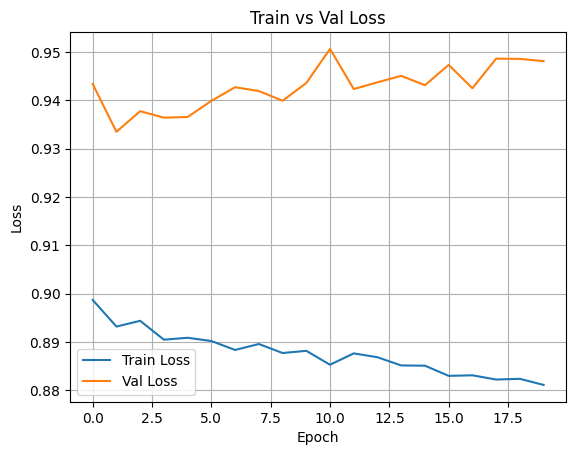


📊 평균 Test R²: -0.0273 ± 0.0168


In [15]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,
    "num_layers": 1,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 0.001
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path="ablation_result_gru.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 11), y_train shape: (6726,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloaders X

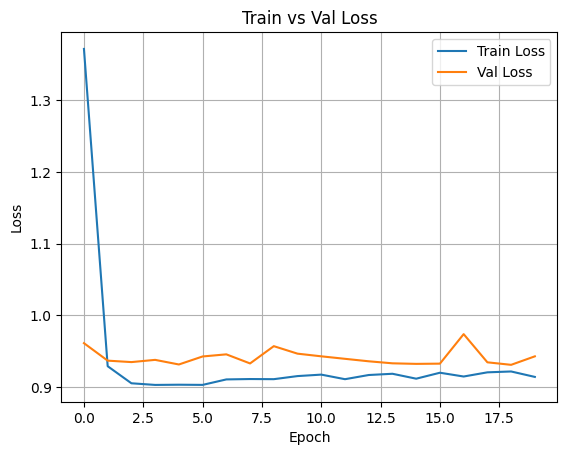


📊 평균 Test R²: -0.1814 ± 0.1707


In [16]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "num_filters": 64,         # CNN conv 채널 수
    "kernel_size": 5,          # receptive field
    "dropout": 0.3,            # regularization
    "batch_size": 32,          # mini-batch size
    "learning_rate": 0.001,    # learning rate
    "input_channels": X_train.shape[1]  # CNN용 필수 입력!
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 11), y_train shape: (6726,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloaders X

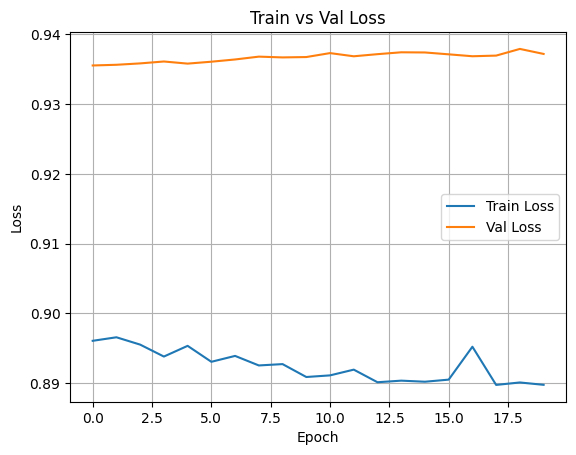


📊 평균 Test R²: -0.0295 ± 0.0399


In [17]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU_Attn"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # GRU hidden state 크기
    "num_layers": 1,          # GRU layer 수 (보통 1)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001,   # 학습률
    "use_attention": True     # 🔥 Attention 사용 여부 (GRU 기반 모델에서 이 플래그 사용)
}
df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001],
    "use_attention": [True]  # 고정 (Attention 모델만 탐색)
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 11), y_train shape: (6726,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (6726, 600, 10), y_train shape: (6726,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloaders X

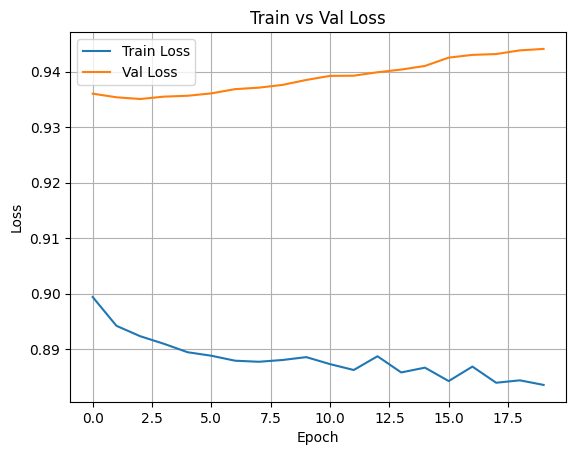


📊 평균 Test R²: -0.0165 ± 0.0088


In [18]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "LSTM"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # LSTM hidden state 크기
    "num_layers": 1,          # LSTM layer 수 (stack depth)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001    # 학습률
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


### Window 10 stride 5

🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 11), y_train shape: (3982,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

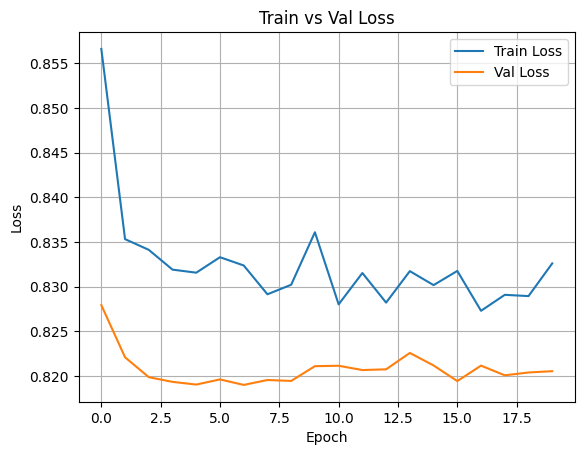


📊 평균 Test R²: -0.0334 ± 0.0196


In [3]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,
    "num_layers": 1,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 0.001
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path="ablation_result_gru.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 11), y_train shape: (3982,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

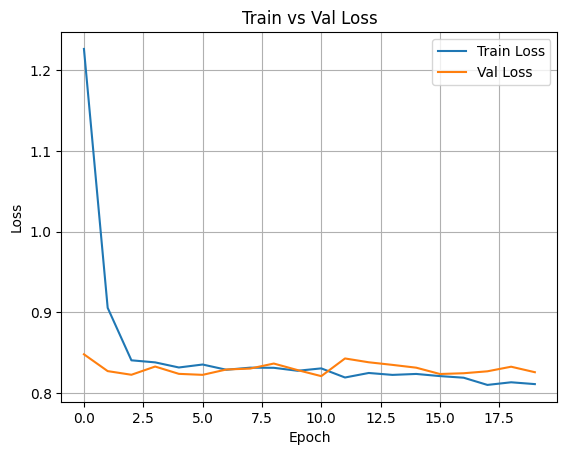


📊 평균 Test R²: -0.2666 ± 0.3553


In [5]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "num_filters": 64,         # CNN conv 채널 수
    "kernel_size": 5,          # receptive field
    "dropout": 0.3,            # regularization
    "batch_size": 32,          # mini-batch size
    "learning_rate": 0.001,    # learning rate
    "input_channels": X_train.shape[1]  # CNN용 필수 입력!
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 11), y_train shape: (3982,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

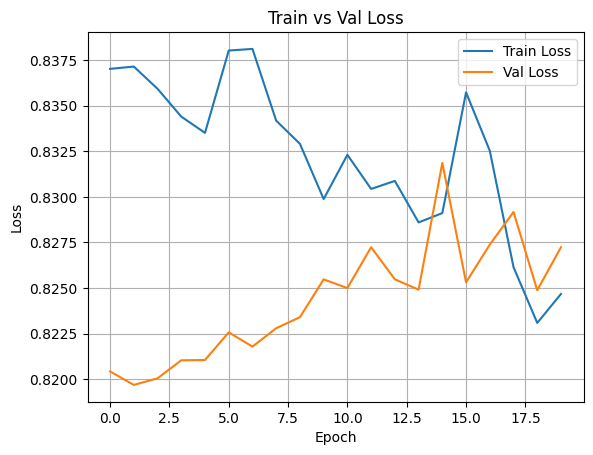


📊 평균 Test R²: -0.0053 ± 0.0054


In [6]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU_Attn"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # GRU hidden state 크기
    "num_layers": 1,          # GRU layer 수 (보통 1)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001,   # 학습률
    "use_attention": True     # 🔥 Attention 사용 여부 (GRU 기반 모델에서 이 플래그 사용)
}
df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001],
    "use_attention": [True]  # 고정 (Attention 모델만 탐색)
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 11), y_train shape: (3982,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (3982, 1200, 10), y_train shape: (3982,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

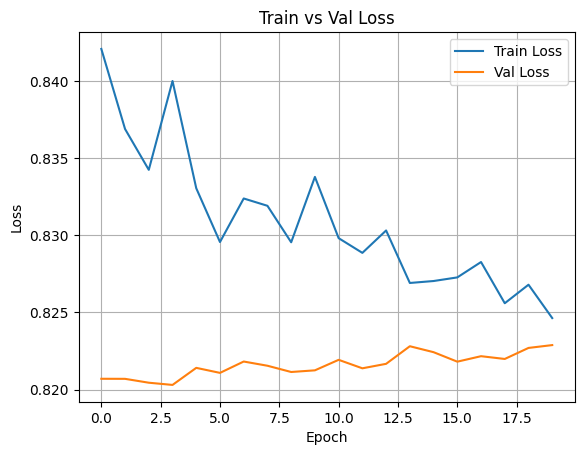


📊 평균 Test R²: -0.0166 ± 0.0089


In [7]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "LSTM"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed_raw", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # LSTM hidden state 크기
    "num_layers": 1,          # LSTM layer 수 (stack depth)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001    # 학습률
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 11), y_train shape: (9556,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

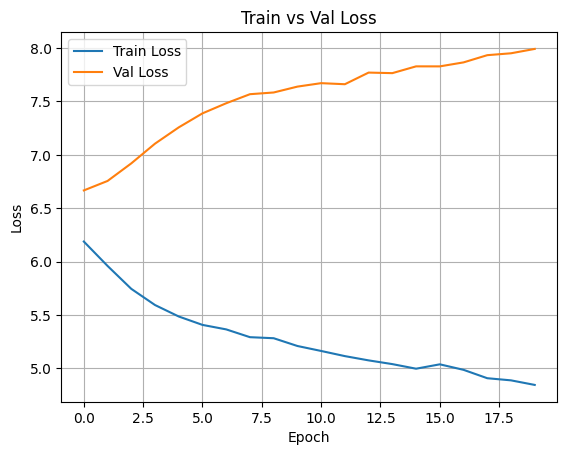


📊 평균 Test R²: -0.1188 ± 0.0748


In [ ]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,
    "num_layers": 1,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 0.001
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path="ablation_result_gru.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 11), y_train shape: (9556,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

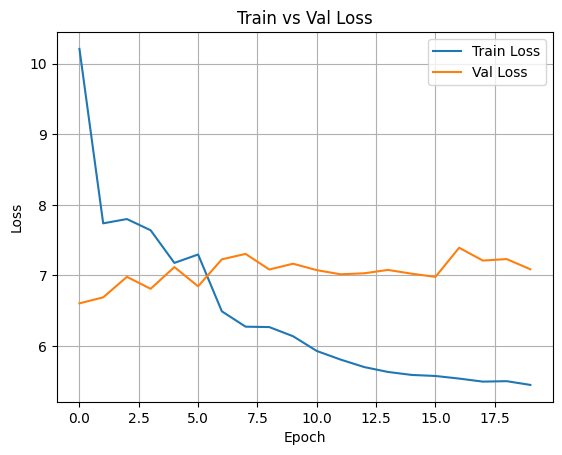


📊 평균 Test R²: -0.7355 ± 0.7801


In [4]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "CNN"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "num_filters": 64,         # CNN conv 채널 수
    "kernel_size": 5,          # receptive field
    "dropout": 0.3,            # regularization
    "batch_size": 32,          # mini-batch size
    "learning_rate": 0.001,    # learning rate
    "input_channels": X_train.shape[1]  # CNN용 필수 입력!
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 11), y_train shape: (9556,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

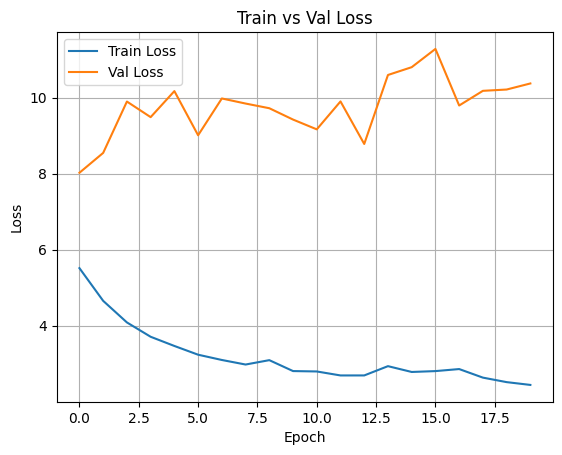


📊 평균 Test R²: -0.1504 ± 0.0640


In [8]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "GRU_Attn"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # GRU hidden state 크기
    "num_layers": 1,          # GRU layer 수 (보통 1)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001,   # 학습률
    "use_attention": True     # 🔥 Attention 사용 여부 (GRU 기반 모델에서 이 플래그 사용)
}
df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001],
    "use_attention": [True]  # 고정 (Attention 모델만 탐색)
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


🧪 Training baseline | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 11), y_train shape: (9556,)
🔍 Removing EDA_Tonic (1/11)
🧪 Training EDA_Tonic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing EDA_Phasic (2/11)
🧪 Training EDA_Phasic | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_Amplitude (3/11)
🧪 Training SCR_Amplitude | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing SCR_RiseTime (4/11)
🧪 Training SCR_RiseTime | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing PPG_Rate (5/11)
🧪 Training PPG_Rate | use_internal_split = True
🎯 create_dataloaders X_train shape: (9556, 2400, 10), y_train shape: (9556,)
🔍 Removing RSP_Rate (6/11)
🧪 Training RSP_Rate | use_internal_split = True
🎯 create_dataloa

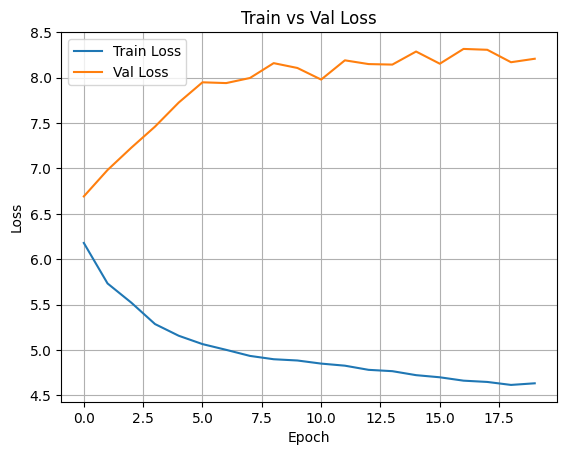


📊 평균 Test R²: -0.0896 ± 0.0316


In [1]:
import torch
from ml_pipeline import (
    load_and_split_data,
    run_ablation,
    select_features_by_ablation,
    run_grid_search,
    train_and_evaluate_seeds,
    summarize_test_results
)
from ml_utils import set_seed, to_loader_simple, evaluate_and_save
# -----------------------------------------------
# 1. 설정
# -----------------------------------------------
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "LSTM"  # ✅ GRU 사용

# -----------------------------------------------
# 2. 데이터 로드 및 Split
# -----------------------------------------------
X_train, y_train, pid_train, \
X_val, y_val, pid_val, \
X_test, y_test, pid_test, \
feature_tag_list = load_and_split_data(path="ml_processed", seed=seed)

# -----------------------------------------------
# 3. Feature ablation
# -----------------------------------------------
fixed_params = {
    "hidden_size": 64,        # LSTM hidden state 크기
    "num_layers": 1,          # LSTM layer 수 (stack depth)
    "dropout": 0.3,           # dropout 비율
    "batch_size": 32,         # mini-batch size
    "learning_rate": 0.001    # 학습률
}

df_ablation = run_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tag_list,
    model_type=model_type,
    fixed_params=fixed_params,
    seed=seed,
    num_epochs=10,
    save_path=f"ablation_result_{model_type}.csv"
)

# -----------------------------------------------
# 4. Feature selection based on ablation
# -----------------------------------------------
keep_features, keep_indices = select_features_by_ablation(df_ablation, feature_tag_list)

# ✅ 선택된 feature만 적용
X_train = X_train[:, :, keep_indices]
X_val   = X_val[:, :, keep_indices]
X_test  = X_test[:, :, keep_indices]

# -----------------------------------------------
# 5. Grid Search
# -----------------------------------------------
search_space = {
    "hidden_size": [16, 32, 64],
    "num_layers": [1],
    "dropout": [0.3, 0.4, 0.5, 0.6],
    "batch_size": [32],
    "learning_rate": [0.001, 0.0003, 0.0001]
}

best_params, _ = run_grid_search(
    X_train, y_train, pid_train,
    model_type=model_type,
    search_space=search_space,
    seed=seed,
    num_epochs=20
)

# -----------------------------------------------
# 6. Train + Evaluate on seeds
# -----------------------------------------------
import numpy as np
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)



train_losses, val_losses, test_scores = train_and_evaluate_seeds(
    X_trainval, y_trainval, pid_trainval,
    X_test, y_test,
    model_type=model_type,
    best_params=best_params,
    device=device,
    num_seeds=10,
    num_epochs=20
)

# -----------------------------------------------
# 7. 결과 요약
# -----------------------------------------------
from ml_utils import plot_train_val_loss
plot_train_val_loss(train_losses[0], val_losses[0])  # 첫 seed 기준 시각화

summarize_test_results(test_scores)


In [6]:
print("Train mean/std:", np.mean(y_train), np.std(y_train))
print("Test  mean/std:", np.mean(y_test), np.std(y_test))

Train mean/std: 0.3724193276619207 2.450074628665405
Test  mean/std: 0.7351851086426975 2.3529193323445035


In [3]:
train_losses

[GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 GRURegressor(
   (gru): GRU(11, 32, batch_first=True)
 

In [8]:
import numpy as np
import pandas as pd
from ml_utils import set_seed, run_feature_ablation, mask

# 1. Set seed and environment
seed = 42
set_seed(seed)

# 2. Load your full dataset
X_array = np.load("ml_processed/X_array.npy")           # shape (B, T, F)
y_array = np.load("ml_processed/y_array.npy")
pid_array = np.load("ml_processed/pid_array.npy")
feature_tag_list = np.load("ml_processed/feature_tag_list.npy").tolist()

# 3. Split into train/val/test (80/10/10) by participant
unique_pids = np.unique(pid_array)
np.random.default_rng(seed).shuffle(unique_pids)
n = len(unique_pids)
p_train = unique_pids[:int(n * 0.8)]
p_val   = unique_pids[int(n * 0.8):int(n * 0.9)]
p_test  = unique_pids[int(n * 0.9):]

X_train, y_train, pid_train = mask(X_array, y_array, pid_array, p_train)
X_val, y_val, pid_val = mask(X_array, y_array, pid_array, p_val)
X_test, y_test, pid_test = mask(X_array, y_array, pid_array, p_test)

# 4. Safety check
if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
    raise ValueError("❌ Train/Val/Test split 중 하나 이상이 비었습니다. participant 분포 확인 필요.")

print(f"✅ Train: {len(p_train)} pids → {X_train.shape}")
print(f"✅ Val:   {len(p_val)} pids → {X_val.shape}")
print(f"✅ Test:  {len(p_test)} pids → {X_test.shape}")

# 5. Fixed hyperparameters
fixed_params = {
    "num_filters": 32,
    "kernel_size": 5,
    "dropout": 0.3,
    "batch_size": 32,
    "learning_rate": 0.001
}

# 6. Run Ablation
df_result = run_feature_ablation(
    X_train, y_train, pid_train,
    X_val, y_val, pid_val,
    feature_tags=feature_tag_list,
    model_type="CNN",
    fixed_params=fixed_params,
    num_epochs=10,
    seed=seed
)

# 7. Save or visualize1
df_result.to_csv("ablation_result.csv", index=False)
print("✅ Ablation 결과 저장 완료!")
print(df_result)


✅ Train: 85 pids → (12278, 2400, 11)
✅ Val:   11 pids → (2169, 2400, 11)
✅ Test:  11 pids → (2899, 2400, 11)
🔍 Removing EDA_Tonic (1/11)
🔍 Removing EDA_Phasic (2/11)
🔍 Removing SCR_Amplitude (3/11)
🔍 Removing SCR_RiseTime (4/11)
🔍 Removing PPG_Rate (5/11)
🔍 Removing RSP_Rate (6/11)
🔍 Removing RSP_RVT (7/11)
🔍 Removing RSP_Amplitude (8/11)
🔍 Removing pupilL (9/11)
🔍 Removing pupilR (10/11)
🔍 Removing pupil_mean (11/11)
✅ Ablation 결과 저장 완료!
    feature_removed    val_r2
0   None (baseline) -0.867336
1         EDA_Tonic -1.212611
2        EDA_Phasic -1.359011
3     SCR_Amplitude -1.382057
4      SCR_RiseTime -1.384615
5          PPG_Rate -1.362658
6          RSP_Rate -1.345586
7           RSP_RVT -1.339554
8     RSP_Amplitude -1.483774
9            pupilL -1.013611
10           pupilR -1.006588
11       pupil_mean -1.013423


In [ ]:
import numpy as np
import pandas as pd
import gc
import torch
from ml_utils import (
    set_seed, mask, train_model, evaluate_and_save,
    get_model, grid_search_model
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 3. Participant 기반 split ----------
unique_pids = np.unique(pid_array)
np.random.default_rng(seed).shuffle(unique_pids)
n = len(unique_pids)
p_train = unique_pids[:int(n * 0.8)]
p_val   = unique_pids[int(n * 0.8):int(n * 0.9)]
p_test  = unique_pids[int(n * 0.9):]

X_train, y_train, pid_train = mask(X_array, y_array, pid_array, p_train)
X_val, y_val, pid_val       = mask(X_array, y_array, pid_array, p_val)
X_test, y_test, pid_test    = mask(X_array, y_array, pid_array, p_test)

# ---------- 4. Ablation 결과 로드 & feature selection ----------
df_result = pd.read_csv("ablation_result.csv")
baseline_r2 = df_result[df_result["feature_removed"] == "None (baseline)"]["val_r2"].values[0]

# ✅ baseline보다 성능이 낮아지지 않은 feature만 유지
keep_features = []
for i, feat in enumerate(feature_tag_list):
    row = df_result[df_result["feature_removed"] == feat]
    if not row.empty and row["val_r2"].values[0] <= baseline_r2:
        keep_features.append(feat)

print(f"📌 선택된 feature 수: {len(keep_features)} / {len(feature_tag_list)}")
keep_indices = [feature_tag_list.index(f) for f in keep_features]
# ---------- CNN용 Grid Search ----------
search_space = {
    "num_filters": [16, 32, 64],
    "kernel_size": [3, 5, 7],            # ✔️ 조금 더 큰 receptive field도 고려
    "dropout": [0.3, 0.5, 0.7],          # ✔️ overfitting 대비
    "batch_size": [16, 32, 64],          # ✔️ 작은 batch는 regularization 효과
    "learning_rate": [1e-4, 3e-4, 1e-3]  # ✔️ 너무 크면 불안정 → 하향 탐색
}

best_params, _ = grid_search_model(
    X_train, y_train, pid_train,
    model_type="CNN",
    search_space=search_space,
    num_epochs=20,
    seed=seed
)


📌 선택된 feature 수: 9 / 11
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 16, 'learning_rate': 0.0001}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 16, 'learning_rate': 0.0003}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 16, 'learning_rate': 0.001}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.0001}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.0003}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.0001}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.0003}
🔍 Trying {'num_filters': 16, 'kernel_size': 3, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.001}
🔍 Trying {'num_filters': 


🟢 SEED 0 시작

Saved predictions to cnn_test_predictions_seed0.npz
📊 Test R²: -0.3680 | RMSE: 2.7521 | MAE: 2.0890

🟢 SEED 1 시작

Saved predictions to cnn_test_predictions_seed1.npz
📊 Test R²: -0.0987 | RMSE: 2.4663 | MAE: 1.7869

🟢 SEED 2 시작

Saved predictions to cnn_test_predictions_seed2.npz
📊 Test R²: -0.6551 | RMSE: 3.0271 | MAE: 2.3290

🟢 SEED 3 시작

Saved predictions to cnn_test_predictions_seed3.npz
📊 Test R²: -0.6311 | RMSE: 3.0051 | MAE: 2.3105

🟢 SEED 4 시작

Saved predictions to cnn_test_predictions_seed4.npz
📊 Test R²: -0.3378 | RMSE: 2.7214 | MAE: 2.0817

🟢 SEED 5 시작

Saved predictions to cnn_test_predictions_seed5.npz
📊 Test R²: -0.8380 | RMSE: 3.1899 | MAE: 2.4603

🟢 SEED 6 시작

Saved predictions to cnn_test_predictions_seed6.npz
📊 Test R²: -0.1249 | RMSE: 2.4955 | MAE: 1.8315

🟢 SEED 7 시작

Saved predictions to cnn_test_predictions_seed7.npz
📊 Test R²: -0.3637 | RMSE: 2.7477 | MAE: 2.0624

🟢 SEED 8 시작

Saved predictions to cnn_test_predictions_seed8.npz
📊 Test R²: -0.2071 | R

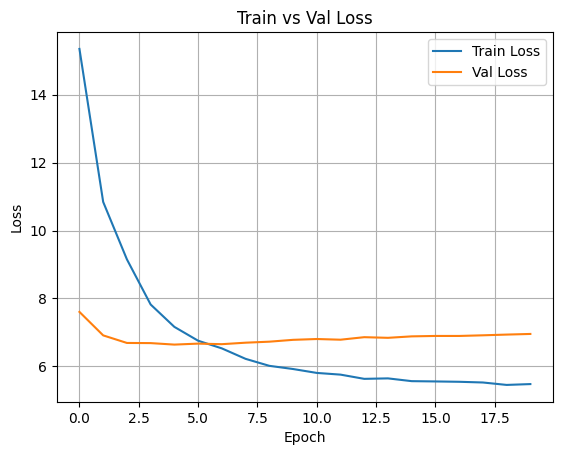


📊 평균 Test R2: -0.3605 ± 0.2608


In [4]:
import numpy as np
import torch
import gc
from ml_utils import set_seed, train_model, get_model, evaluate_and_save, plot_train_val_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 고정된 train/val/test split
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)
pid_trainval = np.concatenate([pid_train, pid_val], axis=0)


# 🔹 결과 저장용
all_train_losses = []
all_val_losses = []
all_test_scores = []

for seed in range(10):
    print(f"\n🟢 SEED {seed} 시작\n")

    set_seed(seed)

    # 1. 학습 (return_curve=True)
    train_losses, val_losses, _, _, _ = train_model(
        X_trainval, y_trainval,
        params=best_params,
        model_type="CNN",
        num_epochs=20,
        seed=seed,
        pid_array=pid_trainval,
        return_curve=True
    )

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # 2. 테스트 평가 및 저장
    model_final = get_model("CNN", input_size=X_test.shape[2], params=best_params).to(device)
    filename = f"cnn_test_predictions_seed{seed}.npz"
    test_r2, test_rmse, test_mae, _ = evaluate_and_save(model_final, [(X_test, y_test)], device, filename)
    all_test_scores.append((test_r2, test_rmse, test_mae))

    # 3. 메모리 정리
    del model_final
    torch.cuda.empty_cache()
    gc.collect()

# ✅ 평균 plot (예시: seed 0)
plot_train_val_loss(all_train_losses[0], all_val_losses[0])

# 평균 테스트 결과 출력
test_r2s = [r2 for r2, _, _ in all_test_scores]
print(f"\n📊 평균 Test R2: {np.mean(test_r2s):.4f} ± {np.std(test_r2s):.4f}")
